In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Circle
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize, ListedColormap
import matplotlib.colorbar as colorbar
import matplotlib.gridspec as gridspec
from matplotlib.widgets import Slider
import matplotlib.animation as animation
import matplotlib as mat
import os
import os.path as op
from scipy.stats import gaussian_kde
from matplotlib import font_manager as fm
import seaborn as sns
# import statsmodels.api as sm
from scipy.interpolate import make_interp_spline
from scipy.stats import rayleigh, norm
# from sklearn.model_selection import GridSearchCV
# from sklearn.neighbors import KernelDensity
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.signal import savgol_filter
from peregrin.scripts import PlotParams, FilesAndFolders
from itertools import combinations
from scipy.stats import mannwhitneyu
import plotly.express as px
import plotly.graph_objects as go

# import fitz
import altair as alt

In [155]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [156]:
input_file1 = r"C:\Users\modri\Desktop\Lab\runs from the same experiment\C2-position_spots1.csv"
input_file2 = r"C:\Users\modri\Desktop\Lab\runs from the same experiment\C2-position_spots2.csv"
input_file3 = r"C:\Users\modri\Desktop\Lab\runs from the same experiment\C2-position_spots3.csv"

In [157]:
input_files = [input_file1, input_file2, input_file3]

input_filesA = [input_file1, input_file2]
input_filesB = [input_file2, input_file3]
input_filesC = [input_file1, input_file3]

# parsed_input = [input_filesA, input_filesB, input_filesC]
parsed_input = [input_filesA, input_filesC]
# input_files = [input_file1]

In [158]:
# ===========================================================================================================================================================================================================================================================================	
# Optics parameters

# Definition of micron length per pixel
microns_per_pixel = 0.7381885238402274 # for 10x lens

# Define the desired dimensions in microns
x_min, x_max = 0, (1600 * microns_per_pixel)
y_min, y_max = 0, (1200 * microns_per_pixel)
x_axe_remainder = x_max-1150
x_add = 50 - x_axe_remainder
y_ax_remainder = y_max-850
x_substract = (x_max - y_max) + (y_ax_remainder - 50)

# Calculate the aspect ratio
aspect_ratio = x_max / y_max



# ===========================================================================================================================================================================================================================================================================
# Globally used callables

# plot specs
title_size = 16
title_size2 = 12
label_size = 11
figtext_size = 9
compass_annotations_size = 15
figtext_color = 'grey'

# Color maps
cmap_cells = mcolors.LinearSegmentedColormap.from_list("", ["#9b598910", "#9b181eff"])
cmap_frames = plt.get_cmap('viridis')


In [159]:
def try_convert_numeric(x):
    try:
        # Only process strings
        if isinstance(x, str):
            x_stripped = x.strip()
            num = float(x_stripped)
            if num.is_integer():
                return int(num)
            else:
                return num
        else:
            return x
    except ValueError:
        return x

In [160]:
def merge_dfs(dataframes, on):

    # Initialize the first DataFrame as the base for merging
    merged_df = dataframes[0].map(str)

    # Use a for loop to merge each subsequent DataFrame
    for df in dataframes[1:]:

        df = df.reset_index(drop=True)
        df = df.map(str)
        merge_columns = [col for col in df.columns if col not in merged_df.columns or col in on]
        merged_df = pd.merge(
            merged_df,
            df[merge_columns],  # Select only necessary columns from df
            on=on,
            how='outer'
        )
    
    merged_df = merged_df.map(try_convert_numeric)
    return merged_df

In [161]:
def butter(df):                                                                                      # Smoothing the raw dataframe

    float_columns = [ # Definition of unneccesary float columns in the df which are to be convertet to integers
    'ID', 
    'TRACK_ID', 
    'POSITION_T', 
    'FRAME'
    ]

    df = pd.DataFrame(df)  
    df = df.apply(pd.to_numeric, errors='coerce').dropna(subset=['POSITION_X', 'POSITION_Y', 'POSITION_T'])                                 # Gets rid of the multiple index rows by converting the values to a numeric type and then dropping the NaN values

    # For some reason, the y coordinates extracted from trackmate are mirrored. That ofcourse would not affect the statistical tests, only the data visualization. However, to not get mindfucked..
    # Reflect y-coordinates around the midpoint for the directionality to be accurate, according to the microscope videos.
    y_mid = (df['POSITION_Y'].min() + df['POSITION_Y'].max()) / 2
    df['POSITION_Y'] = 2 * y_mid - df['POSITION_Y']

    df['POSITION_Y'] = df['POSITION_Y'] * microns_per_pixel
    df['POSITION_X'] = df['POSITION_X'] * microns_per_pixel

    columns_list = df.columns.tolist()
    columns_list.remove('LABEL')

    df = df[columns_list]

    # Here we convert the unnecessary floats (from the list in which we defined them) to integers
    df[float_columns] = df[float_columns].astype(int)

    return df



In [162]:
def parsed_file(input_files):  # File-reading
    # =============================================================================================================================================================================================================================================================================
    # Processing the default input files

    if input_files is None:
        return pd.DataFrame()

    all_data_dflt = []
    for list_count, sublist in enumerate(input_files, start=1):  # Enumerate and cycle through input lists
        condition = list_count  # Assign a unique condition number for each list
        for file_count, file_dflt in enumerate(sublist, start=1):  # Enumerate and cycle through files in the sublist
            df_dflt = pd.read_csv(file_dflt)
            buttered_dflt = butter(df_dflt)  # Process the DataFrame

            buttered_dflt['CONDITION'] = condition  # Assign the condition number
            buttered_dflt['REPLICATE'] = file_count  # Assign the replicate number

            all_data_dflt.append(buttered_dflt)  # Store processed DataFrame

    default = pd.concat(all_data_dflt, axis=0)  # Join the DataFrames
    return default

# Example usage
buttered = parsed_file(parsed_input)  # Displayed data is the processed DataFram
# display(cic)


In [163]:
'''
def parsed_file(input_files):                              # File-reading 
        
    # =============================================================================================================================================================================================================================================================================
    # Processing the default input files

                    
    inpt_file_list_dflt = input_files                                               # Getting the list of default input files

    if inpt_file_list_dflt is None:
        default = pd.DataFrame()

    else:
        all_data_dflt = []
        for file_count, file_dflt in enumerate(inpt_file_list_dflt, start=1):       # Enumerate and cycle through default input files
            df_dflt = pd.read_csv(file_dflt)                     
            buttered_dflt = butter(df_dflt)                                      # Process the DataFrame


                                                                
            label_dflt = 'file'                                            # Getting the label to assign the 'CONDITION' column parameter
            buttered_dflt['CONDITION'] = f"{label_dflt}"
            buttered_dflt['REPLICATE'] = f"{file_count}"                            # Assign the 'FILE' column parameter

            buttered_dflt = buttered_dflt                         # Drop duplicates
            all_data_dflt += [buttered_dflt]                                        # Store processed DataFrame

            default = pd.concat(all_data_dflt, axis=0)                              # Join the DataFrames

    return default

display(parsed_file(input_files)) # Displayed data is the processed DataFrame
'''


'\ndef parsed_file(input_files):                              # File-reading \n        \n    # =============================================================================================================================================================================================================================================================================\n    # Processing the default input files\n\n                    \n    inpt_file_list_dflt = input_files                                               # Getting the list of default input files\n\n    if inpt_file_list_dflt is None:\n        default = pd.DataFrame()\n\n    else:\n        all_data_dflt = []\n        for file_count, file_dflt in enumerate(inpt_file_list_dflt, start=1):       # Enumerate and cycle through default input files\n            df_dflt = pd.read_csv(file_dflt)                     \n            buttered_dflt = butter(df_dflt)                                      # Process the DataFrame\n\n\n               

In [164]:
def try_convert_numeric(x):
    try:
        # Only process strings
        if isinstance(x, str):
            x_stripped = x.strip()
            num = float(x_stripped)
            if num.is_integer():
                return int(num)
            else:
                return num
        else:
            return x
    except ValueError:
        return x

In [165]:
# buttered = parsed_file(input_files)
# display(buttered)

In [166]:

def calculate_traveled_distances_for_each_cell_per_frame(df):

    if df.empty:
        return np.nan

    # Ensure the DataFrame is sorted properly by CONDITION, TRACK_ID, and POSITION_T (time)
    df_sorted = df.sort_values(by=['CONDITION', 'REPLICATE', 'POSITION_T'])

    # For each track (within each condition), shift the coordinates to get the "next" point
    next_POSITION_X = df_sorted.groupby(['CONDITION', 'REPLICATE', 'TRACK_ID'])['POSITION_X'].shift(-1)
    next_POSITION_Y = df_sorted.groupby(['CONDITION', 'REPLICATE', 'TRACK_ID'])['POSITION_Y'].shift(-1)
    # df_sorted['next_POSITION_Z'] = df_sorted.groupby(['CONDITION', 'TRACK_ID'])['POSITION_Z'].shift(-1)

    # Calculate the Euclidean distance for the XY plane between consecutive points
    df_sorted['DISTANCE'] = np.sqrt(
        (next_POSITION_X - df_sorted['POSITION_X'])**2 +
        (next_POSITION_Y - df_sorted['POSITION_Y'])**2
    )

    # Optionally, drop rows where the next value is missing (i.e. the last row per track)
    df_sorted['DISTANCE'] = df_sorted['DISTANCE'].fillna(0)
    df_result = df_sorted

    # Display the results
    return df_result



display(calculate_traveled_distances_for_each_cell_per_frame(buttered))



ID  TRACK_ID   QUALITY  POSITION_X  POSITION_Y  POSITION_Z  \
59      78691         0  1.917663  734.405241  159.708518         0.0   
215     78696         1  1.938016  667.196865  148.348377         0.0   
359     78697         3  1.995014  494.272196  142.511364         0.0   
508     78699         4  2.663755   60.637322  137.039638         0.0   
652     78701         5  2.342726  176.407243  134.859459         0.0   
...       ...       ...       ...         ...         ...         ...   
14919  244143       618  1.336532  469.887837  234.087753         0.0   
14949  244082       622  2.203650  484.166955  383.863573         0.0   
14968  244176       646  1.059941  275.892554  152.424451         0.0   
14982  244041       659  1.986115  737.522160  479.954478         0.0   
15006  244017       669  2.868753  551.727675  560.078580         0.0   

       POSITION_T  FRAME  RADIUS  VISIBILITY  ...  MAX_INTENSITY_CH1  \
59              0      0     2.5         1.0  ...                9.0   
215             0      0     2.5         1.0  ...                9.0   
359             0      0     2.5         1.0  ...                9.0   
508             0      0     2.5         1.0  ...               12.0   
652             0      0     2.5         1.0  ...               11.0   
...           ...    ...     ...         ...  ...                ...   
14919         149    149     2.5         1.0  ...                6.0   
14949         149    149     2.5         1.0  ...               10.0   
14968         149    149     2.5         1.0  ...                5.0   
14982         149    149     2.5         1.0  ...                9.0   
15006         149    149     2.5         1.0  ...               13.0   

       TOTAL_INTENSITY_CH1  STD_INTENSITY_CH1  EXTRACK_P_STUCK  \
59                   254.0           2.800418              NaN   
215                  248.0           3.281809              NaN   
359                  271.0           2.698292              NaN   
508                  361.0           3.932807              NaN   
652                  305.0           4.316669              NaN   
...                    ...                ...              ...   
14919                188.0           1.831490              NaN   
14949                294.0           3.922485              NaN   
14968                132.0           1.937073              NaN   
14982                261.0           3.072693              NaN   
15006                396.0           3.710831              NaN   

       EXTRACK_P_DIFFUSIVE  CONTRAST_CH1   SNR_CH1  CONDITION  REPLICATE  \
59                     NaN      0.722242  2.056022          1          1   
215                    NaN      0.730721  1.724612          1          1   
359                    NaN      0.768847  2.359708          1          1   
508                    NaN      0.778638  2.172106          1          1   
652                    NaN      0.717273  1.595235          1          1   
...                    ...           ...       ...        ...        ...   
14919                  NaN      0.779821  2.431086          2          2   
14949                  NaN      0.776435  1.770803          2          2   
14968                  NaN      0.723881  1.546735          2          2   
14982                  NaN      0.773700  2.002821          2          2   
15006                  NaN      0.765521  2.501131          2          2   

       DISTANCE  
59     1.840634  
215    1.209361  
359    0.841833  
508    3.130401  
652    0.752148  
...         ...  
14919  0.000000  
14949  0.000000  
14968  0.000000  
14982  0.000000  
15006  0.000000  

[67897 rows x 24 columns]

In [167]:

def calculate_direction_of_travel_for_each_cell_per_frame(df):
    directions = []
    for condition in df['CONDITION'].unique():
        unique_cond = df[df['CONDITION'] == condition]
        for replicate in unique_cond['REPLICATE'].unique():
            unique_rep = unique_cond[unique_cond['REPLICATE'] == replicate]
            for track_id in unique_rep['TRACK_ID'].unique():   
                unique_track = unique_rep[unique_rep['TRACK_ID'] == track_id]
                dx = unique_track['POSITION_X'].diff().iloc[1:]
                dy = unique_track['POSITION_Y'].diff().iloc[1:]
                rad = (np.arctan2(dy, dx))
                for i in range(len(rad)):
                    directions.append({
                        'CONDITION': unique_cond['CONDITION'].iloc[i],
                        'REPLICATE': unique_rep['REPLICATE'].iloc[i],
                        'TRACK_ID': unique_track['TRACK_ID'].iloc[i], 
                        'POSITION_T': unique_track['POSITION_T'].iloc[i], 
                        'DIRECTION_RAD': rad.iloc[i],
                        })
    directions_df = pd.DataFrame(directions)
    return directions_df

display(calculate_direction_of_travel_for_each_cell_per_frame(buttered))


CONDITION  REPLICATE  TRACK_ID  POSITION_T  DIRECTION_RAD
0              1          1         0          85       1.514215
1              1          1         0           1      -1.256274
2              1          1         0          50      -1.945883
3              1          1         0          93       1.582962
4              1          1         0           7      -1.375615
...          ...        ...       ...         ...            ...
67031          2          2       669         135       1.828038
67032          2          2       669         134      -1.425180
67033          2          2       669         138      -2.182896
67034          2          2       669         142       0.394099
67035          2          2       669         139      -2.870165

[67036 rows x 5 columns]

In [168]:
def calculate_track_length_net_distances_and_confinement_ratios_per_each_cell_per_frame(df):
    # Sort the DataFrame by CONDITION, REPLICATE, TRACK_ID, and POSITION_T
    df = df.sort_values(by=['CONDITION', 'REPLICATE', 'TRACK_ID', 'POSITION_T'])

    # Calculate cumulative track length for each track
    df['TRACK_LENGTH'] = df.groupby(['CONDITION', 'REPLICATE', 'TRACK_ID'])['DISTANCE'].cumsum()

    # Get the starting position for each track
    start_positions = df.groupby(['CONDITION', 'REPLICATE', 'TRACK_ID'])[['POSITION_X', 'POSITION_Y']].transform('first')

    # Calculate net distance from the starting position
    df['NET_DISTANCE'] = np.sqrt(
        (df['POSITION_X'] - start_positions['POSITION_X'])**2 +
        (df['POSITION_Y'] - start_positions['POSITION_Y'])**2
    )

    # Calculate confinement ratio
    df['CONFINEMENT_RATIO'] = df['NET_DISTANCE'] / df['TRACK_LENGTH']
    df['CONFINEMENT_RATIO'] = df['CONFINEMENT_RATIO'].fillna(0)  # Handle division by zero

    return df

In [169]:
distances_for_each_cell_per_frame_df = calculate_traveled_distances_for_each_cell_per_frame(buttered)        # Call the function to calculate distances for each cell per frame and create the Spot_statistics .csv file
distances_for_each_cell_per_frame_df = calculate_track_length_net_distances_and_confinement_ratios_per_each_cell_per_frame(distances_for_each_cell_per_frame_df)
direction_for_each_cell_per_frame_df = calculate_direction_of_travel_for_each_cell_per_frame(buttered)       # Call the function to calculate direction_for_each_cell_per_frame_df

Spot_stats_dfs = [buttered, distances_for_each_cell_per_frame_df, direction_for_each_cell_per_frame_df]

Spot_stats = merge_dfs(Spot_stats_dfs, on=['CONDITION', 'REPLICATE', 'TRACK_ID', 'POSITION_T']) # Merge the dataframes
# Spot_stats = Spot_stats.sort_values(by=['CONDITION', 'REPLICATE', 'POSITION_T'])	

# Spot_stats = calculate_track_length_net_distances_and_confinement_ratios_per_each_cell_per_frame(Spot_stats)

display(Spot_stats)

d_types = Spot_stats.map(type)
print(d_types)

Spot_stats.to_csv(r'C:\Users\modri\Desktop\python\Peregrin\Peregrin\test data\Spot stats.csv', index=False) # Save the Spot_statistics .csv file



ID  TRACK_ID   QUALITY  POSITION_X  POSITION_Y  POSITION_Z  \
0       78691         0  1.917663  734.405241  159.708518           0   
1       77824         0  1.720259  734.231866  157.876067           0   
2       79938         0  2.448538  733.627555  150.679444           0   
3       99925         0  1.480506  733.772746  133.265924           0   
4      100144         0  1.987899  734.338801  133.422996           0   
...       ...       ...       ...         ...         ...         ...   
67892  230418        99  1.519670  257.323285  249.286533           0   
67893  230657        99  1.567700  257.625511  248.209011           0   
67894  230900        99  1.016094  258.195029  247.492228           0   
67895  231155        99  1.031088  258.306404  248.068671           0   
67896  231896        99  2.002224  258.048703  246.539548           0   

       POSITION_T  FRAME  RADIUS  VISIBILITY  ...  EXTRACK_P_DIFFUSIVE  \
0               0      0     2.5           1  ...                  NaN   
1               1      1     2.5           1  ...                  NaN   
2              10     10     2.5           1  ...                  NaN   
3             100    100     2.5           1  ...                  NaN   
4             101    101     2.5           1  ...                  NaN   
...           ...    ...     ...         ...  ...                  ...   
67892          95     95     2.5           1  ...                  NaN   
67893          96     96     2.5           1  ...                  NaN   
67894          97     97     2.5           1  ...                  NaN   
67895          98     98     2.5           1  ...                  NaN   
67896          99     99     2.5           1  ...                  NaN   

       CONTRAST_CH1   SNR_CH1  CONDITION  REPLICATE  DISTANCE  TRACK_LENGTH  \
0          0.722242  2.056022          1          1  1.840634      1.840634   
1          0.736874  2.191434          1          1  1.803502      3.644136   
2          0.784703  2.284657          1          1  0.709839     21.464481   
3          0.696612  1.656518          1          1  0.587443    149.644544   
4          0.775984  2.275383          1          1  1.301414    150.945958   
...             ...       ...        ...        ...       ...           ...   
67892      0.747321  2.160307          2          2  1.119104    174.762088   
67893      0.800588  2.151505          2          2  0.915493    175.677582   
67894      0.638559  1.412833          2          2  0.587104    176.264686   
67895      0.657724  1.416609          2          2  1.550686    177.815372   
67896      0.781413  2.195848          2          2  1.966905    179.782277   

       NET_DISTANCE  CONFINEMENT_RATIO  DIRECTION_RAD  
0          0.000000           0.000000      -1.242524  
1          1.840634           0.505095      -1.256274  
2          9.062503           0.422209      -0.695057  
3         26.450157           0.176753       2.200907  
4         26.285606           0.174139       1.605330  
...             ...                ...            ...  
67892     20.252280           0.115885       1.603108  
67893     19.990816           0.113793       1.599968  
67894     20.183093           0.114504       1.036843  
67895     20.533734           0.115478      -2.195474  
67896     19.663177           0.109372       0.714452  

[67897 rows x 28 columns]

                  ID       TRACK_ID          QUALITY       POSITION_X  \
0      <class 'int'>  <class 'int'>  <class 'float'>  <class 'float'>   
1      <class 'int'>  <class 'int'>  <class 'float'>  <class 'float'>   
2      <class 'int'>  <class 'int'>  <class 'float'>  <class 'float'>   
3      <class 'int'>  <class 'int'>  <class 'float'>  <class 'float'>   
4      <class 'int'>  <class 'int'>  <class 'float'>  <class 'float'>   
...              ...            ...              ...              ...   
67892  <class 'int'>  <class 'int'>  <class 'float'>  <class 'float'>   
67893  <class 'int'>  <class 'int'>  <class 'float'>  <class 'float'>   
67894  <class 'int'>  <class 'int'>  <class 'float'>  <class 'float'>   
67895  <class 'int'>  <class 'int'>  <class 'float'>  <class 'float'>   
67896  <class 'int'>  <class 'int'>  <class 'float'>  <class 'float'>   

            POSITION_Y     POSITION_Z     POSITION_T          FRAME  \
0      <class 'float'>  <class 'int'>  <class 'int'>

In [170]:
# import numpy as np
# import pandas as pd

# def calculate_track_length_net_distances_and_confinement_ratios_per_each_cell_per_frame(df):
#     result_list = []

#     for unique_condition in df['CONDITION'].unique():
#         unique_cond = df[df['CONDITION'] == unique_condition]
        
#         for unique_replicate in unique_cond['REPLICATE'].unique():
#             unique_rep = unique_cond[unique_cond['REPLICATE'] == unique_replicate]
            
#             for unique_track_id in unique_rep['TRACK_ID'].unique():
#                 unique_track = unique_rep[unique_rep['TRACK_ID'] == unique_track_id].sort_values(by='POSITION_T')

#                 time_point_0 = unique_track['POSITION_T'].min()
#                 start_position = unique_track.loc[unique_track['POSITION_T'] == time_point_0, ['POSITION_X', 'POSITION_Y']].iloc[0]

#                 track_length = 0
#                 for time_point in unique_track['POSITION_T'].unique():
#                     df_filtered = unique_track[(unique_track['POSITION_T'] >= time_point_0) & (unique_track['POSITION_T'] <= time_point)]

#                     track_length = df_filtered['DISTANCE'].sum()
#                     last_position = df_filtered.iloc[-1][['POSITION_X', 'POSITION_Y']]
                    
#                     net_distance = np.sqrt((last_position['POSITION_X'] - start_position['POSITION_X'])**2 +
#                                            (last_position['POSITION_Y'] - start_position['POSITION_Y'])**2)

#                     confinement_ratio = net_distance / track_length if track_length != 0 else 0

#                     result_list.append({
#                         'CONDITION': unique_condition,
#                         'REPLICATE': unique_replicate,
#                         'TRACK_ID': unique_track_id,
#                         'POSITION_T': time_point,
#                         'TRACK_LENGTH': track_length,
#                         'NET_DISTANCE': net_distance,
#                         'CONFINEMENT_RATIO': confinement_ratio
#                     })

#     result_df = pd.DataFrame(result_list)
#     df = merge_dfs([df, result_df], on=['CONDITION', 'REPLICATE', 'TRACK_ID', 'POSITION_T'])

#     return df

# display(calculate_track_length_net_distances_and_confinement_ratios_per_each_cell_per_frame(Spot_stats))



In [171]:
def calculate_track_lengths_and_net_distances(df):
    if df.empty:
        return np.nan

    # Ensure the data is sorted
    df_sorted = df.sort_values(by=['CONDITION', 'REPLICATE', 'TRACK_ID', 'FRAME'])
    
    # Sum the DISTANCE values for each track within each condition
    track_length_df = df_sorted.groupby(['CONDITION', 'REPLICATE', 'TRACK_ID'], as_index=False)['DISTANCE'].sum().rename(columns={'DISTANCE': 'TRACK_LENGTH'})

    # Calculate the net distance for each track
    def net_distance_per_track(track_df):
        start_position = track_df.iloc[0][['POSITION_X', 'POSITION_Y']].values
        end_position = track_df.iloc[-1][['POSITION_X', 'POSITION_Y']].values
        return np.sqrt((end_position[0] - start_position[0])**2 + (end_position[1] - start_position[1])**2)
    
    net_distances = df_sorted.groupby(['CONDITION', 'REPLICATE', 'TRACK_ID']).apply(net_distance_per_track).reset_index(name='NET_DISTANCE')

    # Merge the track lengths and net distances
    track_lengths_and_net_distances_df = pd.merge(track_length_df, net_distances, on=['CONDITION', 'REPLICATE', 'TRACK_ID'], how='outer')

    return track_lengths_and_net_distances_df

track_data = calculate_track_lengths_and_net_distances(Spot_stats)
display(track_data)


CONDITION  REPLICATE  TRACK_ID  TRACK_LENGTH  NET_DISTANCE
0            1          1         0    190.540029     24.331570
1            1          1         1    239.386674     22.958469
2            1          1         3    226.947239     13.208317
3            1          1         4    344.089392     54.302333
4            1          1         5    215.872367     35.664108
..         ...        ...       ...           ...           ...
856          2          2       618     73.657862     16.782997
857          2          2       622     70.870330     22.088006
858          2          2       646     34.163774     15.548371
859          2          2       659     27.828403     10.913969
860          2          2       669     44.177106     21.088621

[861 rows x 5 columns]

In [172]:

def calculate_confinement_ratio_for_each_cell(df):
    # Calculate the confinement ratio
    df['CONFINEMENT_RATIO'] = df['NET_DISTANCE'] / df['TRACK_LENGTH']
    Track_stats_df = df[['CONDITION', 'REPLICATE', 'TRACK_ID', 'CONFINEMENT_RATIO']]
    return pd.DataFrame(Track_stats_df)

display(calculate_confinement_ratio_for_each_cell(track_data))	


CONDITION  REPLICATE  TRACK_ID  CONFINEMENT_RATIO
0            1          1         0           0.127698
1            1          1         1           0.095905
2            1          1         3           0.058200
3            1          1         4           0.157815
4            1          1         5           0.165209
..         ...        ...       ...                ...
856          2          2       618           0.227851
857          2          2       622           0.311668
858          2          2       646           0.455113
859          2          2       659           0.392188
860          2          2       669           0.477365

[861 rows x 4 columns]

In [173]:


def calculate_distances_per_frame(df):
    # df['POSITION_T'] = df['POSITION_T'].astype(int)  # Convert POSITION_T to integers
    min_distance_per_frame = df.groupby(['CONDITION', 'REPLICATE', 'POSITION_T'])['DISTANCE'].min().reset_index()
    min_distance_per_frame.rename(columns={'DISTANCE': 'MIN_DISTANCE'}, inplace=True)
    max_distance_per_frame = df.groupby(['CONDITION', 'REPLICATE', 'POSITION_T'])['DISTANCE'].max().reset_index()
    max_distance_per_frame.rename(columns={'DISTANCE': 'MAX_DISTANCE'}, inplace=True)
    mean_distances_per_frame = df.groupby(['CONDITION', 'REPLICATE', 'POSITION_T'])['DISTANCE'].mean().reset_index()
    mean_distances_per_frame.rename(columns={'DISTANCE': 'MEAN_DISTANCE'}, inplace=True)
    std_deviation_distances_per_frame = df.groupby(['CONDITION', 'REPLICATE', 'POSITION_T'])['DISTANCE'].std().reset_index()
    std_deviation_distances_per_frame.rename(columns={'DISTANCE': 'STD_DISTANCE'}, inplace=True)
    median_distances_per_frame = df.groupby(['CONDITION', 'REPLICATE', 'POSITION_T'])['DISTANCE'].median().reset_index()
    median_distances_per_frame.rename(columns={'DISTANCE': 'MEDIAN_DISTANCE'}, inplace=True)

    merging = [min_distance_per_frame, max_distance_per_frame, mean_distances_per_frame, std_deviation_distances_per_frame, median_distances_per_frame]
    merged = merge_dfs(merging, on=['CONDITION', 'REPLICATE', 'POSITION_T'])
    merged = merged.sort_values(by=['CONDITION', 'REPLICATE', 'POSITION_T'])
    return merged

frame_data = calculate_distances_per_frame(Spot_stats)
display(frame_data)




CONDITION  REPLICATE  POSITION_T  MIN_DISTANCE  MAX_DISTANCE  \
0            1          1           0      0.068300      5.924729   
1            1          1           1      0.000000     12.284804   
62           1          1           2      0.080884      5.434751   
73           1          1           3      0.055810      4.794165   
84           1          1           4      0.055505      5.068710   
..         ...        ...         ...           ...           ...   
502          2          2         145      0.000000      6.086527   
503          2          2         146      0.022322      5.447057   
504          2          2         147      0.000000      4.180936   
505          2          2         148      0.000000      4.794023   
506          2          2         149      0.000000      0.000000   

     MEAN_DISTANCE  STD_DISTANCE  MEDIAN_DISTANCE  
0         1.669142      1.290032         1.227548  
1         1.538317      1.587676         1.078141  
62        1.481832      1.105225         1.250528  
73        1.644989      1.115749         1.312833  
84        1.559348      1.187691         1.242840  
..             ...           ...              ...  
502       0.964126      1.247979         0.446707  
503       0.896749      1.106759         0.378039  
504       0.630661      0.786092         0.288323  
505       0.768286      0.885119         0.446472  
506       0.000000      0.000000         0.000000  

[600 rows x 8 columns]

In [174]:

def weighted_mean_direction(angles, weights):
    weighted_sin = np.average(np.sin(angles), weights=weights)
    weighted_cos = np.average(np.cos(angles), weights=weights)
    return np.arctan2(weighted_sin, weighted_cos)


In [175]:
def weighted_std_deviation(angles, weights, mean_direction_rad):
    weighted_sin = np.average(np.sin(angles - mean_direction_rad), weights=weights)
    weighted_cos = np.average(np.cos(angles - mean_direction_rad), weights=weights)
    return np.sqrt(weighted_sin**2 + weighted_cos**2)

In [176]:
def weighted_median_direction(angles, weights):
    sorted_angles = np.sort(angles)
    sorted_weights = np.array(weights)[np.argsort(angles)]
    cumsum_weights = np.cumsum(sorted_weights)
    midpoint = np.sum(weights) / 2
    idx = np.searchsorted(cumsum_weights, midpoint)
    return sorted_angles[idx]

In [177]:
def calculate_absolute_directions_per_cell(df):
    mean_direction_rad = df.groupby(['CONDITION', 'REPLICATE', 'TRACK_ID'])['DIRECTION_RAD'].apply(lambda angles: np.arctan2(np.mean(np.sin(angles)), np.mean(np.cos(angles))))
    mean_direction_deg = np.degrees(mean_direction_rad) % 360
    std_deviation_rad = df.groupby(['CONDITION', 'REPLICATE', 'TRACK_ID'])['DIRECTION_RAD'].apply(lambda angles: np.sqrt(np.mean(np.cos(angles))**2 + np.mean(np.sin(angles))**2))
    std_deviation_deg = np.degrees(std_deviation_rad) % 360
    median_direction_rad = df.groupby(['CONDITION', 'REPLICATE', 'TRACK_ID'])['DIRECTION_RAD'].apply(lambda angles: np.arctan2(np.median(np.sin(angles)), np.median(np.cos(angles))))
    median_direction_deg = np.degrees(median_direction_rad) % 360

    return pd.DataFrame({
        'CONDITION': mean_direction_rad.index.get_level_values('CONDITION'),
        'REPLICATE': mean_direction_rad.index.get_level_values('REPLICATE'),
        'TRACK_ID': mean_direction_rad.index.get_level_values('TRACK_ID'),
        'MEAN_DIRECTION_DEG': mean_direction_deg,
        'STD_DEVIATION_DEG': std_deviation_deg,
        'MEDIAN_DIRECTION_DEG': median_direction_deg,
        'MEAN_DIRECTION_RAD': mean_direction_rad,
        'STD_DEVIATION_RAD': std_deviation_rad,
        'MEDIAN_DIRECTION_RAD': median_direction_rad
    }).reset_index(drop=True)

display(calculate_absolute_directions_per_cell(direction_for_each_cell_per_frame_df))


CONDITION  REPLICATE  TRACK_ID  MEAN_DIRECTION_DEG  STD_DEVIATION_DEG  \
0            1          1         0          265.459344           4.464084   
1            1          1         1          191.234122           2.277124   
2            1          1         3          164.838442           0.800060   
3            1          1         4          266.853185           2.322555   
4            1          1         5           49.973030           0.742990   
..         ...        ...       ...                 ...                ...   
856          2          2       618          339.554164           1.265131   
857          2          2       622          349.208749           2.481143   
858          2          2       646          120.400959          11.518184   
859          2          2       659          150.020577           6.626343   
860          2          2       669          244.693675          10.105947   

     MEDIAN_DIRECTION_DEG  MEAN_DIRECTION_RAD  STD_DEVIATION_RAD  \
0              273.551063           -1.650046           0.077913   
1              198.231376           -2.945520           0.039743   
2              168.426723            2.876974           0.013964   
3              259.431669           -1.625719           0.040536   
4               18.641683            0.872194           0.012968   
..                    ...                 ...                ...   
856             99.697060           -0.356847           0.022081   
857            284.811209           -0.188343           0.043304   
858             96.441959            2.101393           0.201030   
859            149.400572            2.618353           0.115652   
860            263.567913           -2.012475           0.176382   

     MEDIAN_DIRECTION_RAD  
0               -1.508819  
1               -2.823395  
2                2.939601  
3               -1.755248  
4                0.325359  
..                    ...  
856              1.740042  
857             -1.312292  
858              1.683230  
859              2.607532  
860             -1.683057  

[861 rows x 9 columns]

In [178]:
def calculate_weighted_directions_per_cell(df):
    df = df.dropna(subset=['TRACK_ID'])

    confinement_ratio_weighted_mean_direction_rad = df['MEAN_DIRECTION_RAD'] * df['CONFINEMENT_RATIO'] / df['CONFINEMENT_RATIO']
    confinement_ratio_weighted_mean_direction_deg = np.degrees(confinement_ratio_weighted_mean_direction_rad) % 360
    confinement_ratio_weighted_std_deviation_rad = df['STD_DEVIATION_RAD'] * df['CONFINEMENT_RATIO'] / df['CONFINEMENT_RATIO']    
    confinement_ratio_weighted_std_deviation_deg = np.degrees(confinement_ratio_weighted_std_deviation_rad) % 360
    confinement_ratio_weighted_median_direction_rad = df['MEADIAN_DIRECTION_RAD'] * df['CONFINEMENT_RATIO'] / df['CONFINEMENT_RATIO']
    confinement_ratio_weighted_median_direction_deg = np.degrees(confinement_ratio_weighted_median_direction_rad) % 360

    net_distance_weighted_mean_direction_rad = df['MEAN_DIRECTION_RAD'] * df['NET_DISTANCE'] / df['NET_DISTANCE']
    net_distance_weighted_mean_direction_deg = np.degrees(net_distance_weighted_mean_direction_rad) % 360
    net_distance_weighted_std_deviation_rad = df['STD_DEVIATION_RAD'] * df['NET_DISTANCE'] / df['NET_DISTANCE']
    net_distance_weighted_std_deviation_deg = np.degrees(net_distance_weighted_std_deviation_rad) % 360
    net_distance_weighted_median_direction_rad = df['MEADIAN_DIRECTION_RAD'] * df['NET_DISTANCE'] / df['NET_DISTANCE']
    net_distance_weighted_median_direction_deg = np.degrees(net_distance_weighted_median_direction_rad) % 360    

    return pd.DataFrame({
    'CONDITION': df.index.get_level_values('CONDITION'),
    'REPLICATE': df.index.get_level_values('REPLICATE'),
    'TRACK_ID': df.index.get_level_values('TRACK_ID'),
    'MEAN_DIRECTION_DEG_weight_confinement': confinement_ratio_weighted_mean_direction_deg, 
    'STD_DEVIATION_DEG_weight_confinement': confinement_ratio_weighted_std_deviation_deg, 
    'MEDIAN_DIRECTION_DEG_weight_confinement': confinement_ratio_weighted_median_direction_deg, 
    'MEAN_DIRECTION_RAD_weight_confinement': confinement_ratio_weighted_mean_direction_rad, 
    'STD_DEVIATION_RAD_weight_confinement': confinement_ratio_weighted_std_deviation_rad, 
    'MEADIAN_DIRECTION_RAD_weight_confinement': confinement_ratio_weighted_median_direction_rad,
    'MEAN_DIRECTION_DEG_weight_net_dis': net_distance_weighted_mean_direction_deg, 
    'STD_DEVIATION_DEG_weight_net_dis': net_distance_weighted_std_deviation_deg, 
    'MEDIAN_DIRECTION_DEG_weight_net_dis': net_distance_weighted_median_direction_deg, 
    'MEAN_DIRECTION_RAD_weight_net_dis': net_distance_weighted_mean_direction_rad, 
    'STD_DEVIATION_RAD_weight_net_dis': net_distance_weighted_std_deviation_rad, 
    'MEADIAN_DIRECTION_RAD_weight_net_dis': net_distance_weighted_median_direction_rad
    })



In [179]:
def calculate_absolute_directions_per_frame(df):
    grouped = df.groupby(['CONDITION', 'REPLICATE', 'POSITION_T'])
    mean_direction_rad = grouped['DIRECTION_RAD'].apply(lambda angles: np.arctan2(np.mean(np.sin(angles)), np.mean(np.cos(angles))))
    mean_direction_deg = np.degrees(mean_direction_rad) % 360
    std_deviation_rad = grouped['DIRECTION_RAD'].apply(lambda angles: np.sqrt(np.mean(np.cos(angles))**2 + np.mean(np.sin(angles))**2))
    std_deviation_deg = np.degrees(std_deviation_rad) % 360
    median_direction_rad = grouped['DIRECTION_RAD'].apply(lambda angles: np.arctan2(np.median(np.sin(angles)), np.median(np.cos(angles))))
    median_direction_deg = np.degrees(median_direction_rad) % 360
    
    result_df = pd.DataFrame({
        'CONDITION': mean_direction_rad.index.get_level_values('CONDITION'),
        'REPLICATE': mean_direction_rad.index.get_level_values('REPLICATE'),
        'POSITION_T': mean_direction_rad.index.get_level_values('POSITION_T'),
        'MEAN_DIRECTION_DEG': mean_direction_deg, 
        'STD_DIRECTION_DEG': std_deviation_deg, 
        'MEDIAN_DIRECTION_DEG': median_direction_deg, 
        'MEAN_DIRECTION_RAD': mean_direction_rad, 
        'STD_DIRECTION_RAD': std_deviation_rad, 
        'MEDIAN_DIRECTION_RAD': median_direction_rad
    }).reset_index(drop=True)
    
    return result_df

# Example usage
result = calculate_absolute_directions_per_frame(direction_for_each_cell_per_frame_df)
display(result)

CONDITION  REPLICATE  POSITION_T  MEAN_DIRECTION_DEG  STD_DIRECTION_DEG  \
0            1          1           0           84.012361           4.518994   
1            1          1           1          106.399876           6.030287   
2            1          1           2          119.311770           9.920203   
3            1          1           3          146.721051           8.179087   
4            1          1           4          163.138785           3.314832   
..         ...        ...         ...                 ...                ...   
595          2          2         145           58.919492           7.878280   
596          2          2         146          188.211574           6.924984   
597          2          2         147          168.639174           3.609390   
598          2          2         148          192.677110           0.941549   
599          2          2         149          231.841603           6.569155   

     MEDIAN_DIRECTION_DEG  MEAN_DIRECTION_RAD  STD_DIRECTION_RAD  \
0               78.305921            1.466292           0.078871   
1              113.878143            1.857028           0.105248   
2              128.035507            2.082383           0.173140   
3              107.873705            2.560765           0.142752   
4               79.428492            2.847309           0.057855   
..                    ...                 ...                ...   
595             84.392184            1.028339           0.137502   
596            184.754305           -2.998274           0.120864   
597            190.380932            2.943309           0.062996   
598            280.198887           -2.920335           0.016433   
599            248.568170           -2.236786           0.114653   

     MEDIAN_DIRECTION_RAD  
0                1.366696  
1                1.987549  
2                2.234641  
3                1.882751  
4                1.386289  
..                    ...  
595              1.472921  
596             -3.058614  
597             -2.960411  
598             -1.392792  
599             -1.944852  

[600 rows x 9 columns]

In [180]:
def calculate_weighted_directions_per_frame(df):
    grouped = df.groupby(['CONDITION', 'REPLICATE', 'POSITION_T'])
    
    # Compute weighted metrics
    weighted_mean_direction_rad = grouped.apply(lambda x: weighted_mean_direction(x['DIRECTION_RAD'], x['DISTANCE'])).reset_index(level=0, drop=True)
    weighted_mean_direction_deg = np.degrees(weighted_mean_direction_rad) % 360
    
    weighted_std_deviation_rad = grouped.apply(lambda x: weighted_std_deviation(x['DIRECTION_RAD'], x['DISTANCE'], weighted_mean_direction(x['DIRECTION_RAD'], x['DISTANCE']))).reset_index(level=0, drop=True)
    weighted_std_deviation_deg = np.degrees(weighted_std_deviation_rad) % 360
    
    weighted_median_direction_rad = grouped.apply(lambda x: weighted_median_direction(x['DIRECTION_RAD'], x['DISTANCE'])).reset_index(level=0, drop=True)
    weighted_median_direction_deg = np.degrees(weighted_median_direction_rad) % 360
    
    result_df = pd.DataFrame({
        'CONDITION': grouped['CONDITION'].first().values,
        'REPLICATE': grouped['REPLICATE'].first().values,
        'POSITION_T': weighted_mean_direction_rad.index,
        'MEAN_DIRECTION_DEG_weight_mean_dis': weighted_mean_direction_deg,
        'STD_DEVIATION_DEG_weight_mean_dis': weighted_std_deviation_deg,
        'MEDIAN_DIRECTION_DEG_weight_mean_dis': weighted_median_direction_deg,
        'MEAN_DIRECTION_RAD_weight_mean_dis': weighted_mean_direction_rad,
        'STD_DEVIATION_RAD_weight_mean_dis': weighted_std_deviation_rad,
        'MEDIAN_DIRECTION_RAD_weight_mean_dis': weighted_median_direction_rad
    }).reset_index(drop=True)
    
    return result_df


In [181]:
def calculate_number_of_frames_per_cell(spot_stats_df):
    # Count the number of frames for each TRACK_ID in the spot_stats_df
    frames_per_track = spot_stats_df.groupby(['CONDITION', 'REPLICATE', 'TRACK_ID']).size().reset_index(name='TRACK_POINTS')
    return frames_per_track


In [182]:
def calculate_speed(df, variable):

    if isinstance(variable, list):
        variable1, variable2 = variable
        min_speed_microns_min = df.groupby(['CONDITION', variable1, variable2])['DISTANCE'].min().reset_index()
        min_speed_microns_min.rename(columns={'DISTANCE': 'MIN_SPEED'}, inplace=True)
        max_speed_microns_min = df.groupby(['CONDITION', variable1, variable2])['DISTANCE'].max().reset_index()
        max_speed_microns_min.rename(columns={'DISTANCE': 'MAX_SPEED'}, inplace=True)
        mean_speed_microns_min = df.groupby(['CONDITION', variable1, variable2])['DISTANCE'].mean().reset_index()
        mean_speed_microns_min.rename(columns={'DISTANCE': 'MEAN_SPEED'}, inplace=True)
        std_deviation_speed_microns_min = df.groupby(['CONDITION', variable1, variable2])['DISTANCE'].std().reset_index()
        std_deviation_speed_microns_min.rename(columns={'DISTANCE': 'STD_SPEED'}, inplace=True)
        median_speed_microns_min = df.groupby(['CONDITION', variable1, variable2])['DISTANCE'].median().reset_index()
        median_speed_microns_min.rename(columns={'DISTANCE': 'MEDIAN_SPEED'}, inplace=True)

        merging = [min_speed_microns_min, max_speed_microns_min, mean_speed_microns_min, std_deviation_speed_microns_min, median_speed_microns_min]
        merged = merge_dfs(merging, on=['CONDITION', variable1, variable2])
        
    else:
        min_speed_microns_min = df.groupby(['CONDITION', variable])['DISTANCE'].min().reset_index()
        min_speed_microns_min.rename(columns={'DISTANCE': 'MIN_SPEED'}, inplace=True)
        max_speed_microns_min = df.groupby(['CONDITION', variable])['DISTANCE'].max().reset_index()
        max_speed_microns_min.rename(columns={'DISTANCE': 'MAX_SPEED'}, inplace=True)
        mean_speed_microns_min = df.groupby(['CONDITION', variable])['DISTANCE'].mean().reset_index()
        mean_speed_microns_min.rename(columns={'DISTANCE': 'MEAN_SPEED'}, inplace=True)
        std_deviation_speed_microns_min = df.groupby(['CONDITION', variable])['DISTANCE'].std().reset_index()
        std_deviation_speed_microns_min.rename(columns={'DISTANCE': 'STD_SPEED'}, inplace=True)
        median_speed_microns_min = df.groupby(['CONDITION', variable])['DISTANCE'].median().reset_index()
        median_speed_microns_min.rename(columns={'DISTANCE': 'MEDIAN_SPEED'}, inplace=True)
        
        merging = [min_speed_microns_min, max_speed_microns_min, mean_speed_microns_min, std_deviation_speed_microns_min, median_speed_microns_min]
        merged = merge_dfs(merging, on=['CONDITION', variable])

    return pd.DataFrame(merged)

display(Spot_stats)
speed_data = calculate_speed(Spot_stats, 'POSITION_T')
display(speed_data)

ID  TRACK_ID   QUALITY  POSITION_X  POSITION_Y  POSITION_Z  \
0       78691         0  1.917663  734.405241  159.708518           0   
1       77824         0  1.720259  734.231866  157.876067           0   
2       79938         0  2.448538  733.627555  150.679444           0   
3       99925         0  1.480506  733.772746  133.265924           0   
4      100144         0  1.987899  734.338801  133.422996           0   
...       ...       ...       ...         ...         ...         ...   
67892  230418        99  1.519670  257.323285  249.286533           0   
67893  230657        99  1.567700  257.625511  248.209011           0   
67894  230900        99  1.016094  258.195029  247.492228           0   
67895  231155        99  1.031088  258.306404  248.068671           0   
67896  231896        99  2.002224  258.048703  246.539548           0   

       POSITION_T  FRAME  RADIUS  VISIBILITY  ...  EXTRACK_P_DIFFUSIVE  \
0               0      0     2.5           1  ...                  NaN   
1               1      1     2.5           1  ...                  NaN   
2              10     10     2.5           1  ...                  NaN   
3             100    100     2.5           1  ...                  NaN   
4             101    101     2.5           1  ...                  NaN   
...           ...    ...     ...         ...  ...                  ...   
67892          95     95     2.5           1  ...                  NaN   
67893          96     96     2.5           1  ...                  NaN   
67894          97     97     2.5           1  ...                  NaN   
67895          98     98     2.5           1  ...                  NaN   
67896          99     99     2.5           1  ...                  NaN   

       CONTRAST_CH1   SNR_CH1  CONDITION  REPLICATE  DISTANCE  TRACK_LENGTH  \
0          0.722242  2.056022          1          1  1.840634      1.840634   
1          0.736874  2.191434          1          1  1.803502      3.644136   
2          0.784703  2.284657          1          1  0.709839     21.464481   
3          0.696612  1.656518          1          1  0.587443    149.644544   
4          0.775984  2.275383          1          1  1.301414    150.945958   
...             ...       ...        ...        ...       ...           ...   
67892      0.747321  2.160307          2          2  1.119104    174.762088   
67893      0.800588  2.151505          2          2  0.915493    175.677582   
67894      0.638559  1.412833          2          2  0.587104    176.264686   
67895      0.657724  1.416609          2          2  1.550686    177.815372   
67896      0.781413  2.195848          2          2  1.966905    179.782277   

       NET_DISTANCE  CONFINEMENT_RATIO  DIRECTION_RAD  
0          0.000000           0.000000      -1.242524  
1          1.840634           0.505095      -1.256274  
2          9.062503           0.422209      -0.695057  
3         26.450157           0.176753       2.200907  
4         26.285606           0.174139       1.605330  
...             ...                ...            ...  
67892     20.252280           0.115885       1.603108  
67893     19.990816           0.113793       1.599968  
67894     20.183093           0.114504       1.036843  
67895     20.533734           0.115478      -2.195474  
67896     19.663177           0.109372       0.714452  

[67897 rows x 28 columns]

CONDITION  POSITION_T  MIN_SPEED  MAX_SPEED  MEAN_SPEED  STD_SPEED  \
0            1           0     0.0683   8.792824    1.949480   1.516862   
1            1           1     0.0000  12.284804    1.737470   1.570339   
2            1          10     0.0000   6.828995    1.902915   1.368084   
3            1         100     0.0000   8.173725    1.735487   1.498066   
4            1         101     0.0000   9.352541    1.847801   1.557598   
..         ...         ...        ...        ...         ...        ...   
295          2          95     0.0000  14.461565    1.702807   1.622142   
296          2          96     0.0000   7.990196    1.519456   1.395311   
297          2          97     0.0000  10.178575    1.678389   1.520661   
298          2          98     0.0000   6.199037    1.667190   1.324718   
299          2          99     0.0000  12.928193    1.516547   1.400799   

     MEDIAN_SPEED  
0        1.555708  
1        1.223714  
2        1.504400  
3        1.400058  
4        1.409474  
..            ...  
295      1.309342  
296      1.141450  
297      1.149145  
298      1.327765  
299      1.254235  

[300 rows x 7 columns]

In [183]:
tracks_lengths_and_net_distances_df = calculate_track_lengths_and_net_distances(Spot_stats) # Calling function to calculate the total distance traveled for each cell from the distances_for_each_cell_per_frame_df
confinement_ratios_df = calculate_confinement_ratio_for_each_cell(tracks_lengths_and_net_distances_df) # Call the function to calculate confinement ratios from the Track_statistics1_df and write it into the Track_statistics1_df
track_directions_df = calculate_absolute_directions_per_cell(Spot_stats) # Call the function to calculate directions_per_cell_df
frames_per_track = calculate_number_of_frames_per_cell(Spot_stats)
speeds_per_cell = calculate_speed(Spot_stats, ['REPLICATE', 'TRACK_ID'])

Track_stats_dfs = [tracks_lengths_and_net_distances_df, confinement_ratios_df, track_directions_df, frames_per_track, speeds_per_cell]
Track_stats = merge_dfs(Track_stats_dfs, on=['CONDITION', 'REPLICATE', 'TRACK_ID'])

Track_stats = Track_stats.sort_values(by=['CONDITION', 'REPLICATE', 'TRACK_ID'])

display(Track_stats)

CONDITION  REPLICATE  TRACK_ID  TRACK_LENGTH  NET_DISTANCE  \
0            1          1         0    190.540029     24.331570   
1            1          1         1    239.386674     22.958469   
87           1          1         3    226.947239     13.208317   
125          1          1         4    344.089392     54.302333   
158          1          1         5    215.872367     35.664108   
..         ...        ...       ...           ...           ...   
835          2          2       618     73.657862     16.782997   
837          2          2       622     70.870330     22.088006   
839          2          2       646     34.163774     15.548371   
841          2          2       659     27.828403     10.913969   
842          2          2       669     44.177106     21.088621   

     CONFINEMENT_RATIO  MEAN_DIRECTION_DEG  STD_DEVIATION_DEG  \
0             0.127698          265.459344           4.464084   
1             0.095905          191.234122           2.277124   
87            0.058200          164.838442           0.800060   
125           0.157815          266.853185           2.322555   
158           0.165209           49.973030           0.742990   
..                 ...                 ...                ...   
835           0.227851          339.554164           1.265131   
837           0.311668          349.208749           2.481143   
839           0.455113          120.400959          11.518184   
841           0.392188          150.020577           6.626343   
842           0.477365          244.693675          10.105947   

     MEDIAN_DIRECTION_DEG  MEAN_DIRECTION_RAD  STD_DEVIATION_RAD  \
0                     NaN           -1.650046           0.077913   
1                     NaN           -2.945520           0.039743   
87                    NaN            2.876974           0.013964   
125                   NaN           -1.625719           0.040536   
158                   NaN            0.872194           0.012968   
..                    ...                 ...                ...   
835                   NaN           -0.356847           0.022081   
837                   NaN           -0.188343           0.043304   
839                   NaN            2.101393           0.201030   
841                   NaN            2.618353           0.115652   
842                   NaN           -2.012475           0.176382   

     MEDIAN_DIRECTION_RAD  TRACK_POINTS  MIN_SPEED  MAX_SPEED  MEAN_SPEED  \
0                     NaN           150          0   5.112263    1.270267   
1                     NaN           143          0   8.764059    1.674033   
87                    NaN           150          0   5.064273    1.512982   
125                   NaN           140          0  10.178575    2.457781   
158                   NaN           146          0   7.206576    1.478578   
..                    ...           ...        ...        ...         ...   
835                   NaN            29          0   6.160294    2.539926   
837                   NaN            26          0   8.849568    2.725782   
839                   NaN            21          0   4.506373    1.626846   
841                   NaN            18          0   7.743364    1.546022   
842                   NaN            19          0   4.873422    2.325111   

     STD_SPEED  MEDIAN_SPEED  
0     0.989543      1.107627  
1     1.336833      1.547092  
87    1.027985      1.226694  
125   1.921087      2.237195  
158   1.251428      1.047220  
..         ...           ...  
835   1.793451      2.365718  
837   2.381678      1.997512  
839   1.190566      1.402462  
841   1.789031      1.135213  
842   1.571017      1.799906  

[861 rows x 18 columns]

In [184]:
def calculate_mean_median_std_cr_nd_tl_per_frame(df):
    # Define the grouping columns
    group_cols = ['CONDITION', 'REPLICATE', 'POSITION_T']

    # Calculate mean values per frame
    mean_values = df.groupby(group_cols).agg({
        'TRACK_LENGTH': 'mean',
        'NET_DISTANCE': 'mean',
        'CONFINEMENT_RATIO': 'mean'
    }).rename(columns={
        'TRACK_LENGTH': 'MEAN_TRACK_LENGTH',
        'NET_DISTANCE': 'MEAN_NET_DISTANCE',
        'CONFINEMENT_RATIO': 'MEAN_CONFINEMENT_RATIO'
    }).reset_index()

    # Calculate median values per frame
    median_values = df.groupby(group_cols).agg({
        'TRACK_LENGTH': 'median',
        'NET_DISTANCE': 'median',
        'CONFINEMENT_RATIO': 'median'
    }).rename(columns={
        'TRACK_LENGTH': 'MEDIAN_TRACK_LENGTH',
        'NET_DISTANCE': 'MEDIAN_NET_DISTANCE',
        'CONFINEMENT_RATIO': 'MEDIAN_CONFINEMENT_RATIO'
    }).reset_index()

    # Calculate standard deviation values per frame
    std_values = df.groupby(group_cols).agg({
        'TRACK_LENGTH': 'std',
        'NET_DISTANCE': 'std',
        'CONFINEMENT_RATIO': 'std'
    }).rename(columns={
        'TRACK_LENGTH': 'STD_TRACK_LENGTH',
        'NET_DISTANCE': 'STD_NET_DISTANCE',
        'CONFINEMENT_RATIO': 'STD_CONFINEMENT_RATIO'
    }).reset_index()

    min_values = df.groupby(group_cols).agg({
        'TRACK_LENGTH': 'min',
        'NET_DISTANCE': 'min',
        'CONFINEMENT_RATIO': 'min'
    }).rename(columns={
        'TRACK_LENGTH': 'MIN_TRACK_LENGTH',
        'NET_DISTANCE': 'MIN_NET_DISTANCE',
        'CONFINEMENT_RATIO': 'MIN_CONFINEMENT_RATIO'
    }).reset_index()

    max_values = df.groupby(group_cols).agg({
        'TRACK_LENGTH': 'max',
        'NET_DISTANCE': 'max',
        'CONFINEMENT_RATIO': 'max'
    }).rename(columns={
        'TRACK_LENGTH': 'MAX_TRACK_LENGTH',
        'NET_DISTANCE': 'MAX_NET_DISTANCE',
        'CONFINEMENT_RATIO': 'MAX_CONFINEMENT_RATIO'
    }).reset_index()

    # Merge the mean, median, and std DataFrames on the grouping columns
    stats_df = merge_dfs([mean_values, median_values, std_values, min_values, max_values], on=group_cols)

    return stats_df

# Example usage:
mean_n_median_track_length_net_destance_confinement_ratios_per_frame = calculate_mean_median_std_cr_nd_tl_per_frame(Spot_stats)
display(mean_n_median_track_length_net_destance_confinement_ratios_per_frame)

CONDITION  REPLICATE  POSITION_T  MEAN_TRACK_LENGTH  MEAN_NET_DISTANCE  \
0            1          1           0           1.669142           0.000000   
1            1          1           1           3.136431           1.598114   
2            1          1          10          16.654667           5.818438   
3            1          1         100         121.206377          19.173663   
4            1          1         101         119.262060          18.462310   
..         ...        ...         ...                ...                ...   
595          2          2          95         119.827870          21.182393   
596          2          2          96         118.265992          21.032697   
597          2          2          97         118.247912          21.555130   
598          2          2          98         117.894008          20.965147   
599          2          2          99         117.019120          20.535842   

     MEAN_CONFINEMENT_RATIO  MEDIAN_TRACK_LENGTH  MEDIAN_NET_DISTANCE  \
0                  0.000000             1.227548             0.000000   
1                  0.497505             2.558185             1.195975   
2                  0.334003            16.070491             4.773657   
3                  0.223533           126.473104            16.639697   
4                  0.215595           127.340766            15.941761   
..                      ...                  ...                  ...   
595                0.220216           117.878064            17.806019   
596                0.226056           115.871856            17.217204   
597                0.233106           115.772278            18.641934   
598                0.219541           110.141894            17.685918   
599                0.216657           107.782078            16.375061   

     MEDIAN_CONFINEMENT_RATIO  STD_TRACK_LENGTH  STD_NET_DISTANCE  \
0                    0.000000          1.290032          0.000000   
1                    0.490990          2.227792          1.306651   
2                    0.276678          7.928705          4.678772   
3                    0.158353         68.044280         13.993114   
4                    0.151736         69.582714         13.475685   
..                        ...               ...               ...   
595                  0.186130         64.755346         14.482170   
596                  0.190528         65.615567         14.336203   
597                  0.198442         66.491162         14.445625   
598                  0.191457         67.366087         14.367066   
599                  0.183591         69.039281         14.698636   

     STD_CONFINEMENT_RATIO  MIN_TRACK_LENGTH  MIN_NET_DISTANCE  \
0                 0.000000          0.068300          0.000000   
1                 0.236876          0.000000          0.000000   
2                 0.208166          0.658332          0.000000   
3                 0.196502          1.082345          0.000000   
4                 0.191441          0.178516          0.000000   
..                     ...               ...               ...   
595               0.159908          4.495147          1.143429   
596               0.165071          8.555234          1.113982   
597               0.169303         10.062065          1.143288   
598               0.165129          2.177771          0.000000   
599               0.160908          0.625160          0.000000   

     MIN_CONFINEMENT_RATIO  MAX_TRACK_LENGTH  MAX_NET_DISTANCE  \
0                 0.000000          5.924729          0.000000   
1                 0.000000         12.775411          5.924729   
2                 0.000000         34.398621         23.069298   
3                 0.000000        268.723855         81.912751   
4                 0.000000        269.655560         87.374276   
..                     ...               ...               ...   
595               0.021203        298.254642         63.694676   
596               0.015404   

In [185]:
distances_per_frame_df = calculate_distances_per_frame(Spot_stats) # Call the function to calculate distances_per_frame_df
absolute_directions_per_frame_df = calculate_absolute_directions_per_frame(Spot_stats) # Call the function to calculate directions_per_frame_df
speeds_per_frame = calculate_speed(Spot_stats, ['REPLICATE', 'POSITION_T']) # Call the function to calculate speeds_per_frame

Time_stats_dfs = [mean_n_median_track_length_net_destance_confinement_ratios_per_frame, distances_per_frame_df, absolute_directions_per_frame_df, speeds_per_frame]

Time_stats = merge_dfs(Time_stats_dfs, on=['CONDITION', 'REPLICATE', 'POSITION_T'])
# Frame_stats = Frame_stats.merge(Spot_stats['POSITION_T'].drop_duplicates(), on='POSITION_T')

Time_stats = Time_stats.sort_values(by=['CONDITION', 'REPLICATE', 'POSITION_T'])

display(Time_stats)
print(Time_stats.columns)

CONDITION  REPLICATE  POSITION_T  MEAN_TRACK_LENGTH  MEAN_NET_DISTANCE  \
0            1          1           0           1.669142           0.000000   
1            1          1           1           3.136431           1.598114   
62           1          1           2           4.510307           2.237825   
73           1          1           3           6.095653           2.792770   
84           1          1           4           7.740306           3.567289   
..         ...        ...         ...                ...                ...   
502          2          2         145         152.197340          25.024467   
503          2          2         146         152.214509          25.427286   
504          2          2         147         147.966533          25.268052   
505          2          2         148         155.405975          25.691230   
506          2          2         149         156.332807          25.841205   

     MEAN_CONFINEMENT_RATIO  MEDIAN_TRACK_LENGTH  MEDIAN_NET_DISTANCE  \
0                  0.000000             1.227548             0.000000   
1                  0.497505             2.558185             1.195975   
62                 0.497946             4.019912             1.691618   
73                 0.451688             5.581751             2.150313   
84                 0.451062             7.307881             2.774990   
..                      ...                  ...                  ...   
502                0.207374           141.433515            21.475794   
503                0.211864           136.628465            22.073295   
504                0.215480           134.952668            21.591623   
505                0.207761           146.177975            21.950642   
506                0.209091           147.744351            22.286265   

     MEDIAN_CONFINEMENT_RATIO  STD_TRACK_LENGTH  ...  STD_DIRECTION_DEG  \
0                    0.000000          1.290032  ...           4.518994   
1                    0.490990          2.227792  ...           6.030287   
62                   0.491459          2.501496  ...           9.920203   
73                   0.434200          2.986913  ...           8.179087   
84                   0.435576          3.665700  ...           3.314832   
..                        ...               ...  ...                ...   
502                  0.159960         82.982252  ...           7.878280   
503                  0.162796         83.414517  ...           6.924984   
504                  0.173879         77.812002  ...           3.609390   
505                  0.161467         82.725899  ...           0.941549   
506                  0.161896         82.800268  ...           6.569155   

     MEDIAN_DIRECTION_DEG  MEAN_DIRECTION_RAD  STD_DIRECTION_RAD  \
0                     NaN            1.466292           0.078871   
1              113.878143            1.857028           0.105248   
62             128.035507            2.082383           0.173140   
73             107.873705            2.560765           0.142752   
84                    NaN            2.847309           0.057855   
..                    ...                 ...                ...   
502             84.392184            1.028339           0.137502   
503                   NaN           -2.998274           0.120864   
504                   NaN            2.943309           0.062996   
505                   NaN           -2.920335           0.016433   
506                   NaN           -2.236786           0.114653   

     MEDIAN_DIRECTION_RAD  MIN_SPEED  MAX_SPEED  MEAN_SPEED  STD_SPEED  \
0                     NaN   0.068300   5.924729    1.669142   1.290032   
1                1.987549   0.000000  12.284804    1.538317   1.587676   
62               2.234641   0.080884   5.434751    1.481832   1.105225   
73               1.882751   0.055810   4.794165    1.644989   1.115749   
84                    NaN   0.055505   5.068710    1.559348   1.187691   
..               

Index(['CONDITION', 'REPLICATE', 'POSITION_T', 'MEAN_TRACK_LENGTH',
       'MEAN_NET_DISTANCE', 'MEAN_CONFINEMENT_RATIO', 'MEDIAN_TRACK_LENGTH',
       'MEDIAN_NET_DISTANCE', 'MEDIAN_CONFINEMENT_RATIO', 'STD_TRACK_LENGTH',
       'STD_NET_DISTANCE', 'STD_CONFINEMENT_RATIO', 'MIN_TRACK_LENGTH',
       'MIN_NET_DISTANCE', 'MIN_CONFINEMENT_RATIO', 'MAX_TRACK_LENGTH',
       'MAX_NET_DISTANCE', 'MAX_CONFINEMENT_RATIO', 'MIN_DISTANCE',
       'MAX_DISTANCE', 'MEAN_DISTANCE', 'STD_DISTANCE', 'MEDIAN_DISTANCE',
       'MEAN_DIRECTION_DEG', 'STD_DIRECTION_DEG', 'MEDIAN_DIRECTION_DEG',
       'MEAN_DIRECTION_RAD', 'STD_DIRECTION_RAD', 'MEDIAN_DIRECTION_RAD',
       'MIN_SPEED', 'MAX_SPEED', 'MEAN_SPEED', 'STD_SPEED', 'MEDIAN_SPEED'],
      dtype='object')


In [186]:
def get_cond_repl(df):
    # Get unique conditions from the DataFrame
    dictionary = {'all': ['all']}
    

    conditions = df['CONDITION'].unique()
    for condition in conditions:
        # Get unique replicates for each condition
        replicates_list = ['all']
        replicates = df[df['CONDITION'] == condition]['REPLICATE'].unique()
        for replicate in replicates.tolist():
            replicate = str(replicate)
            replicates_list.append(replicate)
            
        dictionary.update({str(condition): replicates_list})
    return dictionary


print(list(get_cond_repl(Spot_stats).keys()))
print(get_cond_repl(Spot_stats))

['all', '1', '2']
{'all': ['all'], '1': ['all', '1', '2'], '2': ['all', '1', '2']}


In [187]:
def percentile_thresholding(df, column_name: str, values: tuple):
    try:
        lower_percentile, upper_percentile = values
        lower_threshold = np.percentile(df[column_name], lower_percentile)
        upper_threshold = np.percentile(df[column_name], upper_percentile)
        return df[(df[column_name] >= lower_threshold) & (df[column_name] <= upper_threshold)]
    except ValueError:
        return df


In [188]:

def literal_thresholding(df, column_name: str, values: tuple):
    lower_threshold, upper_threshold = values
    return df[(df[column_name] >= lower_threshold) & (df[column_name] <= upper_threshold)]



In [189]:
def dataframe_filter(df, df_filter):
    return df[df["TRACK_ID"].isin(df_filter["TRACK_ID"])]


In [190]:
dict_Track_metrics = {
    "CONDITION": "Condition",
    "REPLICATE": "Replicate",
    "TRACK_ID": "Track ID",	
    "TRACK_LENGTH": "Track length", 
    "NET_DISTANCE": "Net distance", 
    "CONFINEMENT_RATIO": "Confinement ratio",
    "TRACK_POINTS": "Number of points in track",
    "SPEED_MEAN": "Mean speed",
    "SPEED_MEDIAN": "Median speed",
    "SPEED_MAX": "Max speed",
    "SPEED_MIN": "Min speed",
    "SPEED_STD_DEVIATION": "Speed standard deviation",
    "MEAN_DIRECTION_DEG": "Mean direction (degrees)",
    "MEAN_DIRECTION_RAD": "Mean direction (radians)",
    "STD_DEVIATION_DEG": "Standard deviation (degrees)",
    "STD_DEVIATION_RAD": "Standard deviation (radians)",
}

dict_Spot_metrics = {
    "POSITION_T": "Position T",
    "POSITION_X": "Position X",
    "POSITION_Y": "Position Y",
    "CONDITION": "Condition",
    "REPLICATE": "Replicate",
    "DISTANCE": "Distance",
    "TRACK_LENGTH": "Track Length",
    "NET_DISTANCE": "Net Distance",
    "CONFINEMENT_RATIO": "Confinement Ratio",
}

dict_Metrics = dict_Track_metrics | dict_Spot_metrics

dict_Time_metrics = {
    'CONDITION': 'Condition',
    'REPLICATE': 'Replicate',
    'POSITION_T': 'Position T',
    'MEAN_TRACK_LENGTH': 'Mean track length',
    'MEAN_NET_DISTANCE': 'Mean net distance',
    'MEAN_CONFINEMENT_RATIO': 'Mean confinement ratio',
    'MEDIAN_TRACK_LENGTH': 'Median track length',
    'MEDIAN_NET_DISTANCE': 'Median net distance',
    'MEDIAN_CONFINEMENT_RATIO': 'Median confinement ratio',
    'STD_TRACK_LENGTH': 'Standard deviation of track length',
    'STD_NET_DISTANCE': 'Standard deviation of net distance',
    'STD_CONFINEMENT_RATIO': 'Standard deviation of confinement ratio',
    'MIN_DISTANCE': 'Minimum distance',
    'MAX_DISTANCE': 'Maximum distance',
    'MEAN_DISTANCE': 'Mean distance',
    'STD_DISTANCE': 'Standard deviation of distance',
    'MEDIAN_DISTANCE': 'Median distance',
    'MEAN_DIRECTION_DEG': 'Mean direction (degrees)',
    'STD_DIRECTION_DEG': 'Standard deviation (degrees)',
    'MEDIAN_DIRECTION_DEG': 'Median direction (degrees)',
    'MEAN_DIRECTION_RAD': 'Mean direction (radians)',
    'STD_DIRECTION_RAD': 'Standard deviation (radians)',
    'MEDIAN_DIRECTION_RAD': 'Median direction (radians)',
    'MIN_SPEED': 'Minimum speed',
    'MAX_SPEED': 'Maximum speed',
    'MEAN_SPEED': 'Mean speed',
    'STD_SPEED': 'Standard deviation of speed',
    'MEDIAN_SPEED': 'Median speed'
}

Thresholding_filters = {
    "literal": "Literal",
    "percentile": "Percentile",
}

In [191]:

# # Track_stats = pd.read_csv(r'C:\Users\modri\Desktop\python\Peregrin\Peregrin\test data\Track_stats.csv') # Read the Track_statistics .csv file
# # Spot_stats = pd.read_csv(r'C:\Users\modri\Desktop\python\Peregrin\Peregrin\test data\Spot stats.csv') # Read the Spot_statistics .csv file

# def get_colormap(c_mode):
#     if c_mode == 'greyscale':
#         return plt.cm.gist_yarg
#     elif c_mode == 'jet':
#         return plt.cm.jet
#     elif c_mode == 'brg':
#         return plt.cm.brg
#     elif c_mode == 'hot':
#         return plt.cm.hot
#     elif c_mode == 'gnuplot':
#         return plt.cm.gnuplot
#     elif c_mode == 'viridis':
#         return plt.cm.viridis
#     elif c_mode == 'rainbow':
#         return plt.cm.rainbow
#     elif c_mode == 'turbo':
#         return plt.cm.turbo
#     elif c_mode == 'nipy_spectral':
#         return plt.cm.nipy_spectral
#     elif c_mode == 'gist_ncar':
#         return plt.cm.gist_ncar
#     else:
#         return None
    

# def generate_random_color():
#     r = np.random.randint(0, 255)  # Random value for Red
#     g = np.random.randint(0, 255)  # Random value for Green
#     b = np.random.randint(0, 255)  # Random value for Blue
#     return '#{:02x}{:02x}{:02x}'.format(r, g, b)

# def generate_random_grey():
#     n = np.random.randint(0, 240)  # Random value for Grey
#     return '#{:02x}{:02x}{:02x}'.format(n, n, n)



# def _(Spots_df, Tracks_df, condition='all', replicate='all', c_mode='random colors', lut_scaling_metric='NET_DISTANCE', only_one_color='black', backround='dark', grid=True, smoothing_index=6, lw=1):

#     if 'level_0' in Tracks_df.columns:
#         Tracks_df.drop(columns=['level_0'], inplace=True)
    
#     Tracks_df.reset_index(drop=False, inplace=True)

#     if condition == None or replicate == None:
#         pass
#     else:
#         try:
#             condition = int(condition)
#         except ValueError or TypeError:
#             pass
#         try:
#             replicate = int(replicate)
#         except ValueError or TypeError:
#             pass


#     if condition == 'all':
#         Spots_df = Spots_df.sort_values(by=['CONDITION', 'REPLICATE', 'TRACK_ID', 'POSITION_T'])
#     elif condition != 'all' and replicate == 'all':
#         Spots_df = Spots_df[Spots_df['CONDITION'] == condition].sort_values(by=['CONDITION', 'REPLICATE', 'TRACK_ID', 'POSITION_T'])
#     elif condition != 'all' and replicate != 'all':
#         Spots_df = Spots_df[(Spots_df['CONDITION'] == condition) & (Spots_df['REPLICATE'] == replicate)].sort_values(by=['CONDITION', 'REPLICATE', 'TRACK_ID', 'POSITION_T'])


#     if backround =='light':
#         grid_color = 'gainsboro'
#         face_color = 'None'
#         grid_alpha = 0.5
#         if grid:
#             grid_lines = '-.'
#         else:
#             grid_lines = 'None'

#     elif backround == 'dark':
#         grid_color = 'silver'
#         face_color = 'darkgrey'
#         grid_alpha = 0.75
#         if grid:
#             grid_lines = '-.'
#         else:
#             grid_lines = 'None'
    

#     if c_mode in ['random colors', 'random greys', 'only-one']:
#         colormap = None

#         if c_mode in ['random colors']:
#             track_colors = [generate_random_color() for _ in range(len(Tracks_df))]
#         elif c_mode in ['random greys']:
#             track_colors = [generate_random_grey() for _ in range(len(Tracks_df))]

#         color_map_direct = dict(zip(Tracks_df['TRACK_ID'], track_colors))
#         Tracks_df['COLOR'] = Tracks_df['TRACK_ID'].map(color_map_direct)

#     else:
#         colormap = get_colormap(c_mode)
#         metric_min = Spots_df[lut_scaling_metric].min()
#         metric_max = Spots_df[lut_scaling_metric].max()



#     fig, ax = plt.subplots(figsize=(13, 10))

#     # Set up the plot limits
#     # Define the desired dimensions in microns
#     microns_per_pixel = 0.7381885238402274 # for 10x lens
#     x_min, x_max = 0, (1600 * microns_per_pixel**2)
#     y_min, y_max = 0, (1200 * microns_per_pixel**2)

#     ax.set_aspect('1', adjustable='box')
#     ax.set_xlim(x_min, x_max)
#     ax.set_ylim(y_min, y_max)
#     ax.set_xlabel('Position X [microns]')
#     ax.set_ylabel('Position Y [microns]')
#     ax.set_title('Track Visualization', fontsize=12)
#     ax.set_facecolor(face_color)
#     ax.grid(True, which='both', axis='both', color=grid_color, linestyle=grid_lines, linewidth=lw, alpha=grid_alpha)

#     # Manually set the major tick locations and labels
#     x_ticks_major = np.arange(x_min, x_max, 200)  # Adjust the step size as needed
#     y_ticks_major = np.arange(y_min, y_max, 200)  # Adjust the step size as needed
#     ax.set_xticks(x_ticks_major)
#     ax.set_yticks(y_ticks_major)
#     ax.set_xticklabels([f'{tick:.0f}' for tick in x_ticks_major])
#     ax.set_yticklabels([f'{tick:.0f}' for tick in y_ticks_major])

#     # Enable minor ticks and set their locations
#     ax.minorticks_on()
#     x_ticks_minor = np.arange(x_min, x_max, 50)  # Minor ticks every 50 microns
#     y_ticks_minor = np.arange(y_min, y_max, 50)  # Minor ticks every 50 microns
#     ax.set_xticks(x_ticks_minor, minor=True)
#     ax.set_yticks(y_ticks_minor, minor=True)
#     ax.tick_params(axis='both', which='major', labelsize=8)




#     Spots_grouped = Spots_df.groupby(['CONDITION', 'REPLICATE', 'TRACK_ID'])
#     Tracks_df.set_index(['CONDITION', 'REPLICATE', 'TRACK_ID'], inplace=True)

#     groups = []

#     for (cond, repl, track), group_df in Spots_grouped:
#         """
#         - group_keys is a tuple like: ('Condition_A', 'Rep1', 'Track_001')
#         - group_df is the actual dataframe for that group
        
#         """

#         track_row = Tracks_df.loc[(cond, repl, track)]

#         if colormap is not None:
#             # Normalize the metric for color mapping
#             norm = plt.Normalize(metric_min, metric_max)

#             color = colormap(norm(track_row[lut_scaling_metric]))
#             group_df['COLOR'] = color if isinstance(color, str) else [mcolors.to_hex(color)] * len(group_df)

#         elif c_mode in ['random colors', 'random greys']:
#             group_df['COLOR'] = track_row['COLOR']
#         elif c_mode == 'only-one':
#             group_df['COLOR'] = only_one_color

#         if smoothing_index > 1:
#             group_df['POSITION_X'] = group_df['POSITION_X'].rolling(window=smoothing_index, min_periods=1).mean()
#             group_df['POSITION_Y'] = group_df['POSITION_Y'].rolling(window=smoothing_index, min_periods=1).mean()
#         else:
#             group_df['POSITION_X'] = group_df['POSITION_X']
#             group_df['POSITION_Y'] = group_df['POSITION_Y']

#         ax.plot(group_df['POSITION_X'], group_df['POSITION_Y'], color=group_df['COLOR'].iloc[0], linewidth=lw)

#         if len(group_df['POSITION_X']) > 1:
#             # Use trigonometry to calculate the direction (dx, dy) from the angle
#             dx = np.cos(track_row['MEAN_DIRECTION_RAD'])  # Change in x based on angle
#             dy = np.sin(track_row['MEAN_DIRECTION_RAD'])  # Change in y based on angle
            
#             # Create an arrow to indicate direction
#             arrow = FancyArrowPatch(
#                 posA=(group_df['POSITION_X'].iloc[-2], group_df['POSITION_Y'].iloc[-2]),  # Start position (second-to-last point)
#                 posB=(group_df['POSITION_X'].iloc[-2] + dx, group_df['POSITION_Y'].iloc[-2] + dy),  # End position based on direction
#                 arrowstyle='-|>',  # Style of the arrow (you can adjust the style as needed)
#                 color=group_df['COLOR'].iloc[0],  # Set the color of the arrow
#                 mutation_scale=10,  # Scale the size of the arrow head (adjust this based on the plot scale)
#                 linewidth=1.2,  # Line width for the arrow
#                 zorder=30  # Ensure the arrow is drawn on top of the line
#             )

#             # Add the arrow to your plot (if you're using a `matplotlib` figure/axes)
#             plt.gca().add_patch(arrow)


#     # Tracks_df.reset_index(drop=False, inplace=True)

    
        
# _(Spot_stats, Track_stats, condition='all', replicate='all', c_mode='brg', backround='dark', lut_scaling_metric='NET_DISTANCE')


In [192]:
basic_markers = '🦠'

scaled_markers = {
    '0-5': '🪦',
    '5-10': '🌳',
    '10-20': '🐌',
    '20-30': '👨🏽‍🦽‍➡️',
    '30-40': '👩🏼‍🦼‍➡️',
    '40-50': '⛵',
    '50-60': '🚎',
    '60-70': '🐆',
    '70-80': '🌪️',
    '80-90': '🚀',
    '90-100': '🦸🏼'
}

trains_markers = {
    '0-20': '🚂',
    '20-40': '🚝',
    '40-60': '🚈',
    '60-80': '🚄',
    '80-100': '🚅',
    }

random_markers = ['👨🏽‍🦽‍➡️', '🌪️', '🚀', '👨‍🦯‍➡️', '🏇🏼', '🛩️', '🚁', '🚂', '✈️', '🛳️', '🪂', '🚡', '💩', '🚕', '🚓', '🛒', '🐌', '💸']

farm_markers = ['🐂', '🐃', '🐄', '🐏', '🐖', '🐎', '🦃', '🫏', '🐇']

safari_markers = ['🦍', '🐅', '🐆', '🦒', '🦘', '🦓', '🐂']

insects_markers = ['🪰', '🦗', '🦟', '🐞', '🐜', '🐝', '🦋', '🐛']

birds_markers = ['🐦', '🦜', '🦆', '🦅', '🦉', '🦩', '🦚', '🦃']

forest_markers = ['🦌', '🦫', '🦦', '🦔', '🦇', '🦉', '🦅', '🦆', '🐢', '🐍', '🦎', '🐌']

aquarium_markers = ['🐠', '🐟', '🐢', '🏊🏻‍♀️', '🐡', '🦈', '🐙', '🐬', '🦭', '🐋', '🪼', '🦑', '🦐']

markers = [
    'circle', 'square', 'triangle', 'star', 'diamond', 'pentagon',
]


In [193]:
leaderboard = {
    'Smallest confinement ratio': '🪃',
    'Highest confinement ratio': '👩🏼‍🤝‍👨🏽',
    '1st slowest cell': '☕',
    '2nd slowest cell': '🦥',
    '3rd slowest cell': '🥌',
    'Highest number of not moving cells': '🪦🪦🪦🪦🪦',
    '1st fastetst cell': '☄️',
    '2nd fastest cell': '🏎️',
    '3rd fastest cell': '🥷🏼',
    'Shortest time window': '🖕🏼'
}

In [194]:
# Preprocess the string ranges into tuples
def assign_marker(value, markers):
    """
    Map a metrics value percentile to a qualitative emoji symbol.
    """

    lut = []

    for key, val in markers.items():
        low, high = map(float, key.split('-'))
        lut.append((low, high, val))

    for low, high, symbol in lut:
        if low <= value < high:
            return symbol
    
    return list(markers.items())[-1][-1]

# Example usage:
print(assign_marker(100, scaled_markers))  # Output: '🚀'
print(assign_marker(50, trains_markers)) 

🦸🏼
🚈


In [195]:
max_track_length = Track_stats['TRACK_LENGTH'].max()
min_track_length = Track_stats['TRACK_LENGTH'].min()

def what_percentile(value, min_value, max_value):
    """
    Calculate the percentile of a value within a given range.
    """
    return ((value - min_value) / (max_value - min_value)) * 100

(<Figure size 1300x1000 with 1 Axes>,
 Figure({
     'data': [{'hoverinfo': 'text',
               'hovertext': ('Track length: 190.540029396570' ... 'n (degrees): 265.4593436434296'),
               'line': {'color': '#4200bd', 'width': 0.8},
               'mode': 'lines',
               'name': 'Track 0',
               'type': 'scatter',
               'x': {'bdata': ('jy3m7j3zhkDiOcBljPKGQO+yvmi/7o' ... '5Mx6MRh0D0KOoD1RGHQNyVOxuwEYdA'),
                     'dtype': 'f8'},
               'y': {'bdata': ('5+zMLaz2Y0DExQd2WtljQEBsVyywwm' ... 'TRMtX2YEA/5Y/DUvZgQGGOT2iS9WBA'),
                     'dtype': 'f8'}},
              {'hoverinfo': 'skip',
               'marker': {'color': '#4200bd', 'size': 5, 'symbol': 'circle-open'},
               'showlegend': False,
               'type': 'scatter',
               'x': [738.2109894423588],
               'y': [135.67412200487436]},
              {'hoverinfo': 'text',
               'hovertext': ('Track length: 239.386674361141' ... 

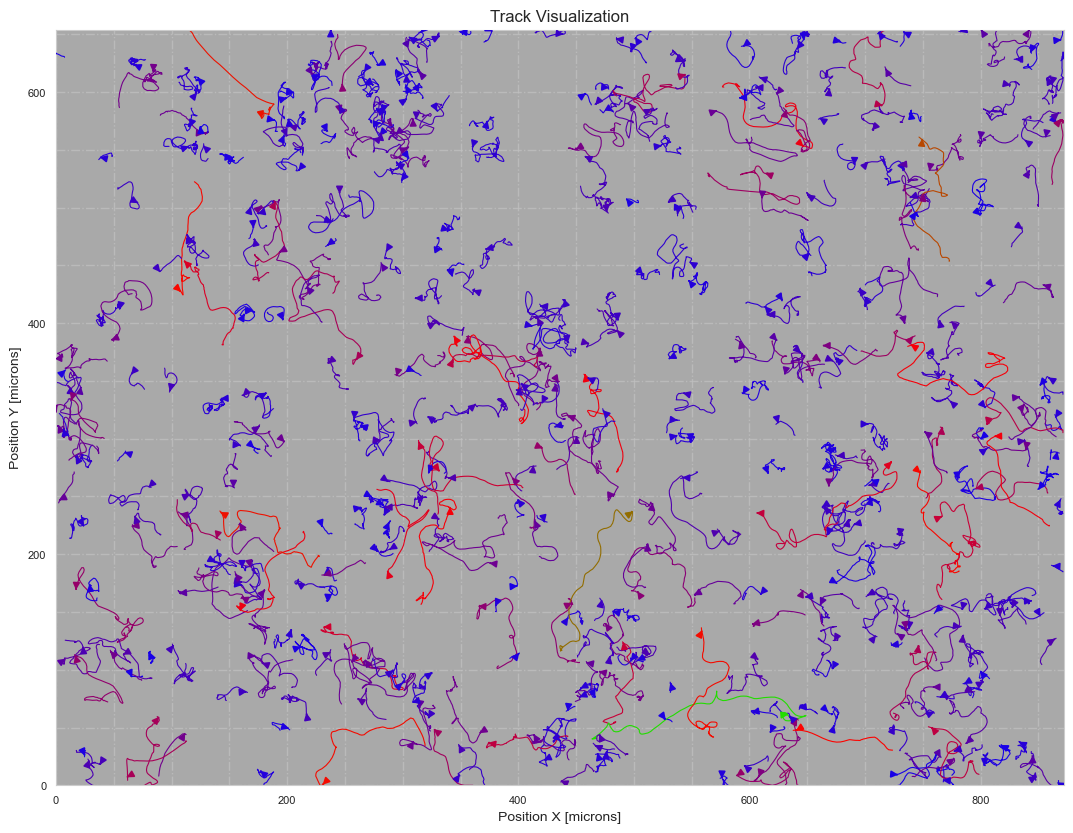

In [ ]:
# Track_stats = pd.read_csv(r'C:\Users\modri\Desktop\python\Peregrin\Peregrin\test data\Track_stats.csv') # Read the Track_statistics .csv file
# Spot_stats = pd.read_csv(r'C:\Users\modri\Desktop\python\Peregrin\Peregrin\test data\Spot stats.csv') # Read the Spot_statistics .csv file

import plotly.graph_objects as go

def get_colormap(c_mode):
    if c_mode == 'greyscale':
        return plt.cm.gist_yarg
    elif c_mode == 'jet':
        return plt.cm.jet
    elif c_mode == 'brg':
        return plt.cm.brg
    elif c_mode == 'hot':
        return plt.cm.hot
    elif c_mode == 'gnuplot':
        return plt.cm.gnuplot
    elif c_mode == 'viridis':
        return plt.cm.viridis
    elif c_mode == 'rainbow':
        return plt.cm.rainbow
    elif c_mode == 'turbo':
        return plt.cm.turbo
    elif c_mode == 'nipy_spectral':
        return plt.cm.nipy_spectral
    elif c_mode == 'gist_ncar':
        return plt.cm.gist_ncar
    else:
        return None
    

def generate_random_color():
    r = np.random.randint(0, 255)  # Random value for Red
    g = np.random.randint(0, 255)  # Random value for Green
    b = np.random.randint(0, 255)  # Random value for Blue
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)

def generate_random_grey():
    n = np.random.randint(0, 240)  # Random value for Grey
    return '#{:02x}{:02x}{:02x}'.format(n, n, n)



def _(Spots_df, Tracks_df, metric_dictionary: dict, condition='all', replicate='all', c_mode='random colors', only_one_color='black', lut_scaling_metric='NET_DISTANCE', let_me_look_at_these=[], backround='dark', grid=True, smoothing_index=6, lw=1, scatter=False, markers=basic_markers, I_just_wanna_be_normal=True, ):

    if 'level_0' in Tracks_df.columns:
        Tracks_df.drop(columns=['level_0'], inplace=True)
    
    Tracks_df.reset_index(drop=False, inplace=True)

    if condition == None or replicate == None:
        pass
    else:
        try:
            condition = int(condition)
        except ValueError or TypeError:
            pass
        try:
            replicate = int(replicate)
        except ValueError or TypeError:
            pass


    if condition == 'all':
        Spots_df = Spots_df.sort_values(by=['CONDITION', 'REPLICATE', 'TRACK_ID', 'POSITION_T'])
    elif condition != 'all' and replicate == 'all':
        Spots_df = Spots_df[Spots_df['CONDITION'] == condition].sort_values(by=['CONDITION', 'REPLICATE', 'TRACK_ID', 'POSITION_T'])
    elif condition != 'all' and replicate != 'all':
        Spots_df = Spots_df[(Spots_df['CONDITION'] == condition) & (Spots_df['REPLICATE'] == replicate)].sort_values(by=['CONDITION', 'REPLICATE', 'TRACK_ID', 'POSITION_T'])


    if backround =='light':
        grid_color = 'gainsboro'
        face_color = 'None'
        grid_alpha = 0.5
        if grid:
            grid_lines = '-.'
        else:
            grid_lines = 'None'

    elif backround == 'dark':
        grid_color = 'silver'
        face_color = 'darkgrey'
        grid_alpha = 0.75
        if grid:
            grid_lines = '-.'
        else:
            grid_lines = 'None'
    

    if c_mode in ['random colors', 'random greys', 'only-one']:
        colormap = None

        if c_mode in ['random colors']:
            track_colors = [generate_random_color() for _ in range(len(Tracks_df))]
        elif c_mode in ['random greys']:
            track_colors = [generate_random_grey() for _ in range(len(Tracks_df))]

        color_map_direct = dict(zip(Tracks_df['TRACK_ID'], track_colors))
        Tracks_df['COLOR'] = Tracks_df['TRACK_ID'].map(color_map_direct)

    else:
        colormap = get_colormap(c_mode)
        metric_min = Spots_df[lut_scaling_metric].min()
        metric_max = Spots_df[lut_scaling_metric].max()



    fig, ax = plt.subplots(figsize=(13, 10))

    # Set up the plot limits
    # Define the desired dimensions in microns
    microns_per_pixel = 0.7381885238402274 # for 10x lens
    x_min, x_max = 0, (1600 * microns_per_pixel**2)
    y_min, y_max = 0, (1200 * microns_per_pixel**2)

    ax.set_aspect('1', adjustable='box')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('Position X [microns]')
    ax.set_ylabel('Position Y [microns]')
    ax.set_title('Track Visualization', fontsize=12)
    ax.set_facecolor(face_color)
    ax.grid(True, which='both', axis='both', color=grid_color, linestyle=grid_lines, linewidth=1, alpha=grid_alpha)

    # Manually set the major tick locations and labels
    x_ticks_major = np.arange(x_min, x_max, 200)  # Adjust the step size as needed
    y_ticks_major = np.arange(y_min, y_max, 200)  # Adjust the step size as needed
    ax.set_xticks(x_ticks_major)
    ax.set_yticks(y_ticks_major)
    ax.set_xticklabels([f'{tick:.0f}' for tick in x_ticks_major])
    ax.set_yticklabels([f'{tick:.0f}' for tick in y_ticks_major])

    # Enable minor ticks and set their locations
    ax.minorticks_on()
    x_ticks_minor = np.arange(x_min, x_max, 50)  # Minor ticks every 50 microns
    y_ticks_minor = np.arange(y_min, y_max, 50)  # Minor ticks every 50 microns
    ax.set_xticks(x_ticks_minor, minor=True)
    ax.set_yticks(y_ticks_minor, minor=True)
    ax.tick_params(axis='both', which='major', labelsize=8)




    Spots_grouped = Spots_df.groupby(['CONDITION', 'REPLICATE', 'TRACK_ID'])
    Tracks_df.set_index(['CONDITION', 'REPLICATE', 'TRACK_ID'], inplace=True)

    fig = go.Figure()


    for (cond, repl, track), group_df in Spots_grouped:
        """
        - group_keys is a tuple like: ('Condition_A', 'Rep1', 'Track_001')
        - group_df is the actual dataframe for that group
        
        """

        track_row = Tracks_df.loc[(cond, repl, track)]

        if colormap is not None:
            # Normalize the metric for color mapping
            norm = plt.Normalize(metric_min, metric_max)

            color = colormap(norm(track_row[lut_scaling_metric]))
            group_df['COLOR'] = color if isinstance(color, str) else [mcolors.to_hex(color)] * len(group_df)

        elif c_mode in ['random colors', 'random greys']:
            group_df['COLOR'] = track_row['COLOR']
        elif c_mode == 'only-one':
            group_df['COLOR'] = only_one_color

        if smoothing_index > 1:
            group_df['POSITION_X'] = group_df['POSITION_X'].rolling(window=smoothing_index, min_periods=1).mean()
            group_df['POSITION_Y'] = group_df['POSITION_Y'].rolling(window=smoothing_index, min_periods=1).mean()
        else:
            group_df['POSITION_X'] = group_df['POSITION_X']
            group_df['POSITION_Y'] = group_df['POSITION_Y']

        ax.plot(group_df['POSITION_X'], group_df['POSITION_Y'], color=group_df['COLOR'].iloc[0], linewidth=lw)

        if len(group_df['POSITION_X']) > 1:
            # Use trigonometry to calculate the direction (dx, dy) from the angle
            dx = np.cos(track_row['MEAN_DIRECTION_RAD'])  # Change in x based on angle
            dy = np.sin(track_row['MEAN_DIRECTION_RAD'])  # Change in y based on angle
            
            # Create an arrow to indicate direction
            arrow = FancyArrowPatch(
                posA=(group_df['POSITION_X'].iloc[-2], group_df['POSITION_Y'].iloc[-2]),  # Start position (second-to-last point)
                posB=(group_df['POSITION_X'].iloc[-2] + dx, group_df['POSITION_Y'].iloc[-2] + dy),  # End position based on direction
                arrowstyle='-|>',  # Style of the arrow (you can adjust the style as needed)
                color=group_df['COLOR'].iloc[0],  # Set the color of the arrow
                mutation_scale=10,  # Scale the size of the arrow head (adjust this based on the plot scale)
                linewidth=1.2,  # Line width for the arrow
                zorder=30  # Ensure the arrow is drawn on top of the line
            )

            # Add the arrow to your plot (if you're using a `matplotlib` figure/axes)
            plt.gca().add_patch(arrow)


        hover_dict = {}

        for metric in let_me_look_at_these:
            hover_dict[metric_dictionary[metric]] = track_row[metric]
        
        hover_text = "<br>".join(f"{key}: {value}" for key, value in hover_dict.items())
        fig.add_trace(go.Scatter(
            x=group_df['POSITION_X'],
            y=group_df['POSITION_Y'],
            mode='lines',
            line=dict(color=group_df['COLOR'].iloc[0], width=0.3),
            name=f"Track {track}",
            hoverinfo='text',
            hovertext=hover_text,
        ))

        if scatter:
            if I_just_wanna_be_normal:
                fig.add_trace(go.Scatter(
                x=[group_df['POSITION_X'].iloc[-1]],
                y=[group_df['POSITION_Y'].iloc[-1]],
                marker=dict(
                    symbol='circle-open',
                    size=5,
                    color=group_df['COLOR'].iloc[0],
                ),
                showlegend=False,
                hoverinfo='skip'
            ))
            
            elif markers == basic_markers:
                marker = basic_markers
            elif markers == scaled_markers or markers == trains_markers:
                percentile_value = ((track_row['TRACK_LENGTH'] - min_track_length) / (max_track_length - min_track_length)) * 100
                marker = assign_marker(percentile_value, markers)
            else:
                marker = np.random.choice(markers)

                fig.add_trace(go.Scatter(
                    x=[group_df['POSITION_X'].iloc[-1]],
                    y=[group_df['POSITION_Y'].iloc[-1]],
                    mode='text',
                    text=marker,
                    textposition='middle center',
                    textfont=dict(size=14),
                    showlegend=False,
                    hoverinfo='skip'
                ))

    Tracks_df.reset_index(drop=False, inplace=True)

    fig.update_layout(
        xaxis_title='Position X [microns]',
        yaxis_title='Position Y [microns]',
        xaxis=dict(range=[x_min, x_max]),
        yaxis=dict(range=[y_min, y_max]),
        plot_bgcolor=face_color,
        showlegend=False,
        autosize=False,
        width=1600/5*3,  # Set the width of the plot
        height=1200/5*3,  # Set the height of the plot
        )

    fig.add_annotation(
        text="Track Visualization",
        xref="paper",
        yref="paper",
        x=0.5,
        y=1.15,
        showarrow=False,
        font=dict(size=16),
    )

    fig.update_xaxes(
        title_text="Position X [microns]",
        title_font=dict(size=14),
        tickvals=x_ticks_major,
        ticktext=[f'{tick:.0f}' for tick in x_ticks_major],
        gridcolor=grid_color,
        zerolinecolor=grid_color,
    )

    fig.update_yaxes(
        title_text="Position Y [microns]",
        title_font=dict(size=14),
        tickvals=y_ticks_major,
        ticktext=[f'{tick:.0f}' for tick in y_ticks_major],
        gridcolor=grid_color,
        zerolinecolor=grid_color,
    )

    fig.update_traces(line=dict(width=lw), selector=dict(mode='lines'))

    # fig.write_html(r'C:\Users\modri\Desktop\python\Peregrin\Peregrin\code files\cache_\visualizedd_tracks.html', auto_open=True)

    # Tracks_df.reset_index(drop=False, inplace=True)

    return plt.gcf(), fig
    
        
_(Spot_stats, Track_stats, metric_dictionary=dict_Track_metrics, condition=1, replicate='all', c_mode='brg', backround='dark', lut_scaling_metric='NET_DISTANCE', let_me_look_at_these=['TRACK_LENGTH', 'NET_DISTANCE', 'CONFINEMENT_RATIO', 'TRACK_POINTS', 'MEAN_DIRECTION_DEG'], lw=0.8, scatter=True, markers='just_be_normal')

# I just wanna be normal will be a checkbox, True by default.
# It will be used to determine the markers selection.
# If True, the user will be albe to select out of markers like full or empty circles, squares, diamonds and will be able to select hos own color or the matching color to the track.
# If False, the selection will be changed and the user will be able to select out of a list of emojis or a random emoji.



In [197]:
# # Track_stats.reset_index(drop=False, inplace=True)
# print(Track_stats.columns)

# def tracks_lut_map(df2, c_mode: str, lut_metric='NET_DISTANCE', metrics_dict=dict_Track_metrics):

#     lut_norm_df = df2[['TRACK_ID', lut_metric]].drop_duplicates()

#     # Normalize the NET_DISTANCE to a 0-1 range
#     lut_min = lut_norm_df[lut_metric].min()
#     lut_max = lut_norm_df[lut_metric].max()
#     norm = plt.Normalize(vmin=lut_min, vmax=lut_max)

#     if c_mode not in ['random colors', 'random greys', 'only-one-color']:
#         # Get the colormap based on the selected mode
#         colormap = get_colormap(c_mode)
    
#         # Add a colorbar to show the LUT map
#         sm = plt.cm.ScalarMappable(norm=norm, cmap=colormap)
#         sm.set_array([])
#         # Create a separate figure for the LUT map (colorbar)
#         fig_lut, ax_lut = plt.subplots(figsize=(2, 6))
#         ax_lut.axis('off')
#         cbar = fig_lut.colorbar(sm, ax=ax_lut, orientation='vertical', extend='both', shrink=0.85)
#         cbar.set_label(metrics_dict[lut_metric], fontsize=10)

#         plt.gcf()
    
#     else:
#         pass

# tracks_lut_map(Track_stats, c_mode='brg', lut_metric='NET_DISTANCE', metrics_dict=dict_Track_metrics)

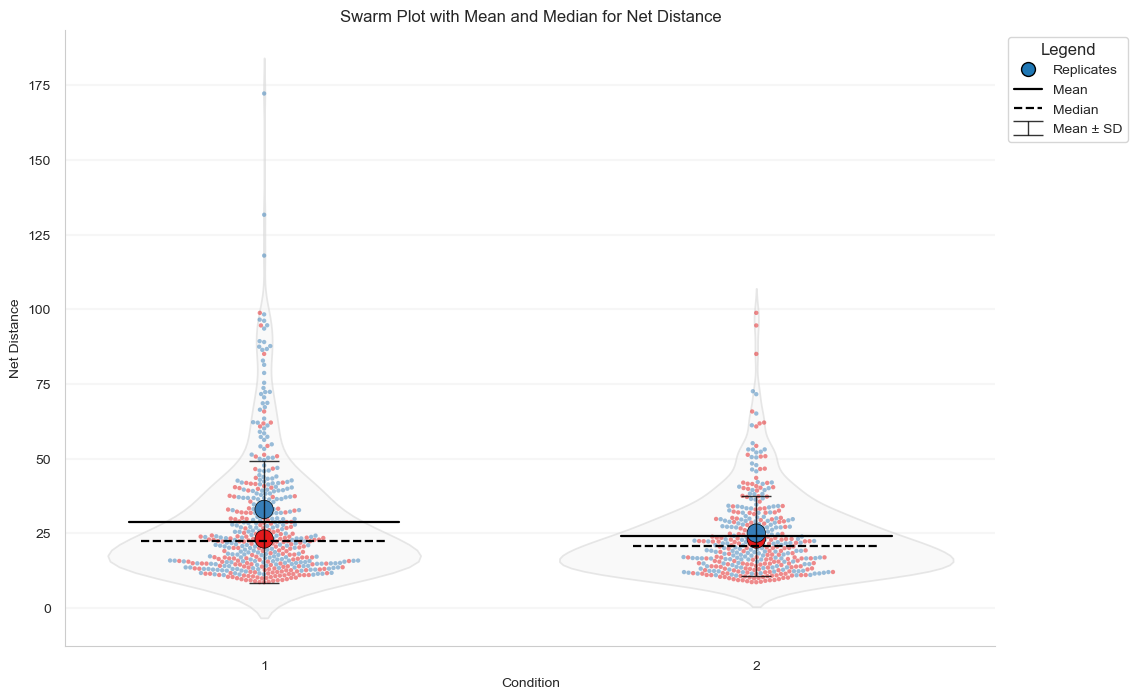

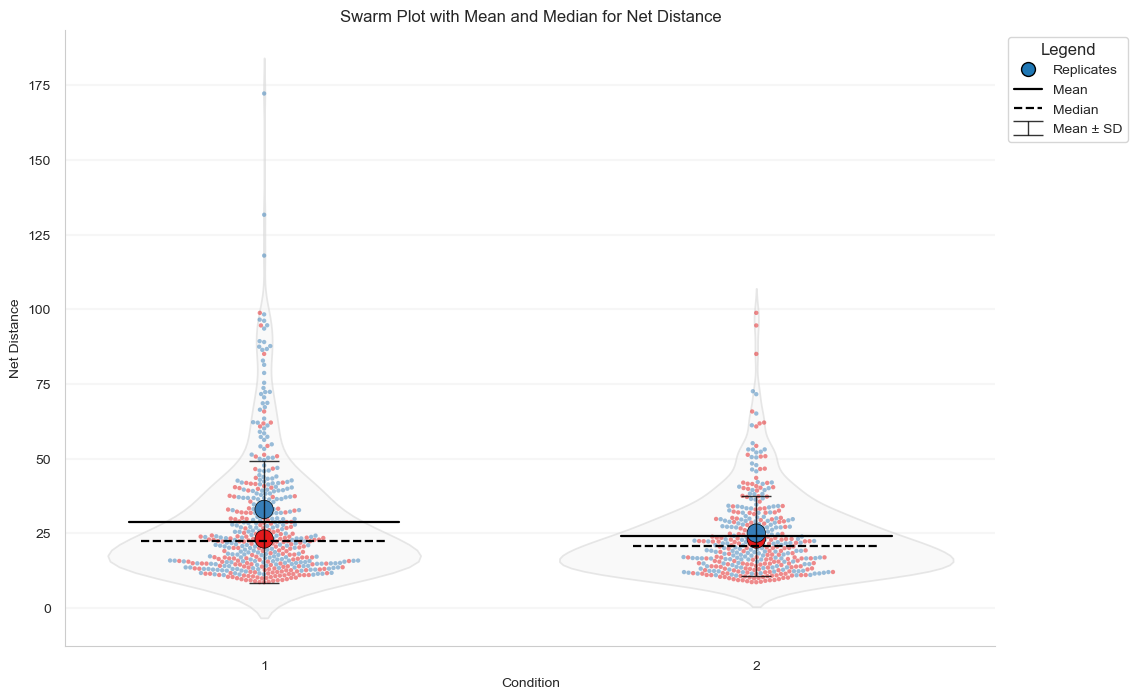

In [198]:
import matplotlib.lines as mlines

sns_palletes = ['deep', 'muted', 'bright', 'pastel', 'dark', 'colorblind', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20c']

def my_data_swarm_plot_with_mean_median(
        df,                                     
        metric, 
        Metric, 
        show_violin=True, 
        show_swarm=True, 
        show_mean=True, 
        show_median=True, 
        show_error_bars=True, 
        show_legend=True, 
        show_grid=True,
        open_spine=True,
        p_testing=False, 
        palette=sns_palletes[6], 
        ball_size=175, 
        ball_outline_color='black', 
        ball_outline_width=0.5, 
        ball_alpha=1, 
        swarm_size=3.15, 
        swarm_alpha=0.5,
        violin_fill_color='whitesmoke', 
        violin_edge_color='lightgrey', 
        violin_alpha=0.525, 
        mean_span=0.275, 
        median_span=0.25, 
        line_width=1.6,
        width=12,
        height=8,
        ):
    
    """
    Create a swarm plot with mean and median lines for each condition.


    """

    plt.figure(figsize=(width, height))
    
    # Ensure CONDITION is treated as categorical
    df['CONDITION'] = df['CONDITION'].astype(str)


    if show_swarm:
        sns.swarmplot(data=df, x='CONDITION', y=metric, hue='REPLICATE', palette=palette, size=swarm_size, dodge=False, alpha=swarm_alpha, legend=False, zorder=2)
    else:
        pass

    replicate_means = df.groupby(['CONDITION', 'REPLICATE'])[metric].mean().reset_index()
    sns.scatterplot(data=replicate_means, x='CONDITION', y=metric, hue='REPLICATE', palette=palette, edgecolor=ball_outline_color, s=ball_size, legend=False, alpha=ball_alpha, linewidth=ball_outline_width, zorder=3)

    if show_violin:
        sns.violinplot(data=df, x='CONDITION', y=metric, color=violin_fill_color, edgecolor=violin_edge_color, inner=None, alpha=violin_alpha, zorder=1)
    else:
        pass

    # Calculate mean and median for each condition
    condition_stats = df.groupby('CONDITION')[metric].agg(['mean', 'median']).reset_index()

    # Plot mean and median lines for each condition using seaborn functions
    for i, row in condition_stats.iterrows():
        x_center = i # Adjust x-coordinate to start at the correct condition position
        if show_mean:
            sns.lineplot(x=[x_center - mean_span, x_center + mean_span], y=[row['mean'], row['mean']], color='black', linestyle='-', linewidth=line_width, label='Mean' if i == 0 else "", zorder=4)
        else:
            pass
        if show_median:
            sns.lineplot(x=[x_center - median_span, x_center + median_span], y=[row['median'], row['median']], color='black', linestyle='--', linewidth=line_width, label='Median' if i == 0 else "", zorder=4)
        else:
            pass

    # Calculate mean, median, and standard deviation for each condition
    condition_stats = df.groupby('CONDITION')[metric].agg(['mean', 'median', 'std']).reset_index()

    if show_error_bars:
        # Plot error bars representing mean ± standard deviation for each condition
        for i, row in condition_stats.iterrows():
            x_center = i
            plt.errorbar(x_center, row['mean'], yerr=row['std'], fmt='None', color='black', alpha=0.8,
                        linewidth=1, capsize=11, zorder=5, label='Mean ± SD' if i == 0 else "")
    else:
        pass
    
    if p_testing:
        # P-test
        # Perform pairwise p-tests
        conditions = df['CONDITION'].unique()
        pairs = list(combinations(conditions, 2))
        y_max = df[metric].max()
        y_offset = (y_max * 0.1)  # Offset for p-value annotations
        for i, (cond1, cond2) in enumerate(pairs):
            data1 = df[df['CONDITION'] == cond1][metric]
            data2 = df[df['CONDITION'] == cond2][metric]
            stat, p_value = mannwhitneyu(data1, data2)
            
            # Annotate the plot with the p-value
            x1, x2 = conditions.tolist().index(cond1), conditions.tolist().index(cond2)
            y = y_max + y_offset * (i + 1)
            plt.plot([x1, x1, x2, x2], [y+4.5, y + y_offset / 2.5, y + y_offset / 2.5, y+1.5], lw=1, color='black')
            plt.text((x1 + x2) / 2, y + y_offset / 2, f'p = {round(p_value, 3):.3f}', ha='center', va='bottom', fontsize=10, color='black')
        else:
            pass
    
    if show_swarm & show_mean & show_median:
        title = f"Swarm Plot with Mean and Median for {Metric}"
    elif show_swarm & show_mean & show_median == False:
        title = f"Swarm Plot with Mean for {Metric}"
    elif show_swarm & show_mean == False & show_median:
        title = f"Swarm Plot with Median for {Metric}"
    elif show_swarm == False:
        if show_violin & show_mean & show_median:
            title = f"Violin Plot with Mean and Median for {Metric}"
        elif show_violin & show_mean & show_median == False:
            title = f"Violin Plot with Mean for {Metric}"
        elif show_violin & show_mean == False & show_median:
            title = f"Violin Plot with Median for {Metric}"
        

    plt.title(title)
    plt.xlabel("Condition")
    plt.ylabel(Metric)

    replicate_handle = mlines.Line2D([], [], marker='o', color='w',
                                     markerfacecolor=sns.color_palette('tab10')[0],
                                     markeredgecolor='black', markersize=10,
                                     label='Replicates')

    # Get current handles and labels (from Mean, Median, and Error Bars)
    handles, labels = plt.gca().get_legend_handles_labels()
    # Append the custom replicates handle
    handles.insert(0, replicate_handle)
    labels.insert(0, 'Replicates')
    
    plt.legend(handles=handles, labels=labels,
               title='Legend', title_fontsize='12', fontsize='10',
               loc='upper right', bbox_to_anchor=(1.15, 1), frameon=True)
    
    # sns.set_theme()

    sns.despine(top=open_spine, right=open_spine, bottom=False, left=False)
    plt.tick_params(axis='both', which='major', length=7, width=1.5, direction='out', color='black')
    # plt.minorticks_on()
    # plt.tick_params(axis='y', which='minor', length=5)

    plt.grid(show_grid, axis='y', color='lightgrey', linewidth=1.5, alpha=0.2)


    if show_legend:
        pass
    else:
        plt.legend().remove()

    return plt.gcf()

# Example usage:
my_data_swarm_plot_with_mean_median(Track_stats, 'NET_DISTANCE', dict_Metrics['NET_DISTANCE'], show_legend=True, show_grid=True, open_spine=True)


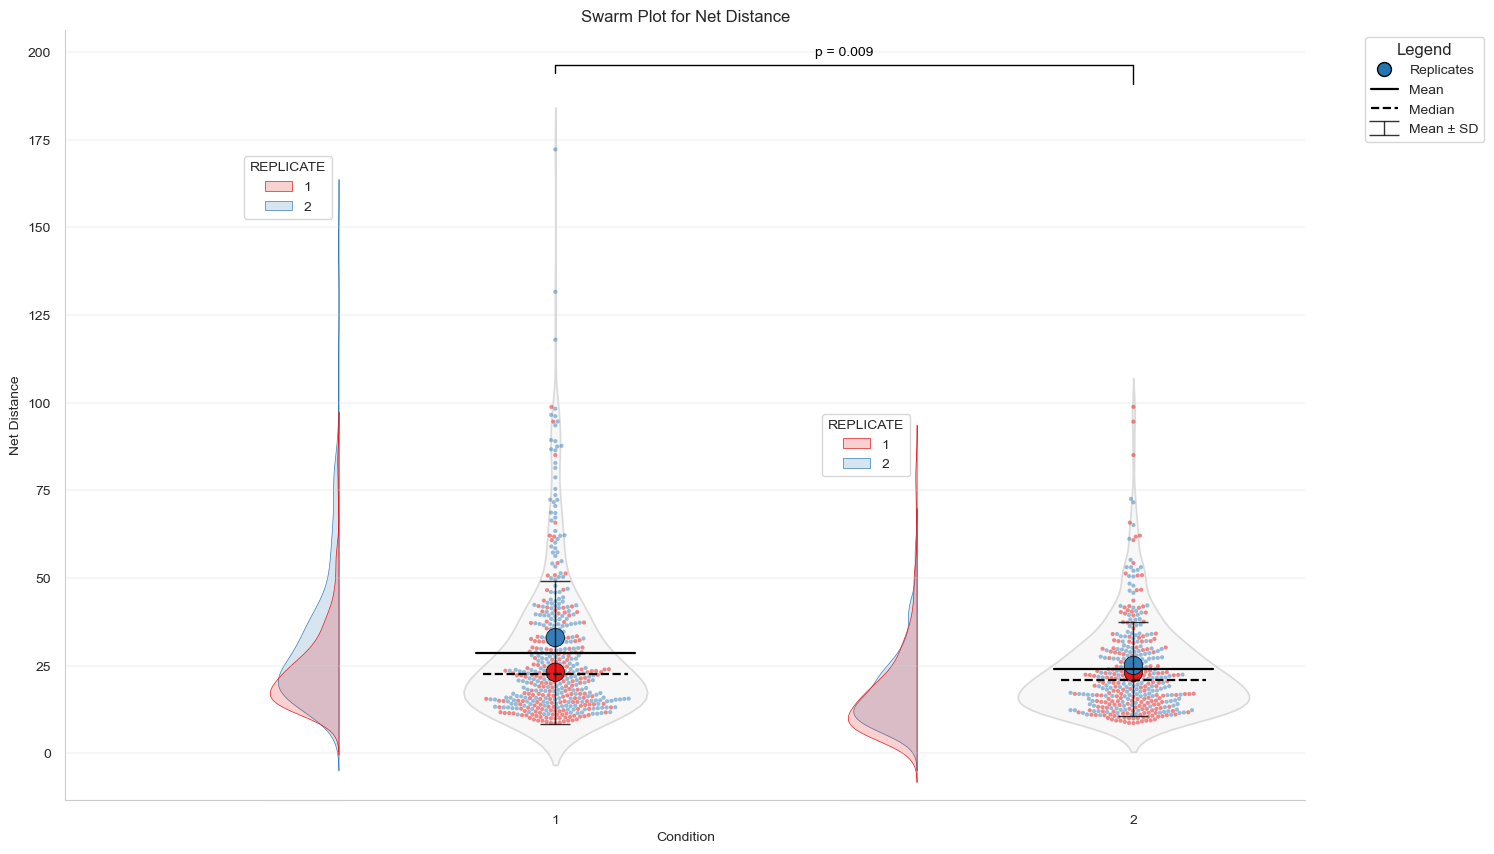

In [199]:
sns_palletes = ['deep', 'muted', 'bright', 'pastel', 'dark', 'colorblind', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20c']



def my_data_swarm_plot_with_mean_median(
        df,                                     
        metric, 
        Metric, 
        show_violin=True, 
        show_swarm=True, 
        show_mean=True, 
        show_median=True, 
        show_error_bars=True, 
        show_legend=True, 
        show_grid=True,
        open_spine=True,
        p_testing=False, 
        palette=sns_palletes[6], 
        ball_size=175, 
        ball_outline_color='black', 
        ball_outline_width=0.5, 
        ball_alpha=1, 
        swarm_size=3, 
        swarm_alpha=0.5,
        violin_fill_color='whitesmoke', 
        violin_edge_color='lightgrey', 
        violin_alpha=0.8, 
        mean_span=0.275, 
        median_span=0.25, 
        line_width=1.6,
        width=16,
        height=10,
        show_kde=True,
        kde_inset_width=0.25,
        ):
        
    plt.figure(figsize=(width, height))
    
    df['CONDITION'] = df['CONDITION'].astype(str)
    conditions = df['CONDITION'].unique()
    
    if show_kde:


        spaced_conditions = []

        for i, condition in enumerate(conditions):
            spaced_conditions.append(condition)
            if i < len(conditions) - 1:
                # Add spacer condition after each real condition except the last one
                spaced_conditions.append(f"spacer_{i+1}")

        spaced_conditions.insert(0, 'spacer_0')  # Add a spacer at the beginning

        # Assign this new order to CONDITION as a categorical variable
        df['CONDITION'] = pd.Categorical(df['CONDITION'], categories=spaced_conditions, ordered=True)
        
        # Filter out the spacer rows so they don't get plotted (just provide spacing)
        plot_df = df
        
        
        # Swarmplot (with spacing between categories)
        if show_swarm:
            sns.swarmplot(
                data=plot_df, x='CONDITION', y=metric,
                hue='REPLICATE', palette=palette,
                size=swarm_size, dodge=False, alpha=swarm_alpha,
                legend=False, zorder=3,
                order=spaced_conditions
            )
        
        # Violinplot (same idea, exclude spacers)
        if show_violin:
            sns.violinplot(
                data=plot_df, x='CONDITION', y=metric,
                color=violin_fill_color, edgecolor=violin_edge_color,
                inner=None, alpha=violin_alpha, zorder=2,
                order=spaced_conditions
            )
        
        # Scatterplot of replicate means (use same condition spacing)
        replicate_means = plot_df.groupby(['CONDITION', 'REPLICATE'])[metric].mean().reset_index()
        

        sns.scatterplot(
            data=replicate_means, x='CONDITION', y=metric,
            hue='REPLICATE', palette=palette,
            edgecolor=ball_outline_color, s=ball_size, legend=False,
            alpha=ball_alpha, linewidth=ball_outline_width, zorder=4
        )
        

        cond_num_list = list(range(len(conditions)*2))  

        # # Add means and medians as lines (with proper spacing)
        condition_stats = df.groupby('CONDITION')[metric].agg(['mean', 'median']).reset_index()
        # Add error bars for the standard deviation
        condition_stats_std = df.groupby('CONDITION')[metric].agg(['mean', 'std']).reset_index()

        for cond in cond_num_list:
            x_center = cond_num_list[cond]  # Get the x position for the condition
            if show_mean:
                sns.lineplot(
                    x=[x_center - mean_span, x_center + mean_span],
                    y=[condition_stats['mean'].iloc[cond], condition_stats['mean'].iloc[cond]],
                    color='black', linestyle='-', linewidth=line_width,
                    label='Mean' if cond == 0 else "", zorder=5
                    )
            if show_median:
                sns.lineplot(
                    x=[x_center - median_span, x_center + median_span],
                    y=[condition_stats['median'].iloc[cond], condition_stats['median'].iloc[cond]],
                    color='black', linestyle='--', linewidth=line_width,
                    label='Median' if cond == 0 else "", zorder=5
                    )

            # x_center = plot_df['x_pos'].iloc[i]  # Get the x position for the condition
            if show_error_bars:
                plt.errorbar(
                    x_center, condition_stats_std['mean'].iloc[cond], yerr=condition_stats_std['std'].iloc[cond], fmt='None',
                    color='black', alpha=0.8,
                    linewidth=1, capsize=11, zorder=5, label='Mean ± SD' if cond == 0 else "",
                    )
                
        # --- P-testing using combinations of real conditions (compare every pair) ---
        # Extract real conditions (those that do not start with "spacer")
        real_conditions = [cond for cond in spaced_conditions if not cond.startswith('spacer')]
        # Build a mapping from condition to its x-axis position based on spaced_conditions
        pos_mapping = {cat: idx for idx, cat in enumerate(spaced_conditions)}
        
        if p_testing:
            for i, (cond1, cond2) in enumerate(combinations(real_conditions, 2)):
                data1 = df[df['CONDITION'] == cond1][metric]
                data2 = df[df['CONDITION'] == cond2][metric]
                stat, p_value = mannwhitneyu(data1, data2)
                x1, x2 = pos_mapping[cond1], pos_mapping[cond2]
                y_max = df[metric].max()
                y_offset = y_max * 0.1
                y = y_max + y_offset * (i + 1)
                plt.plot([x1, x1, x2, x2],
                        [y+4.5, y + y_offset / 2.5, y + y_offset / 2.5, y+1.5],
                        lw=1, color='black')
                plt.text((x1 + x2) / 2, y + y_offset / 2,
                        f'p = {round(p_value, 3):.3f}', ha='center', va='bottom', 
                        fontsize=10, color='black')
        



        bitch = list(range(-1, len(conditions)*2))
        for i in bitch:
            x_val = bitch[i]
            sns.lineplot(
                x=x_val-0.5,
                y=[condition_stats['median'].iloc[i]],
                color='none', linewidth=0,
                label="", zorder=0
                )
            




        # KDE insets for each condition
        # sns.set_style("whitegrid", {"axes.facecolor": "none"})
        ax = plt.gca()
        y_ax_min, y_ax_max = ax.get_ylim()
        
        
        for cond in cond_num_list[::2]:
            group_df = plot_df[plot_df['CONDITION'] == conditions[cond // 2]]  # Get the data for the condition
            y_max = group_df[metric].max()

            # clip=(y_min, y_max)

            # inset_height = y_ax_max * (y_max/y_ax_max)  + y_ax_max * (2 / (y_ax_max - y_max))
            inset_height = y_ax_max * (y_max/y_ax_max) + abs(y_ax_min)
            # inset_height = y_ax_max

            x_val = cond_num_list[cond]  # Get the x position for the condition
            offset_x = 0
            inset_y = y_ax_min   # Adjust inset y position based on the condition
            # inset_y = y_min

            inset_ax = ax.inset_axes([x_val - offset_x, inset_y, kde_inset_width, inset_height], 
                                    transform=ax.transData, zorder=0, clip_on=True)
            
            sns.kdeplot(
                data=group_df,
                y=metric,
                hue='REPLICATE',
                fill=True,
                alpha=0.2,
                lw=0.5,
                palette=palette,
                ax=inset_ax,
                legend=True,
                zorder=0,
                clip=(y_ax_min, y_ax_max)
            )
            inset_ax.invert_xaxis()
            inset_ax.set_xticks([])
            inset_ax.set_yticks([])
            inset_ax.set_xlabel('')
            inset_ax.set_ylabel('')
            sns.despine(ax=inset_ax, left=True, bottom=False, top=True, right=True)


        # Title and labels
        title = f"Swarm Plot for {Metric}"
        plt.title(title)
        plt.xlabel("Condition")
        plt.ylabel(Metric)

        # Add a legend
        replicate_handle = mlines.Line2D([], [], marker='o', color='w', markerfacecolor=sns.color_palette('tab10')[0], markeredgecolor='black', markersize=10, label='Replicates')
        handles, labels = plt.gca().get_legend_handles_labels()
        handles.insert(0, replicate_handle)
        labels.insert(0, 'Replicates')
        
        if show_legend:
            plt.legend(handles=handles, labels=labels, title='Legend', title_fontsize='12', fontsize='10', loc='upper right', bbox_to_anchor=(1.15, 1), frameon=True)
        
        sns.despine(top=open_spine, right=open_spine, bottom=False, left=False)
        plt.tick_params(axis='both', which='major', length=7, width=1.5, direction='out', color='black')
        plt.grid(show_grid, axis='y', color='lightgrey', linewidth=1.5, alpha=0.2)

        plt.xticks(
            ticks=range(len(spaced_conditions)),
            labels=[lbl if not lbl.startswith("spacer") else "" for lbl in spaced_conditions]
            )
        
        plt.yticks(
            # minor=True,
            ticks=np.arange(0, y_ax_max, step=25),
        )







    elif show_kde == False:

        if show_swarm:
            sns.swarmplot(data=df, x='CONDITION', y=metric, hue='REPLICATE', palette=palette, size=swarm_size, dodge=False, alpha=swarm_alpha, legend=False, zorder=2)
        else:
            pass

        replicate_means = df.groupby(['CONDITION', 'REPLICATE'])[metric].mean().reset_index()
        sns.scatterplot(data=replicate_means, x='CONDITION', y=metric, hue='REPLICATE', palette=palette, edgecolor=ball_outline_color, s=ball_size, legend=False, alpha=ball_alpha, linewidth=ball_outline_width, zorder=3)

        if show_violin:
            sns.violinplot(data=df, x='CONDITION', y=metric, color=violin_fill_color, edgecolor=violin_edge_color, inner=None, alpha=violin_alpha, zorder=1)
        else:
            pass

        # Calculate mean and median for each condition
        condition_stats = df.groupby('CONDITION')[metric].agg(['mean', 'median']).reset_index()

        # Plot mean and median lines for each condition using seaborn functions
        for i, row in condition_stats.iterrows():
            x_center = i # Adjust x-coordinate to start at the correct condition position
            if show_mean:
                sns.lineplot(x=[x_center - mean_span, x_center + mean_span], y=[row['mean'], row['mean']], color='black', linestyle='-', linewidth=line_width, label='Mean' if i == 0 else "", zorder=4)
            else:
                pass
            if show_median:
                sns.lineplot(x=[x_center - median_span, x_center + median_span], y=[row['median'], row['median']], color='black', linestyle='--', linewidth=line_width, label='Median' if i == 0 else "", zorder=4)
            else:
                pass

        # Calculate mean, median, and standard deviation for each condition
        condition_stats = df.groupby('CONDITION')[metric].agg(['mean', 'median', 'std']).reset_index()

        if show_error_bars:
            # Plot error bars representing mean ± standard deviation for each condition
            for i, row in condition_stats.iterrows():
                x_center = i
                plt.errorbar(x_center, row['mean'], yerr=row['std'], fmt='None', color='black', alpha=0.8,
                            linewidth=1, capsize=11, zorder=5, label='Mean ± SD' if i == 0 else "")
        else:
            pass
        
        if p_testing:
            # P-test
            # Perform pairwise p-tests
            conditions = df['CONDITION'].unique()
            pairs = list(combinations(conditions, 2))
            y_max = df[metric].max()
            y_offset = (y_max * 0.1)  # Offset for p-value annotations
            for i, (cond1, cond2) in enumerate(pairs):
                data1 = df[df['CONDITION'] == cond1][metric]
                data2 = df[df['CONDITION'] == cond2][metric]
                stat, p_value = mannwhitneyu(data1, data2)
                
                # Annotate the plot with the p-value
                x1, x2 = conditions.tolist().index(cond1), conditions.tolist().index(cond2)
                y = y_max + y_offset * (i + 1)
                plt.plot([x1, x1, x2, x2], [y+4.5, y + y_offset / 2.5, y + y_offset / 2.5, y+1.5], lw=1, color='black')
                plt.text((x1 + x2) / 2, y + y_offset / 2, f'p = {round(p_value, 3):.3f}', ha='center', va='bottom', fontsize=10, color='black')
            else:
                pass
        
        if show_swarm & show_mean & show_median:
            title = f"Swarm Plot with Mean and Median for {Metric}"
        elif show_swarm & show_mean & show_median == False:
            title = f"Swarm Plot with Mean for {Metric}"
        elif show_swarm & show_mean == False & show_median:
            title = f"Swarm Plot with Median for {Metric}"
        elif show_swarm == False:
            if show_violin & show_mean & show_median:
                title = f"Violin Plot with Mean and Median for {Metric}"
            elif show_violin & show_mean & show_median == False:
                title = f"Violin Plot with Mean for {Metric}"
            elif show_violin & show_mean == False & show_median:
                title = f"Violin Plot with Median for {Metric}"
            

        plt.title(title)
        plt.xlabel("Condition")
        plt.ylabel(Metric)

        replicate_handle = mlines.Line2D([], [], marker='o', color='w',
                                        markerfacecolor=sns.color_palette('tab10')[0],
                                        markeredgecolor='black', markersize=10,
                                        label='Replicates')

        # Get current handles and labels (from Mean, Median, and Error Bars)
        handles, labels = plt.gca().get_legend_handles_labels()
        # Append the custom replicates handle
        handles.insert(0, replicate_handle)
        labels.insert(0, 'Replicates')
        
        plt.legend(handles=handles, labels=labels,
                title='Legend', title_fontsize='12', fontsize='10',
                loc='upper right', bbox_to_anchor=(1.15, 1), frameon=True)
        
        # sns.set_theme()

        sns.despine(top=open_spine, right=open_spine, bottom=False, left=False)
        plt.tick_params(axis='both', which='major', length=7, width=1.5, direction='out', color='black')
        # plt.minorticks_on()
        # plt.tick_params(axis='y', which='minor', length=5)

        plt.grid(show_grid, axis='y', color='lightgrey', linewidth=1.5, alpha=0.2)


    if show_legend:
        pass
    else:
        plt.legend().remove()


    

    return plt.gcf()


# Example usage:
fig = my_data_swarm_plot_with_mean_median(Track_stats, 'NET_DISTANCE', dict_Metrics['NET_DISTANCE'], show_legend=True, show_grid=True, open_spine=True, show_swarm=True, show_violin=True, show_mean=True, show_median=True, show_error_bars=True, p_testing=True, show_kde=True)
# display(fig)  # Display the figure in a Jupyter notebook or similar environment



None

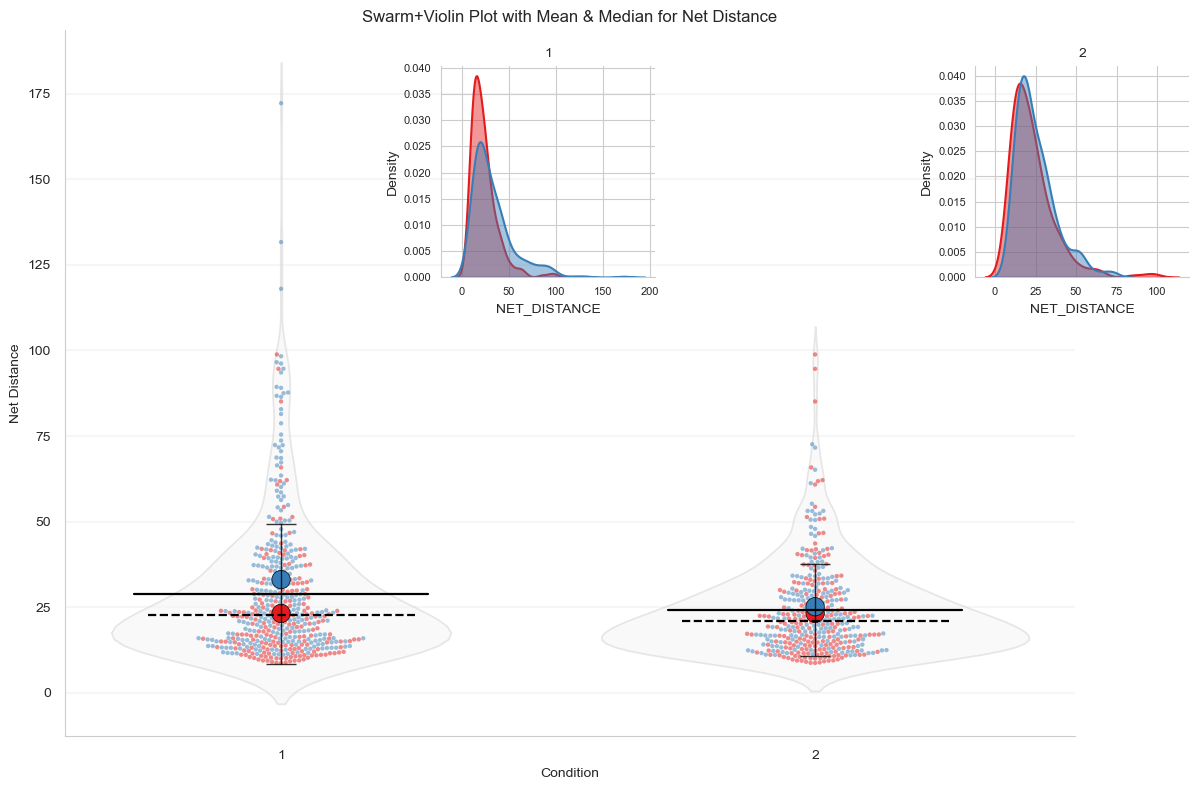

In [200]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from scipy.stats import mannwhitneyu
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Use any palette with enough colors; here is an example palette list:
sns_palletes = ['deep', 'muted', 'bright', 'pastel', 
                'dark', 'colorblind', 'Set1', 'Set2', 'Set3',
                'tab10', 'tab20', 'tab20c']

def my_data_swarm_plot_with_mean_median(
        df,                                     
        metric, 
        Metric, 
        show_violin=True, 
        show_swarm=True, 
        show_mean=True, 
        show_median=True, 
        show_error_bars=True, 
        show_legend=True, 
        show_grid=True,
        open_spine=True,
        p_testing=False, 
        palette=sns_palletes[6], 
        ball_size=175, 
        ball_outline_color='black', 
        ball_outline_width=0.5, 
        ball_alpha=1, 
        swarm_size=3.15, 
        swarm_alpha=0.5,
        violin_fill_color='whitesmoke', 
        violin_edge_color='lightgrey', 
        violin_alpha=0.525, 
        mean_span=0.275, 
        median_span=0.25, 
        line_width=1.6,
        width=12,
        height=8,
    ):
    """
    This function creates a composite figure where:
      - The main panel (ax_main) shows the swarm+violin plot with mean/median markers.
      - For each condition, an inset axis is added (within ax_main) displaying
        the kernel density estimate (KDE) for the replicate data for that condition.
    
    The x-axis of the main panel still shows the conditions.
    
    (Adjust the inset axes positions and sizes as needed.)
    """
    # Ensure CONDITION is treated as a categorical variable
    df['CONDITION'] = df['CONDITION'].astype(str)
    conditions = sorted(df['CONDITION'].unique())

    # Create the main figure and axis
    fig, ax_main = plt.subplots(figsize=(width, height))
    
    
    # ---------------------------------------------------------------------
    # Create the main swarm + violin plot
    # ---------------------------------------------------------------------
    if show_violin:
        sns.violinplot(
            data=df, x='CONDITION', y=metric, 
            color=violin_fill_color, edgecolor=violin_edge_color, 
            inner=None, alpha=violin_alpha, zorder=1, ax=ax_main
        )
    
    if show_swarm:
        sns.swarmplot(
            data=df, x='CONDITION', y=metric, 
            hue='REPLICATE', palette=palette, 
            size=swarm_size, dodge=False, alpha=swarm_alpha, 
            legend=False, zorder=2, ax=ax_main
        )
    
    # Plot replicate means as large markers
    replicate_means = df.groupby(['CONDITION', 'REPLICATE'])[metric].mean().reset_index()
    sns.scatterplot(
        data=replicate_means, x='CONDITION', y=metric,
        hue='REPLICATE', palette=palette, 
        edgecolor=ball_outline_color, s=ball_size,
        legend=False, alpha=ball_alpha, linewidth=ball_outline_width,
        zorder=3, ax=ax_main
    )
    
    # Calculate condition-level stats to draw mean and median lines
    condition_stats = df.groupby('CONDITION')[metric].agg(['mean', 'median', 'std']).reset_index()
    
    for i, row in condition_stats.iterrows():
        # i is the numeric position corresponding to the condition in the main axis.
        if show_mean:
            ax_main.plot([i - mean_span, i + mean_span],
                         [row['mean'], row['mean']],
                         color='black', linestyle='-', linewidth=line_width,
                         label='Mean' if i == 0 else "", zorder=4)
        if show_median:
            ax_main.plot([i - median_span, i + median_span],
                         [row['median'], row['median']],
                         color='black', linestyle='--', linewidth=line_width,
                         label='Median' if i == 0 else "", zorder=4)
    
    if show_error_bars:
        # Plot error bars representing mean ± standard deviation
        for i, row in condition_stats.iterrows():
            ax_main.errorbar(
                i, row['mean'], yerr=row['std'], fmt='None', 
                color='black', alpha=0.8, linewidth=1, capsize=11, zorder=5,
                label='Mean ± SD' if i == 0 else ""
            )
    
    if p_testing:
        # Example pairwise testing (Mann-Whitney U)
        pairs = list(combinations(conditions, 2))
        y_max = df[metric].max()
        y_offset = (y_max * 0.1)
        for j, (cond1, cond2) in enumerate(pairs):
            data1 = df[df['CONDITION'] == cond1][metric]
            data2 = df[df['CONDITION'] == cond2][metric]
            stat, p_value = mannwhitneyu(data1, data2)
            x1 = conditions.index(cond1)
            x2 = conditions.index(cond2)
            y = y_max + y_offset * (j + 1)
            ax_main.plot([x1, x1, x2, x2],
                         [y+4.5, y + y_offset/2.5, y + y_offset/2.5, y+1.5],
                         lw=1, color='black')
            ax_main.text((x1 + x2)/2, y + y_offset/2,
                         f'p = {round(p_value, 3):.3f}', ha='center', va='bottom',
                         fontsize=10, color='black')
    
    # Set titles and labels for the main plot
    ax_main.set_title(f"Swarm+Violin Plot with Mean & Median for {Metric}")
    ax_main.set_xlabel("Condition")
    ax_main.set_ylabel(Metric)
    
    # Customize ticks and grid on the main axis
    sns.despine(ax=ax_main, top=open_spine, right=open_spine)
    ax_main.tick_params(axis='both', which='major', length=7, width=1.5, direction='out', color='black')
    ax_main.grid(show_grid, axis='y', color='lightgrey', linewidth=1.5, alpha=0.2)
    
    # ---------------------------------------------------------------------
    # For each condition, add an inset axis that plots the kernel density
    # distribution (for that condition's replicate data).
    # Adjust the inset position and size below as desired.
    # ---------------------------------------------------------------------
    # Grab the y-axis limits from the main plot (or define your own)
    y_min, y_max = ax_main.get_ylim()
    # You may wish to adjust these inset parameters:
    inset_width = 0.4   # in data coordinates; change as needed
    inset_height = (y_max - y_min) * 0.3  # 30% of the y-range
    
    for i, cond in enumerate(conditions):
        data_cond = df[df['CONDITION'] == cond]
        
        # Set the inset's lower left corner in data coordinates.
        # Here we place it slightly to the right of the condition's tick.
        # (i + offset_x, offset_y). Adjust the offset values as needed.
        offset_x = 0.3
        inset_x = i + offset_x
        
        # For vertical position, one simple strategy is to place the inset
        # at the top of the main y-axis. You might alternatively calculate a
        # position based on the distribution’s central tendency.
        inset_y = y_max - inset_height - 0.05*(y_max-y_min)
        
        # Create the inset axes; note the transform is set so that the [inset_x, inset_y]
        # is interpreted in the main axis data coordinate space.
        ax_inset = ax_main.inset_axes([inset_x, inset_y, inset_width, inset_height],
                                      transform=ax_main.transData)
        
        # Plot the KDE for each replicate for this condition.
        # (You can adjust hue, alpha, fill, etc. as desired.)
        replicate_ids = sorted(data_cond['REPLICATE'].unique())
        colors = sns.color_palette(palette, n_colors=len(replicate_ids))
        for j, rep in enumerate(replicate_ids):
            subset = data_cond[data_cond['REPLICATE'] == rep]
            # Plot a KDE on the inset axis.
            sns.kdeplot(
                data=subset, x=metric, fill=True, 
                alpha=0.45, color=colors[j], ax=ax_inset,
                linewidth=1.5
            )
        
        # Optionally, set a title (or label) in the inset to indicate the condition
        ax_inset.set_title(f"{cond}", fontsize=10)
        # Tidy up the inset axes: smaller ticks, no legend, etc.
        ax_inset.tick_params(labelsize=8)
        # Optionally, remove the inset spines for a cleaner look:
        sns.despine(ax=ax_inset, top=True, right=True)
    
    # Create a custom legend (or merge with existing) if desired.
    # (Below is an example that adds a replicates marker legend.)
    import matplotlib.lines as mlines
    replicate_handle = mlines.Line2D([], [], marker='o', color='w',
                                     markerfacecolor=sns.color_palette('tab10')[0],
                                     markeredgecolor='black', markersize=10,
                                     label='Replicates')
    handles, labels = ax_main.get_legend_handles_labels()
    handles.insert(0, replicate_handle)
    labels.insert(0, 'Replicates')
    
    if show_legend:
        ax_main.legend(handles=handles, labels=labels,
                       title='Legend', title_fontsize='12', fontsize='10',
                       loc='upper right', bbox_to_anchor=(1.15, 1), frameon=True)
    else:
        ax_main.legend().remove()
    
    return fig.tight_layout()

# -----------------------------------------------------------------------------
# Example usage:
# Make sure that your DataFrame (here assumed as "Track_stats") contains at least
# the columns: 'CONDITION', 'REPLICATE', and the metric (e.g., 'NET_DISTANCE').
#
fig = my_data_swarm_plot_with_mean_median(
    Track_stats, 
    'NET_DISTANCE', 
    dict_Metrics['NET_DISTANCE'], 
    show_legend=False, show_grid=True, open_spine=True
)

display(fig)


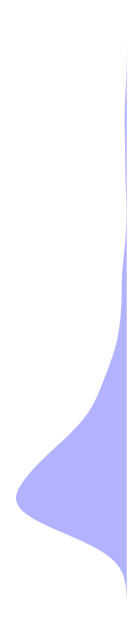

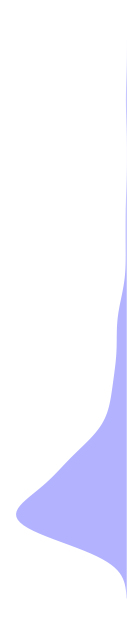

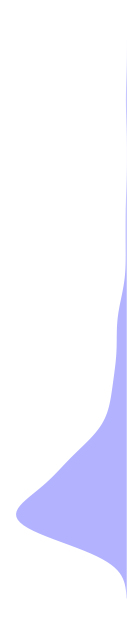

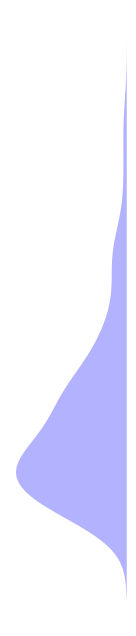

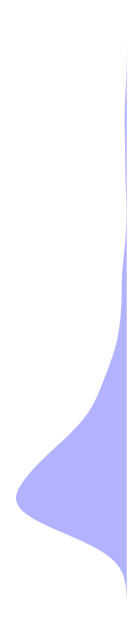

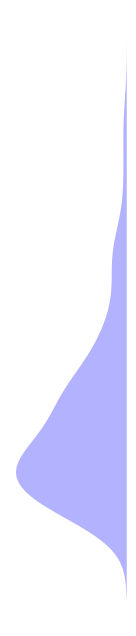

In [201]:
Track_stats = pd.read_csv(r'C:\Users\modri\Desktop\python\Peregrin\Peregrin\test data\Track_stats.csv')

def kdeplotting():

    grouped_tracks = Track_stats.groupby(['CONDITION', 'REPLICATE'])


    for cond, group_df in grouped_tracks:
        # Create a new figure and axis for each condition
        fig, ax = plt.subplots(figsize=(1.5, 8))
        
        # Plot the KDE vertically using y='NET_DISTANCE'
        sns.kdeplot(
            data=group_df,
            y='NET_DISTANCE',        # Separate densities by replicate
            fill=True,
            alpha=0.3,
            label=cond,
            lw=0,
            color='blue',
            ax=ax
        )
        
        # Remove the axis ticks and labels
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')

        ax.invert_xaxis()
        
        # Remo
        # ve all spines
        sns.despine(ax=ax, left=True, bottom=True, right=True, top=True)
        
        # Optionally, remove the legend if it's not needed
        ax.legend().remove()
        
        plt.show()

# Call the function
kdeplotting()

        

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go

def interactive_stripplot(
    df: pd.DataFrame, 
    metric: str, 
    Metric: str, 
    let_me_look_at_these: list, 
    palette='Set1', 
    width=800, 
    height=600, 
    slope=False,
    jitter_outline_width=0.3,
    violin_edge_color='dimgrey',
    lowband=0.25,
    highband=0.75,
    see_outliars: bool = False
):
    """
    Create an interactive strip plot with aggregated violin plots using Plotly.
    
    For each CONDITION:
      - A grey aggregated violin plot is drawn with custom hover displaying 
        min, median, mean and max values.
      - Scatter (jitter) points are drawn per REPLICATE. By default these points 
        are colored by replicate; however, if see_outliars is True, non‐outlying 
        points are painted grey and only outliers retain their replicate colors.
      - A solid horizontal line is added at the condition mean, along with a dashed line for the median.
      - An error bar with cap is added at the condition mean representing one standard deviation.
      - A diamond marker is added at each (CONDITION, REPLICATE) group representing that group’s mean.
    
    Parameters:
        df (pd.DataFrame): Input data frame.
        metric (str): Column name for the y-axis metric.
        Metric (str): Display name for the y-axis metric.
        let_me_look_at_these (list): Additional columns to include in scatter hover text.
        palette (str): Seaborn color palette for replicates.
        width (int): Plot width.
        height (int): Plot height.
        slope (bool): Whether to adjust jitter based on density and metric values.
        jitter_outline_width (float): Outline width for jittered markers.
        violin_edge_color (str): Color for violin borders.
        see_outliars (bool): When True, paints non-outlying jitter points grey and outliers with their replicate colors.
    
    Returns:
        go.Figure: The resulting Plotly figure.
    """
    # Map each condition to a unique numeric x value
    conditions = df['CONDITION'].unique()
    condition_map = {cond: i for i, cond in enumerate(conditions)}
    
    np.random.seed(42)

    # Create jittered x values based on the condition mapping
    base_x_jitter = df['CONDITION'].map(condition_map)
    if slope:
        density = df.groupby(['CONDITION', metric])[metric].transform('count')
        normalized_density = 1 / density
        jitter = np.random.uniform(-0.2, 0.2, size=len(df)) * ((df[metric] / df[metric].max()) - normalized_density)
        df['x_jitter'] = base_x_jitter + jitter
    else:
        jitter = np.random.uniform(-0.275, 0.275, size=len(df))
        df['x_jitter'] = base_x_jitter + jitter

    # Compute outlier flag per condition using the standard IQR method
    # A point is an outlier if it falls below Q1 - 1.5*IQR or above Q3 + 1.5*IQR for its condition.
    df['is_outlier'] = df[metric].transform(
        lambda x: (x < (x.quantile(lowband) - 1.5*(x.quantile(highband)-x.quantile(lowband)))) | 
                  (x > (x.quantile(highband) + 1.5*(x.quantile(highband)-x.quantile(lowband))))
    )

    # Group data for scatter points by CONDITION and REPLICATE
    grouped = df.groupby(['CONDITION', 'REPLICATE'])
    
    # Assign a distinct color to each REPLICATE using the specified palette
    unique_replicates = df['REPLICATE'].unique()
    replicate_colors = dict(zip(unique_replicates, sns.color_palette(palette, len(unique_replicates)).as_hex()))
    
    fig = go.Figure()
    
    # Plot scatter (jitter) points for each replicate group
    for (cond, repl), group_df in grouped:
        # Prepare hover info for each point
        hover_text = []
        for _, row in group_df.iterrows():
            hover_info = f"{Metric}: {row[metric]}"
            for col in let_me_look_at_these:
                hover_info += f"<br>{dict_Metrics[col]}: {row[col]}"
            hover_text.append(hover_info)
            
        # When see_outliars is enabled, split into outliers and non-outliers
        if see_outliars:
            df_norm = group_df[~group_df['is_outlier']]
            df_out = group_df[group_df['is_outlier']]
            # Plot non-outlier points in grey
            if not df_norm.empty:
                fig.add_trace(go.Scatter(
                    x=df_norm['x_jitter'],
                    y=df_norm[metric],
                    mode='markers',
                    hoverinfo='text',
                    hovertext=hover_text,  # Note: hovertext corresponds to the entire group.
                    marker=dict(
                        color='grey',
                        size=8,
                        opacity=0.55,
                        line=dict(width=jitter_outline_width, color='black')
                    ),
                    showlegend=False
                ))
            # Plot outlier points in the replicate's assigned color
            if not df_out.empty:
                fig.add_trace(go.Scatter(
                    x=df_out['x_jitter'],
                    y=df_out[metric],
                    mode='markers',
                    hoverinfo='text',
                    hovertext=hover_text,
                    marker=dict(
                        color=replicate_colors[repl],
                        size=8,
                        opacity=0.55,
                        line=dict(width=jitter_outline_width, color='black')
                    ),
                    showlegend=False
                ))
        else:
            # Default behavior: all points colored by replicate
            fig.add_trace(go.Scatter(
                x=group_df['x_jitter'],
                y=group_df[metric],
                mode='markers',
                hoverinfo='text',
                hovertext=hover_text,
                marker=dict(
                    color=replicate_colors[repl],
                    size=8,
                    opacity=0.55,
                    line=dict(width=jitter_outline_width, color='black')
                ),
                showlegend=False
            ))
    
    # Add diamond markers representing the overall mean for each replicate in each condition.
    for (cond, repl), group_df in grouped:
        mean_val = group_df[metric].mean()
        x_center = condition_map[cond]
        fig.add_trace(go.Scatter(
            x=[x_center],
            y=[mean_val],
            mode='markers',
            marker=dict(
                symbol='diamond',
                size=12,
                color=replicate_colors[repl],
                line=dict(width=1, color='black')
            ),
            showlegend=False,
            hoverinfo='skip',
            zorder=20
        ))
    
    # Plot one aggregated violin for each condition (not separated by replicate)
    grouped_conditions = df.groupby('CONDITION')
    for cond, group_df in grouped_conditions:
        # Compute aggregate statistics for the condition
        min_val = group_df[metric].min()
        max_val = group_df[metric].max()
        mean_val = group_df[metric].mean()
        median_val = group_df[metric].median()
        std_val = group_df[metric].std()

        x_vals = np.full(len(group_df), condition_map[cond])
        hovertemplate = (
            f"Condition: {cond}<br>"
            "Value: %{y:.2f}<br>"
            f"Min: {min_val:.2f}<br>"
            f"Median: {median_val:.2f}<br>"
            f"Mean: {mean_val:.2f}<br>"
            f"Max: {max_val:.2f}<extra></extra>"
        )

        fig.add_trace(go.Violin(
            x=x_vals,
            y=group_df[metric],
            name=cond,
            opacity=0.8,
            fillcolor='grey',
            line_color=violin_edge_color,
            width=0.8,
            showlegend=False,
            hoverinfo='text',
            hovertemplate=hovertemplate,
            points=False
        ))
        
        # Define x span for horizontal lines (centered on condition_map[cond])
        x_center = condition_map[cond]
        x_offset = 0.35  # Adjust as desired
        
        # Add a solid horizontal line at the condition mean
        fig.add_shape(
            type="line",
            xref="x", yref="y",
            x0=x_center - x_offset,
            x1=x_center + x_offset,
            y0=mean_val,
            y1=mean_val,
            line=dict(color="black", width=2, dash="solid"),
            # layer="above"
        )
        
        # Add a dashed horizontal line at the condition median
        fig.add_shape(
            type="line",
            xref="x", yref="y",
            x0=x_center - x_offset,
            x1=x_center + x_offset,
            y0=median_val,
            y1=median_val,
            line=dict(color="black", width=2, dash="dash"),
            # layer="above"
        )
        
        # Add an invisible scatter marker at the mean with error bars for standard deviation
        fig.add_trace(go.Scatter(
            x=[x_center],
            y=[mean_val],
            mode="markers",
            marker=dict(color="black", size=0),
            showlegend=False,
            error_y=dict(
                type="data",
                array=[std_val],
                visible=True,
                color="black",
                thickness=2,
                width=4
            ),
            zorder=10
        ))
        
    fig.update_layout(
        xaxis=dict(
            tickvals=list(condition_map.values()),
            ticktext=list(condition_map.keys()),
            title='Condition'
        ),
        yaxis_title=Metric,
        template='plotly_white',
        showlegend=False,
        width=width,
        height=height
    )
    
    fig.add_annotation(
        text="Stripplot with Aggregated Violin Plots and Replicate Means",
        xref="paper",
        yref="paper",
        x=0.5,
        y=1.15,
        showarrow=False,
        font=dict(size=16)
    )
    
    return fig


# Example usage:
fig = interactive_stripplot(
    Track_stats, 
    'NET_DISTANCE', 
    dict_Track_metrics['NET_DISTANCE'], 
    let_me_look_at_these=['REPLICATE', 'TRACK_LENGTH', 'NET_DISTANCE', 'CONFINEMENT_RATIO', 'TRACK_POINTS', 'MEAN_DIRECTION_DEG'], 
    slope=False,
    see_outliars=True,
    highband=0.9
    )

# Display the figure in a Jupyter Notebook or similar interactive environment:
display(fig)


In [ ]:
def get_q_cmap_list(elements, cmap):
    n = len(elements)
    if n == 0:
        return []
    cmap = plt.get_cmap(cmap)
    
    # Generate colors by sampling evenly from the colormap.
    colors = [mcolors.to_hex(cmap(i / n)) for i in range(n)]
    return colors

In [ ]:
print(Time_stats.columns)

def poly_fit_chart(df, metric, Metric, condition='all', replicate='all', degree=[1], cmap='tab10', fill=False, point_size=75, outline=False, outline_width=1, opacity=0.6, replicates_separately=False, dir=None):

    if outline:
        outline_color = 'black'
    else:
        outline_color = ''
    
    if condition == None or replicate == None:
        pass
    else:
        try:
            condition = int(condition)
        except ValueError or TypeError:
            pass
        try:
            replicate = int(replicate)
        except ValueError or TypeError:
            pass

    df = df.sort_values(by=['CONDITION', 'REPLICATE', 'POSITION_T'])

    if condition == 'all':
        df = df.groupby(['CONDITION', 'POSITION_T']).agg({metric: 'mean'}).reset_index()
        element = 'CONDITION'
        shorthand = 'CONDITION:N'
        what = ''
    elif condition != 'all' and replicate == 'all':
        if replicates_separately:
            df = df[df['CONDITION'] == condition]
            shorthand = 'REPLICATE:N'
            element = 'REPLICATE'
            what = f'for condition {condition}'
        else:
            df = df[df['CONDITION'] == condition].groupby(['CONDITION', 'POSITION_T']).agg({metric: 'mean'}).reset_index()
            shorthand = 'CONDITION:N'
            element = 'CONDITION'
            what = f'for condition {condition}'
    elif condition != 'all' and replicate != 'all':
        df = df[(df['CONDITION'] == condition) & (df['REPLICATE'] == replicate)].sort_values(by=['CONDITION', 'REPLICATE', 'POSITION_T'])
        shorthand = 'REPLICATE:N'
        element = 'REPLICATE'
        what = f'for condition {condition} and replicate {replicate}'   
    

    # Retrieve unique conditions and assign colors from the selected qualitative colormap.
    elements = df[element].unique().tolist()
    colors = get_q_cmap_list(elements, cmap)

    highlight = alt.selection_point(
        on="pointerover", fields=[element], nearest=True
        )
    
    # Create a base chart with the common encodings.
    base = alt.Chart(df).encode(
        x=alt.X('POSITION_T', title='Time position'),
        y=alt.Y(metric, title=Metric),
        color=alt.Color(shorthand, title='Condition', scale=alt.Scale(domain=elements, range=colors))
        )
    
    ignore = 0.1 

    if fill:
        scatter = base.mark_circle(
            size=point_size,
            stroke=outline_color,
            strokeWidth=outline_width,
        ).encode(
            opacity=alt.when(~highlight).then(alt.value(ignore)).otherwise(alt.value(opacity)),
            tooltip=alt.value(None),
        ).add_params(
            highlight
        )
    else:
        # Scatter layer: displays the actual data points.
        scatter = base.mark_point(
            size=point_size, 
            filled=fill, 
            strokeWidth=outline_width,
        ).encode(
            opacity=alt.when(~highlight).then(alt.value(ignore)).otherwise(alt.value(opacity)),
            # tooltip=alt.Tooltip(metric, title=f'Cond: {condition}, Repl: {condition}'),
            tooltip=['POSITION_T', metric, shorthand],
        ).add_params(
            highlight
        )
    
    if degree[0] == 0:
        chart = alt.layer(scatter).properties(
            width=800,
            height=400,
            title=f'{Metric} with Polynomial Fits'
        ).configure_view(
            strokeWidth=1
        )
    else:
        # Build a list of polynomial fit layers, one for each specified degree.
        polynomial_fit = [
            base.transform_regression(
                "POSITION_T", metric,
                method="poly",
                order=order,
                groupby=[element],
                as_=["POSITION_T", str(order)]
            ).mark_line(
            ).transform_fold(
                [str(order)], as_=["degree", metric]
            ).encode(
                x=alt.X('POSITION_T', title='Time position'),
                y=alt.Y(metric, title=Metric),
                color=alt.Color(shorthand, title='Condition', scale=alt.Scale(domain=elements, range=colors)),
                size=alt.when(~highlight).then(alt.value(1.25)).otherwise(alt.value(3))
            )
            for order in degree
            ]
        
        # Layer the scatter points with all polynomial fits.
        chart = alt.layer(scatter, *polynomial_fit).properties(
            width=700,
            height=350,
            title=f'{Metric} with Polynomial Fits for {what}'
        ).configure_view(
            strokeWidth=1
        ).interactive()

    chart.save('cache_/poly_fit_chart.svg')
    chart.save('cache_/poly_fit_chart.html')

    return chart

poly_fit_chart(Time_stats, 'MEAN_CONFINEMENT_RATIO', dict_Time_metrics['MEAN_CONFINEMENT_RATIO'], condition=1, replicates_separately=True, replicate=2, degree=[1], cmap='tab10', fill=False, point_size=75, outline=False, outline_width=1, opacity=0.6)

Index(['CONDITION', 'REPLICATE', 'POSITION_T', 'MEAN_TRACK_LENGTH',
       'MEAN_NET_DISTANCE', 'MEAN_CONFINEMENT_RATIO', 'MEDIAN_TRACK_LENGTH',
       'MEDIAN_NET_DISTANCE', 'MEDIAN_CONFINEMENT_RATIO', 'STD_TRACK_LENGTH',
       'STD_NET_DISTANCE', 'STD_CONFINEMENT_RATIO', 'MIN_TRACK_LENGTH',
       'MIN_NET_DISTANCE', 'MIN_CONFINEMENT_RATIO', 'MAX_TRACK_LENGTH',
       'MAX_NET_DISTANCE', 'MAX_CONFINEMENT_RATIO', 'MIN_DISTANCE',
       'MAX_DISTANCE', 'MEAN_DISTANCE', 'STD_DISTANCE', 'MEDIAN_DISTANCE',
       'MEAN_DIRECTION_DEG', 'STD_DIRECTION_DEG', 'MEDIAN_DIRECTION_DEG',
       'MEAN_DIRECTION_RAD', 'STD_DIRECTION_RAD', 'MEDIAN_DIRECTION_RAD',
       'MIN_SPEED', 'MAX_SPEED', 'MEAN_SPEED', 'STD_SPEED', 'MEDIAN_SPEED'],
      dtype='object')


alt.LayerChart(...)

In [ ]:

interpolations_ = [
    None,
    "basis",
    "basis-open",
    "basis-closed",
    "bundle",
    "cardinal",
    "cardinal-open",
    "cardinal-closed",
    "catmull-rom",
    "linear",
    "linear-closed",
    "monotone",
    "natural",
    "step",
    "step-before",
    "step-after"
    ]

extent_ = [
    'ci',  # Confidence interval
    'stdev',  # Standard deviation
    'stderr',  # Standard error
    'iqr',  # Interquartile range
    'min-max'  # Min-Max range
]

cmaps = [
    'Set1',
    'Set2',
    'Set3',
    'tab10',
    'Accent',
    'Dark2',
    'Paired',
    'Pastel1',
    'Pastel2',
    'colorblind'
]


In [ ]:
def altair_line_chart(df, metric, Metric, condition='all', replicate='all', replicates_separately=True, cmap='Set1', interpolation=None, show_median=True):

    if interpolation == 'None':
        interpolation = None
        
    metric_mean = metric
    metric_median = metric.replace('MEAN', 'MEDIAN')

    if condition == None or replicate == None:
        pass
    else:
        try:
            condition = int(condition)
        except ValueError or TypeError:
            pass
        try:
            replicate = int(replicate)
        except ValueError or TypeError:
            pass

    df.sort_values(by=['CONDITION', 'REPLICATE', 'POSITION_T'])

    if condition == 'all':
        df = df.groupby(['CONDITION','POSITION_T']).agg({metric_mean: 'mean', metric_median: 'median'}).reset_index()
        shorthand = 'CONDITION:N'
        element = 'CONDITION'
        element_ = 'Condition'
        what = None
    elif condition != 'all' and replicate == 'all':
        if replicates_separately:
            df = df[df['CONDITION'] == condition]
            shorthand = 'REPLICATE:N'
            element = 'REPLICATE'
            element_ = 'Replicate'
            what = f'for condition {condition}'
        else:
            df = df[df['CONDITION'] == condition].groupby(['CONDITION', 'POSITION_T']).agg({metric_mean: 'mean', metric_median: 'median'}).reset_index()
            shorthand = 'CONDITION:N'
            element = 'CONDITION'
            element_ = 'Condition'
            what = f'for condition {condition}'
    elif condition != 'all' and replicate != 'all':
        df = df[(df['CONDITION'] == condition) & (df['REPLICATE'] == replicate)].sort_values(by=['CONDITION', 'REPLICATE', 'POSITION_T'])
        shorthand = 'REPLICATE:N'
        element = 'REPLICATE'
        element_ = 'Replicate'
        what = f'for condition {condition} and replicate {replicate}' 

    if show_median:
        median_opacity = 0.75
        Metric = Metric + ' and median'
    else:
        median_opacity = 0
            
    # Retrieve unique conditions and assign colors from the selected qualitative colormap.
    elements = df[element].unique().tolist()
    colors = get_q_cmap_list(elements, cmap)
    

    nearest = alt.selection_point(nearest=True, on="pointerover",
                              fields=['POSITION_T'], empty=False)    
    
    color_scale = alt.Scale(domain=elements, range=colors)

    mean_base = alt.Chart(df).encode(
        x=alt.X('POSITION_T', title='Time position'),
        y=alt.Y(metric_mean, title=None),
        color=alt.Color(shorthand, title='Condition', scale=color_scale),
        )
    
    median_base = alt.Chart(df).encode(
        x=alt.X('POSITION_T', title='Time position'),
        y=alt.Y(metric_median, title='Median ' + Metric),
        color=alt.Color(shorthand, title='Condition', scale=color_scale),
        )

    if interpolation is not None:
        mean_line = mean_base.mark_line(interpolate=interpolation)
        median_line = median_base.mark_line(interpolate=interpolation, strokeDash=[4, 3]).encode(
            opacity=alt.value(median_opacity)
            )
        text_median = 0
    else:
        mean_line = mean_base.mark_line()
        median_line = median_base.mark_line(strokeDash=[4, 3]).encode(
            opacity=alt.value(median_opacity)
            )


    # Transparent selectors across the chart. This is what tells us
    # the x-value of the cursor
    mean_selectors = mean_base.mark_point().encode(
        opacity=alt.value(0),
        ).add_params(
        nearest
        )
    median_selectors = median_base.mark_point().encode(
        opacity=alt.value(0),
        ).add_params(
        nearest
        )
    
    when_near = alt.when(nearest)

    # Draw points on the line, and highlight based on selection
    mean_points = mean_base.mark_point().encode(
        opacity=when_near.then(alt.value(1)).otherwise(alt.value(0))
        )
    median_points = median_base.mark_point().encode(
        opacity=when_near.then(alt.value(1)).otherwise(alt.value(0))
        )

    # Draw text labels near the points, and highlight based on selection
    text_mean = mean_line.mark_text(align="left", dx=6, dy=-6).encode(
        color=alt.value('black'),	
        text=when_near.then(metric_mean).otherwise(alt.value(" "))
        )
    text_median = median_line.mark_text(align="left", dx=5, dy=-5).encode(
        color=alt.value('grey'),
        text=when_near.then(metric_median).otherwise(alt.value(" "))
        )

    # Draw a rule at the location of the selection
    rules = alt.Chart(df).mark_rule(color="gray").encode(
        x='POSITION_T',
        ).transform_filter(
        nearest
        )


    

    chart = alt.layer(
        mean_line, mean_points, text_mean, mean_selectors, rules, median_line, median_points, text_median, median_selectors
        ).properties(
        width=1200,
        height=500,
        title=f'{Metric} across time {what}'
        ).configure_view(
        strokeWidth=1
        ).interactive()

    # chart.save('cache_\line_chart.pdf')
    chart.save('cache_\line_chart.html')
    chart.save('cache_\line_chart.svg')

        
    return chart

# Example usage:
chart = altair_line_chart(Time_stats, 'MEAN_CONFINEMENT_RATIO', dict_Time_metrics['MEAN_CONFINEMENT_RATIO'], condition=1, cmap=cmaps[3], interpolation=interpolations_[1], show_median=True)
display(chart)

alt.LayerChart(...)

In [ ]:
def altair_band_chart(df, metric, Metric, condition=1, replicate='all', cmap='Set1', interpolation=None, show_mean=True, extent=extent_[1], replicates_separately=False):

    metric_mean = metric
    metric_std = metric.replace('MEAN', 'STD')
    metric_min = metric.replace('MEAN', 'MIN')
    metric_max = metric.replace('MEAN', 'MAX')

    if condition == None or replicate == None:
        pass
    else:
        try:
            condition = int(condition)
        except ValueError or TypeError:
            pass
        try:
            replicate = int(replicate)
        except ValueError or TypeError:
            pass

    df.sort_values(by=['CONDITION', 'REPLICATE', 'POSITION_T'])

    if condition == 'all':
        df = df.groupby(['CONDITION','POSITION_T']).agg({metric_mean: 'mean', metric_std: 'std', metric_min: 'min', metric_max: 'max'}).reset_index()
        shorthand = 'CONDITION:N'
        element = 'CONDITION'
        element_ = 'Condition'
        what = None
    elif condition != 'all' and replicate == 'all':
        if replicates_separately:
            df = df[df['CONDITION'] == condition]
            shorthand = 'REPLICATE:N'
            element = 'REPLICATE'
            element_ = 'Replicate'
            what = f'for condition {condition}'
        else:
            df = df[df['CONDITION'] == condition].groupby(['CONDITION', 'POSITION_T']).agg({metric_mean: 'mean', metric_std: 'std', metric_min: 'min', metric_max: 'max'}).reset_index()
            shorthand = 'CONDITION:N'
            element = 'CONDITION'
            element_ = 'Condition'
            what = f'for condition {condition}'
    elif condition != 'all' and replicate != 'all':
        df = df[(df['CONDITION'] == condition) & (df['REPLICATE'] == replicate)].sort_values(by=['CONDITION', 'REPLICATE', 'POSITION_T'])
        shorthand = 'REPLICATE:N'
        element = 'REPLICATE'
        element_ = 'Replicate'
        what = f'for condition {condition} and replicate {replicate}'

    if show_mean:
        mean_opacity = 1
    else:
        mean_opacity = 0

    df['lower'] = df[metric_mean] - df[metric_std]
    df['upper'] = df[metric_mean] + df[metric_std]

    # Retrieve unique conditions and assign colors from the selected qualitative colormap.
    elements = df[element].unique().tolist()
    colors = get_q_cmap_list(elements, cmap)
    color_scale=alt.Scale(domain=elements, range=colors)
    
    if extent == 'min-max':
        band = alt.Chart(df).encode(
            x=alt.X('POSITION_T', title='Time position'),
            y=alt.Y(metric_min),
            y2=alt.Y2(metric_max),
            color=alt.Color(shorthand, title=element_, scale=color_scale),
            tooltip=alt.value(None)
            )
        if interpolation is not None:
            band = band.mark_errorband(interpolate=interpolation)
        else:
            band = band.mark_errorband()

    elif extent == 'orig_std':
        band = alt.Chart(df).encode(
            x=alt.X('POSITION_T', title='Time position'),
            y=alt.Y('upper'),
            y2=alt.Y2('lower'),
            color=alt.Color(shorthand, title=element_, scale=color_scale),   
            opacity=alt.value(0.25),
            tooltip=alt.value(None)
        )
        if interpolation is not None:
            band = band.mark_errorband(interpolate=interpolation)
        else:
            band = band.mark_errorband()

    else:
        band = alt.Chart(df).mark_errorband(extent=extent).encode(
            x=alt.X('POSITION_T', title='Time position'),
            y=alt.Y('upper'),
            y2=alt.Y2('lower'),
            color=alt.Color(shorthand, title=element_, scale=color_scale),
            opacity=alt.value(0.25),
            tooltip=alt.value(None)
        )
        if interpolation is not None:
            band = band.mark_errorband(interpolate=interpolation)  
        else:
            band = band.mark_errorband()

    mean_base = alt.Chart(df).encode(
        x=alt.X('POSITION_T', title='Time position'),
        y=alt.Y(metric_mean, title=None),
        color=alt.Color(shorthand, title=element_, scale=color_scale),
        opacity=alt.value(mean_opacity),
        strokeWidth=alt.value(3),
        tooltip=alt.value(None)
        )

    if interpolation is not None:
        mean_line = mean_base.mark_line(interpolate=interpolation)
    else:
        mean_line = mean_base.mark_line()

    nearest = alt.selection_point(nearest=True, on="pointerover",
                              fields=['POSITION_T'], empty=False)    
    
    color_scale = alt.Scale(domain=elements, range=colors)

    # Transparent selectors across the chart. This is what tells us
    mean_selectors = mean_base.mark_point().encode(
        opacity=alt.value(0),
        ).add_params(
        nearest
        )
    
    when_near = alt.when(nearest)

    mean_points = mean_base.mark_point().encode(
        opacity=when_near.then(alt.value(1)).otherwise(alt.value(0)),
        )    

    # Draw a rule at the location of the selection
    rules = alt.Chart(df).mark_rule(color="gray").encode(
        x='POSITION_T',
        ).transform_filter(
        nearest
        )

    # Calculate separate fields for each line of the tooltip.
    tooltip_data = alt.Chart(df).transform_calculate(
        tooltip_line1=f'"{element_}: " + datum.CONDITION',
        tooltip_line2=f'"Time point: " + datum.POSITION_T',
        tooltip_line3=f'"Mean: " + datum["{metric_mean}"]',
        tooltip_line4=f'"Std: " + datum["{metric_std}"]',
        tooltip_line5=f'"Min: " + datum["{metric_min}"]',
        tooltip_line6=f'"Max: " + datum["{metric_max}"]',
        )
    
    if condition == 'all':
        text_opacity = 0
    else:
        text_opacity = 1

    l = -75

    # Create text marks for each line.
    tooltip_line1_mark = tooltip_data.mark_text(
        align='left',
        dx=6,
        dy=-30-l,  # adjust vertical offset as needed
        fontSize=12,
        fontWeight='bold'
        ).encode(
        x='POSITION_T',
        text=alt.condition(nearest, 'tooltip_line1:N', alt.value('')),
        opacity=alt.value(text_opacity)
        ).transform_filter(nearest)

    tooltip_line2_mark = tooltip_data.mark_text(
        align='left',
        dx=6,
        dy=-15-l,  # adjust vertical offset for the second line
        fontSize=12,
        fontWeight='bold'
        ).encode(
        x='POSITION_T',
        text=alt.condition(nearest, 'tooltip_line2:N', alt.value('')),
        opacity=alt.value(text_opacity)
        ).transform_filter(nearest)

    tooltip_line3_mark = tooltip_data.mark_text(
        align='left',
        dx=6,
        dy=0-l,  # adjust vertical offset for the third line
        fontSize=12,
        fontWeight='bold'
        ).encode(
        x='POSITION_T',
        text=alt.condition(nearest, 'tooltip_line3:N', alt.value('')),
        opacity=alt.value(text_opacity)
        ).transform_filter(nearest)
    
    tooltip_line4_mark = tooltip_data.mark_text(
        align='left',
        dx=6,
        dy=15-l,  # adjust vertical offset for the fourth line
        fontSize=12,
        fontWeight='bold'
        ).encode(
        x='POSITION_T',
        text=alt.condition(nearest, 'tooltip_line4:N', alt.value('')),
        opacity=alt.value(text_opacity)
        ).transform_filter(nearest)
    
    tooltip_line5_mark = tooltip_data.mark_text(
        align='left',
        dx=6,
        dy=30-l,  # adjust vertical offset for the fifth line
        fontSize=12,
        fontWeight='bold'
        ).encode(
        x='POSITION_T',
        text=alt.condition(nearest, 'tooltip_line5:N', alt.value('')),
        opacity=alt.value(text_opacity)
        ).transform_filter(nearest)
    
    tooltip_line6_mark = tooltip_data.mark_text(
        align='left',
        dx=6,
        dy=45-l,  # adjust vertical offset for the sixth line
        fontSize=12,
        fontWeight='bold'
        ).encode(
        x='POSITION_T',
        text=alt.condition(nearest, 'tooltip_line6:N', alt.value('')),
        opacity=alt.value(text_opacity)
        ).transform_filter(nearest)

    # Layer the tooltip text marks with your other layers.
    chart = alt.layer(
        band, mean_line, mean_points, mean_selectors, rules,
        tooltip_line1_mark, tooltip_line2_mark, tooltip_line3_mark, tooltip_line4_mark, tooltip_line5_mark, tooltip_line6_mark
        ).properties(
        width=1200,
        height=300,
        title=f'{Metric} with its standard deviation across time {what}'
        ).interactive()

    # chart.save('cache_/errorband_chart.pdf')
    chart.save('cache_/errorband_chart.html')
    chart.save('cache_/errorband_chart.svg')

    return chart

chart = altair_band_chart(Time_stats, 'MEAN_SPEED', dict_Time_metrics['MEAN_SPEED'], condition=1, replicates_separately=True, cmap=cmaps[3], interpolation=interpolations_[1], show_mean=True, extent='orig_std')
display(chart)

C:\Users\modri\AppData\Local\Temp\ipykernel_39884\3292447481.py:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\modri\AppData\Local\Temp\ipykernel_39884\3292447481.py:54: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



alt.LayerChart(...)

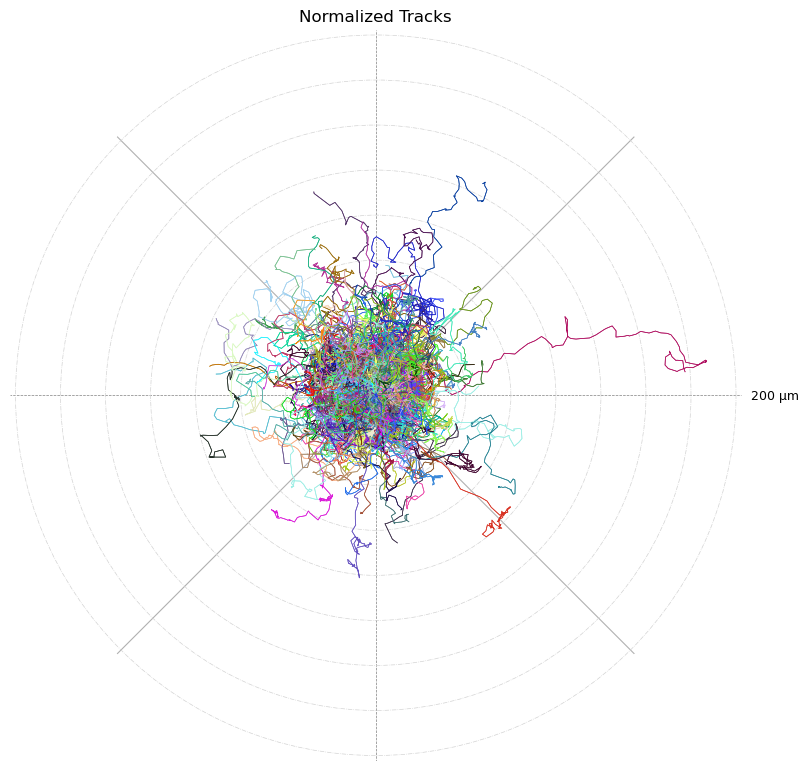

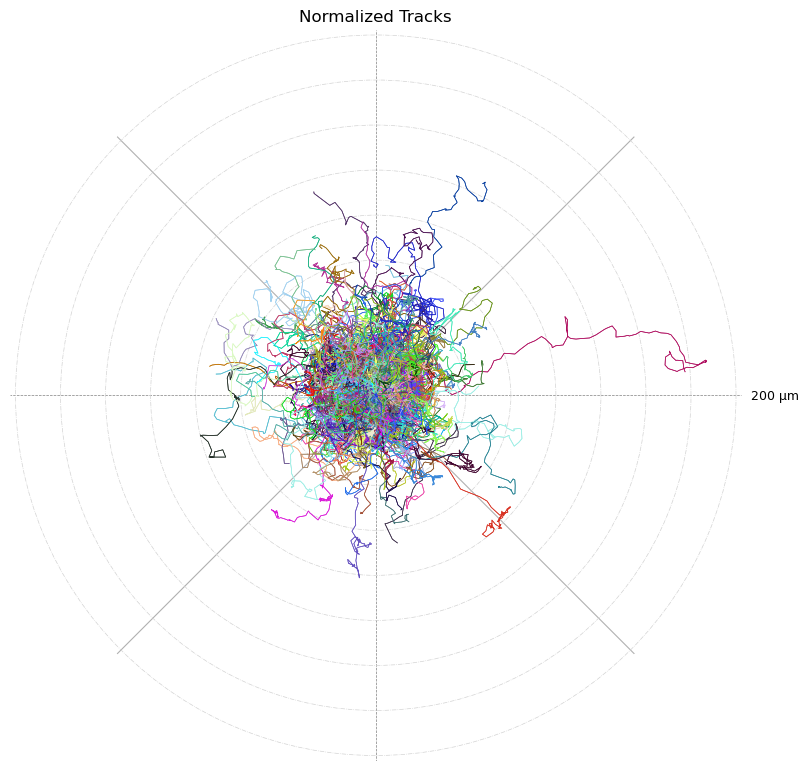

In [ ]:


def get_colormap(c_mode):
    if c_mode == 'greyscale':
        return plt.cm.gist_yarg
    elif c_mode == 'color1':
        return plt.cm.jet
    elif c_mode == 'color2':
        return plt.cm.brg
    elif c_mode == 'color3':
        return plt.cm.hot
    elif c_mode == 'color4':
        return plt.cm.gnuplot
    elif c_mode == 'color5':
        return plt.cm.viridis
    elif c_mode == 'color6':
        return plt.cm.rainbow
    elif c_mode == 'color7':
        return plt.cm.turbo
    elif c_mode == 'color8':
        return plt.cm.nipy_spectral
    elif c_mode == 'color9':
        return plt.cm.gist_ncar
    else:
        return None


def generate_random_color():
    r = np.random.randint(0, 255)  # Random value for Red
    g = np.random.randint(0, 255)  # Random value for Green
    b = np.random.randint(0, 255)  # Random value for Blue
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)


def generate_random_grey():
    n = np.random.randint(0, 240)  # Random value for Grey
    return '#{:02x}{:02x}{:02x}'.format(n, n, n)




def visualize_normalized_tracks(df, condition='all', replicate='all', c_mode='random colors', only_one_color='black', lw=0.5, grid=True, backround='light', lut_metric='NET_DISTANCE'):

    if condition == None or replicate == None:
        pass
    else:
        try:
            condition = int(condition)
        except ValueError or TypeError:
            pass
        try:
            replicate = int(replicate)
        except ValueError or TypeError:
            pass

    if condition == 'all':
        df = df.sort_values(by=['CONDITION', 'REPLICATE', 'TRACK_ID', 'POSITION_T'])
    elif condition != 'all' and replicate == 'all':
        df = df[df['CONDITION'] == condition].sort_values(by=['CONDITION', 'REPLICATE', 'TRACK_ID', 'POSITION_T'])
    elif condition != 'all' and replicate != 'all':
        df = df[(df['CONDITION'] == condition) & (df['REPLICATE'] == replicate)].sort_values(by=['CONDITION', 'REPLICATE', 'TRACK_ID', 'POSITION_T'])


    # First sort the data and get groups of tracks.
    # df.sort_values(by=['CONDITION', 'REPLICATE', 'TRACK_ID', 'POSITION_T'], inplace=True)
    grouped = df.groupby(['CONDITION', 'REPLICATE', 'TRACK_ID'])
    
    unique_tracks = df[['CONDITION', 'REPLICATE', 'TRACK_ID']].drop_duplicates().reset_index(drop=True)
    # For the random modes, pre-assign a color per track.
    if c_mode in ['random colors']:
        track_colors = [generate_random_color() for _ in range(len(unique_tracks))]
    elif c_mode in ['random greys']:
        track_colors = [generate_random_grey() for _ in range(len(unique_tracks))]
    else:
        track_colors = [None] * len(unique_tracks)  # Colors will be assigned via the LUT
    
    color_map_direct = dict(zip(unique_tracks['TRACK_ID'], track_colors))
    df['COLOR'] = df['TRACK_ID'].map(color_map_direct)
    
    # Normalize the positions for each track (shift tracks to start at 0,0)
    for (cond, repl, track_id), group in grouped:
        start_x = group['POSITION_X'].iloc[0]
        start_y = group['POSITION_Y'].iloc[0]
        df.loc[group.index, 'POSITION_X'] -= start_x
        df.loc[group.index, 'POSITION_Y'] -= start_y

    # Convert to polar coordinates.
    df['r'] = np.sqrt(df['POSITION_X']**2 + df['POSITION_Y']**2)
    df['theta'] = np.arctan2(df['POSITION_Y'], df['POSITION_X'])
    
    fig, ax = plt.subplots(figsize=(12.5, 9.5), subplot_kw={'projection': 'polar'})
    y_max = df['r'].max() * 1.1

    ax.set_title('Normalized Tracks')
    ax.set_ylim(0, y_max)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.spines['polar'].set_visible(False)
    ax.grid(grid)
    
    # If using a colormap based on a LUT metric, pre-compute aggregated values
    # Here we use the mean of the lut_metric per track. You can adjust the aggregation as needed.
    if c_mode not in ['random colors', 'random greys', 'only-one'] and lut_metric is not None:
        track_metric = df.groupby('TRACK_ID')[lut_metric].mean()
        metric_min = track_metric.min()
        metric_max = track_metric.max()
    else:
        track_metric = None

    # Plot all tracks
    for (cond, repl, track_id), group in grouped:
        # First, handle the modes that specify a direct color.
        if c_mode == 'random colors':
            color = group['COLOR'].iloc[0]
        elif c_mode == 'random greys':
            color = group['COLOR'].iloc[0]
        elif c_mode == 'only-one':
            color = only_one_color
        else:
            colormap = get_colormap(c_mode)

            # If no explicit color was assigned and we have a colormap, then use LUT mapping.
            if colormap is not None and track_metric is not None:
                # Get the aggregated metric value for the track.
                val = track_metric.get(track_id, 0)
                # Normalize to [0, 1] (protect against division by zero)
                if metric_max > metric_min:
                    norm_val = (val - metric_min) / (metric_max - metric_min)
                else:
                    norm_val = 0.5
                color = colormap(norm_val)
            else:
                # Fallback if something goes wrong
                color = 'black'

        # Plot the track using computed color.
        ax.plot(group['theta'], group['r'], lw=lw, color=color)
    
    if backround == 'light':
        x_grid_color = 'grey'
        y_grid_color = 'lightgrey'
        ax.set_facecolor('white')
    elif backround == 'dark':
        x_grid_color = 'lightgrey'
        y_grid_color = 'grey'
        ax.set_facecolor('darkgrey')

    # Style the polar grid.
    for i, line in enumerate(ax.get_xgridlines()):
        if i % 2 == 0:
            line.set_linestyle('--')
            line.set_color(x_grid_color)
            line.set_linewidth(0.5)

    for line in ax.get_ygridlines():
        line.set_linestyle('-.')
        line.set_color(y_grid_color)
        line.set_linewidth(0.5)

    ax.text(0, df['r'].max() * 1.2, f'{int(round(y_max, -1))} µm',
            ha='center', va='center', fontsize=9, color='black')

    return plt.gcf()

# Example usage
visualize_normalized_tracks(
    Spot_stats,
    condition='all',
    replicate='all',
    c_mode='random colors',
    lw=0.5,
    grid=True,
    lut_metric='NET_DISTANCE'
)

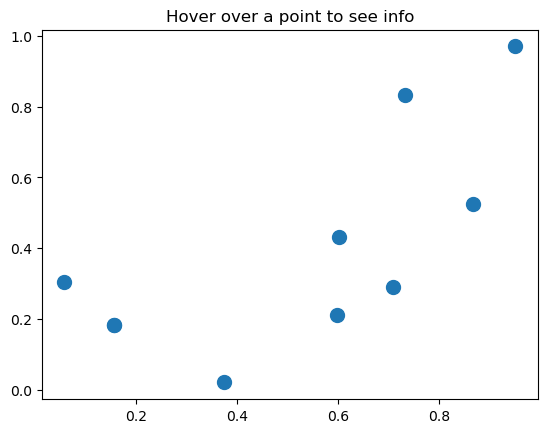

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dummy data
np.random.seed(42)
x = np.random.rand(10)
y = np.random.rand(10)
labels = [f"Point {i}" for i in range(len(x))]

fig, ax = plt.subplots()
sc = ax.scatter(x, y, s=100)

# Annotation setup (initially invisible)
annot = ax.annotate("", xy=(0,0), xytext=(15,15), textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

# Function to update annotation content and position
def update_annot(ind):
    idx = ind["ind"][0]
    pos = sc.get_offsets()[idx]
    annot.xy = pos
    text = f"{labels[idx]}\n({pos[0]:.2f}, {pos[1]:.2f})"
    annot.set_text(text)

# Hover event handler
def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        elif vis:
            annot.set_visible(False)
            fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)

plt.title("Hover over a point to see info")
plt.show()


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Function execution &#x1F3D7;
---
&#x1F6A7; *waiting to be described* &#x1F6A7;

## Thresholding &#x1F3D7;
---
[Function with defined thresholds extracting various dataframes]

&#x1F6A7; *under construction* &#x1F6A7;

In [ ]:
def split_dataframe_by_percentiles(df, column_name):
    # Get to know the data frames name
    df_name = [name for name, value in globals().items() if value is df][0]

    # Dictionary to store each DataFrame filtered by percentiles
    dataframes_by_percentile = {}

    # Calculate percentiles and filter the DataFrame for each
    for percentile in range(10, 100, 10):
        threshold_value = df[column_name].quantile(percentile / 100)
        filtered_df = df[df[column_name] > threshold_value]

        # Save the DataFrame
        filename = f'{df_name}_with_{column_name}_thresholded_at_{percentile}th_percentile.csv'
        filtered_df.to_csv(op.join(save_path, filename), index=False)

        # Store in dictionary (optional)
        dataframes_by_percentile[f'threshold_at_{percentile}th_percentile'] = filtered_df

    # Accessing a specific DataFrame for, say, the 30th percentile
    df_thresholded_at_10th_percentile = dataframes_by_percentile['threshold_at_10th_percentile'] # 10th
    df_thresholded_at_20th_percentile = dataframes_by_percentile['threshold_at_20th_percentile'] # 20th
    df_thresholded_at_30th_percentile = dataframes_by_percentile['threshold_at_30th_percentile'] # 30th
    df_thresholded_at_40th_percentile = dataframes_by_percentile['threshold_at_40th_percentile'] # 40th
    df_thresholded_at_50th_percentile = dataframes_by_percentile['threshold_at_50th_percentile'] # 50th
    df_thresholded_at_60th_percentile = dataframes_by_percentile['threshold_at_60th_percentile'] # 60th
    df_thresholded_at_70th_percentile = dataframes_by_percentile['threshold_at_70th_percentile'] # 70th
    df_thresholded_at_80th_percentile = dataframes_by_percentile['threshold_at_80th_percentile'] # 80th
    df_thresholded_at_90th_percentile = dataframes_by_percentile['threshold_at_90th_percentile'] # 90th


    return df_thresholded_at_10th_percentile, df_thresholded_at_20th_percentile, df_thresholded_at_30th_percentile, df_thresholded_at_40th_percentile, df_thresholded_at_50th_percentile, df_thresholded_at_60th_percentile, df_thresholded_at_70th_percentile, df_thresholded_at_80th_percentile, df_thresholded_at_90th_percentile
Track_stats_thresholded_at_10th_percentile, Track_stats_thresholded_at_20th_percentile, Track_stats_thresholded_at_30th_percentile, Track_stats_thresholded_at_40th_percentile, Track_stats_thresholded_at_50th_percentile, Track_stats_thresholded_at_60th_percentile, Track_stats_thresholded_at_70th_percentile, Track_stats_thresholded_at_80th_percentile, Track_stats_thresholded_at_90th_percentile = split_dataframe_by_percentiles(Track_stats, 'NET_DISTANCE')

# You should try: split_dataframe_by_percentiles(df, column_name); column_name = 'NET_DISTANCE', 'TRACK_LENGTH', 'CONFINEMENT_RATIO', 'SPEED_MEDIAN AND OR MEAN, ETC 


NameError: name 'save_path' is not defined

## Visualizers, Plots, Histograms &#x1F3D7;
---
&#x1F6A7; *waiting to be described* &#x1F6A7;

---
### Defining the optic parameters
Defining the pixel length, imaging winfow parameters and aspect ratio based on the microscope:

In [ ]:
# Definition of micron length per pixel
microns_per_pixel = 0.7381885238402274 # for 10x lens

# Define the desired dimensions in microns
x_min, x_max = 0, (1600 * microns_per_pixel)
y_min, y_max = 0, (1200 * microns_per_pixel)
x_axe_remainder = x_max-1150
x_add = 50 - x_axe_remainder
y_ax_remainder = y_max-850
x_substract = (x_max - y_max) + (y_ax_remainder - 50)

# Calculate the aspect ratio
aspect_ratio = x_max / y_max

: 

: 

: 

In [ ]:
title_size = 18
label_size = 11
figtext_size = 9
compass_annotations_size = 15
figtext_color = 'grey'

: 

: 

: 

---
### Defining settings and the parametres for track visualization &#x1F3D7;

Defining the settings and parametres for visualization separately, so that they need not be defined over again in each of the different track visualizations

&#x1F6A7; *under construction* &#x1F6A7; 

In [ ]:
def track_visuals(df, df2):
    # fig and ax definition
    fig, ax = plt.subplots(figsize=(13, 10))

    # Ensuring that dataframse have required data
    track_ids = df2['TRACK_ID'].unique()

    # Filter df2 to only include rows where TRACK_ID is in df's track_ids
    df_filtered = df[df['TRACK_ID'].isin(track_ids)]

    net_distances = df2[['TRACK_ID', 'NET_DISTANCE']]

    # Normalize the NET_DISTANCE to a 0-1 range
    dmin = net_distances['NET_DISTANCE'].min()
    dmax = net_distances['NET_DISTANCE'].max()
    norm = plt.Normalize(vmin=dmin, vmax=dmax)
    colormap = plt.cm.jet

    # Create a dictionary to store the color for each track based on its confinement ratio
    track_colors = {}
    for track_id in track_ids:
        ratio = net_distances[net_distances['TRACK_ID'] == track_id]['NET_DISTANCE'].values[0]
        track_colors[track_id] = colormap(norm(ratio))

    # Set up the plot limits
    x_min, x_max = df_filtered['POSITION_X'].min(), df_filtered['POSITION_X'].max()
    y_min, y_max = df_filtered['POSITION_Y'].min(), df_filtered['POSITION_Y'].max()
    ax.set_aspect('1', adjustable='box')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('Position X [microns]')
    ax.set_ylabel('Position Y [microns]')
    ax.set_title('Track Visualization', fontsize=title_size)
    ax.set_facecolor('dimgrey')
    ax.grid(True, which='both', axis='both', color='grey', linewidth=1)

    # Manually set the major tick locations and labels
    x_ticks_major = np.arange(x_min, x_max, 200)  # Adjust the step size as needed
    y_ticks_major = np.arange(y_min, y_max, 200)  # Adjust the step size as needed
    ax.set_xticks(x_ticks_major)
    ax.set_yticks(y_ticks_major)
    ax.set_xticklabels([f'{tick:.0f}' for tick in x_ticks_major])
    ax.set_yticklabels([f'{tick:.0f}' for tick in y_ticks_major])

    # Enable minor ticks and set their locations
    ax.minorticks_on()
    x_ticks_minor = np.arange(x_min, x_max, 50)  # Minor ticks every 50 microns
    y_ticks_minor = np.arange(y_min, y_max, 50)  # Minor ticks every 50 microns
    ax.set_xticks(x_ticks_minor, minor=True)
    ax.set_yticks(y_ticks_minor, minor=True)
    

    # Access and modify tick labels
    # for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    #      label.set_fontproperties(roboto_ticks)
    ax.tick_params(axis='both', which='major', labelsize=8)

    return fig, ax, track_ids, track_colors, norm, colormap

: 

: 

: 

---
### Visualizing the tracks &#x1F3D7;

*Overview of the tracks:*

&#x1F6A7; *under construction* &#x1F6A7; 

In [ ]:
def track_visuals(df, df2):
    # fig and ax definition
    fig, ax = plt.subplots(figsize=(13, 10))

    # Ensuring that dataframse have required data
    track_ids = df2['TRACK_ID'].unique()

    # Filter df2 to only include rows where TRACK_ID is in df's track_ids
    df_filtered = df[df['TRACK_ID'].isin(track_ids)]

    net_distances = df2[['TRACK_ID', 'NET_DISTANCE']]

    # Normalize the NET_DISTANCE to a 0-1 range
    dmin = net_distances['NET_DISTANCE'].min()
    dmax = net_distances['NET_DISTANCE'].max()
    norm = plt.Normalize(vmin=dmin, vmax=dmax)
    colormap = plt.cm.jet

    # Create a dictionary to store the color for each track based on its confinement ratio
    track_colors = {}
    for track_id in track_ids:
        ratio = net_distances[net_distances['TRACK_ID'] == track_id]['NET_DISTANCE'].values[0]
        track_colors[track_id] = colormap(norm(ratio))

    # Set up the plot limits
    x_min, x_max = df_filtered['POSITION_X'].min(), df_filtered['POSITION_X'].max()
    y_min, y_max = df_filtered['POSITION_Y'].min(), df_filtered['POSITION_Y'].max()
    ax.set_aspect('1', adjustable='box')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('Position X [microns]')
    ax.set_ylabel('Position Y [microns]')
    ax.set_title('Track Visualization', fontsize=title_size)
    ax.set_facecolor('dimgrey')

    # Manually draw rotated gridlines
    color = 'grey'     # Gridline color
    alpha = 0.2        # Gridline transparency
    lw = 0.6           # Gridline width
    grid_spacing = 50  # Adjust the spacing of gridlines
    angle1 = 45        # Rotation angle in degrees
    angle2 = -45       # Rotation angle in degrees
    z_order = 0.5      # Gridline z-order

    for x in np.arange(x_min, x_max, grid_spacing):
        for y in np.arange(y_min, y_max, grid_spacing):
            # Compute the rotated line endpoints
            x_lines_a = [x, x + (y_max - y_min) * np.tan(np.radians(angle1))]
            y_lines_a = [y, y + (x_max - x_min) * np.tan(np.radians(angle1))]
            x_lines_b = [x, x + (y_max - y_min) * np.tan(np.radians(angle2))]
            y_lines_b = [y, y + (x_max - x_min) * np.tan(np.radians(angle2))]
            ax.plot(x_lines_a, [y_min, y_max], color=color, linestyle='-', linewidth=lw, alpha=alpha, zorder=z_order)
            ax.plot(y_lines_a, [(x_max+x_add), (x_min+x_add)], color=color, linestyle='-', linewidth=lw, alpha=alpha, zorder=z_order)
            ax.plot(x_lines_b, [y_min, y_max], color=color, linestyle='-', linewidth=lw, alpha=alpha, zorder=z_order)
            ax.plot(y_lines_b, [(x_max - x_substract), (x_min - x_substract)], color=color, linestyle='-', linewidth=lw, alpha=alpha, zorder=z_order)

    # Standard gridlines (optional)
    ax.grid(False)  # Turn off default gridlines


    # Manually set the major tick locations and labels
    x_ticks_major = np.arange(x_min, x_max, 200)  # Adjust the step size as needed
    y_ticks_major = np.arange(y_min, y_max, 200)  # Adjust the step size as needed
    ax.set_xticks(x_ticks_major)
    ax.set_yticks(y_ticks_major)
    ax.set_xticklabels([f'{tick:.0f}' for tick in x_ticks_major])
    ax.set_yticklabels([f'{tick:.0f}' for tick in y_ticks_major])

    # Enable minor ticks and set their locations
    ax.minorticks_on()
    x_ticks_minor = np.arange(x_min, x_max, 50)  # Minor ticks every 50 microns
    y_ticks_minor = np.arange(y_min, y_max, 50)  # Minor ticks every 50 microns
    ax.set_xticks(x_ticks_minor, minor=True)
    ax.set_yticks(y_ticks_minor, minor=True)
    

    # Access and modify tick labels
    # for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    #      label.set_fontproperties(roboto_ticks)
    ax.tick_params(axis='both', which='major', labelsize=8)

    return fig, ax, track_ids, track_colors, norm, colormap

: 

: 

: 

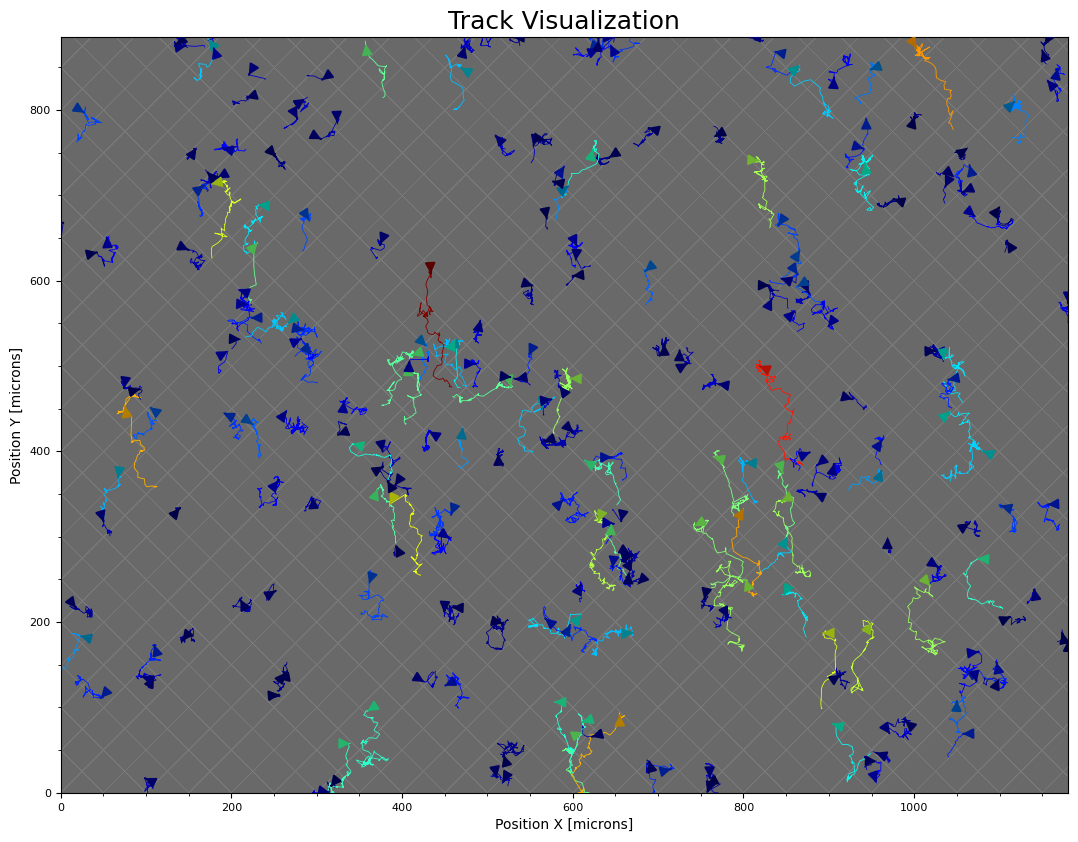

: 

: 

: 

In [ ]:
def visualize_full_tracks(df, df2, threshold, lw=1):  #Trakcs visualisation

    # Recognizing the presence of a threshold
    if threshold == None:
        threshold = '_no_threshold'
    else:
        threshold = '_' + threshold

    # Using the  track_visuals function
    fig_visuals, ax_visuals, track_ids_visuals, track_colors_visuals, norm_visuals, colormap_visuals = track_visuals(df, df2)

    # Plot the full tracks
    for track_id in track_ids_visuals:
        track_data = df[df['TRACK_ID'] == track_id]
        x = track_data['POSITION_X']
        y = track_data['POSITION_Y']
        ax_visuals.plot(x, y, lw=lw, color=track_colors_visuals[track_id], label=f'Track {track_id}')
        
        # Get the original color from track_colors_visuals[track_id]
        original_color = mcolors.to_rgb(track_colors_visuals[track_id])
        # Darken the color by reducing the brightness (by scaling each RGB channel)
        darkened_color = np.array(original_color) * 0.7  # Adjust 0.7 to a value between 0 and 1 for different darkness levels
        # Ensure that no channel goes below 0 (clip values if necessary)
        darkened_color = np.clip(darkened_color, 0, 1)
        # Apply the darkened color with a slight increase in the green and blue channels for the original factor you had (optional)
        color = darkened_color * np.array([1.0, 1.0, 0.8])  # If you want to keep the original adjustment
    

        if len(x) > 1:
            # Add arrow to indicate direction
            dx = x.diff().iloc[-1]
            dy = y.diff().iloc[-1]
            if dx != 0 or dy != 0:
                # Create an arrow instead of a circle
                arrow = FancyArrowPatch(
                    posA=(x.iloc[-2], y.iloc[-2]),  # Start position (second-to-last point)
                    posB=(x.iloc[-1], y.iloc[-1]),  # End position (last point)
                    arrowstyle='-|>',  # Style of the arrow (you can adjust the style as needed)
                    color=color,  # Set the color of the arrow
                    mutation_scale=15,  # Scale the size of the arrow head (adjust this based on the plot scale)
                    linewidth=1.5,  # Line width for the arrow
                    zorder=10  # Ensure the arrow is drawn on top of the line
                )

                # Add the arrow to your plot (if you're using a `matplotlib` figure/axes)
                plt.gca().add_patch(arrow)

    plt.savefig((op.join(save_path, f'01a_Full_tracks_snapshot{threshold}.png')), dpi=300)
    # plt.show()
visualize_full_tracks(butter_df, Track_stats, None, lw=0.6)
# visualize_full_tracks(butter_df, Track_stats_thresholded_at_20th_percentile, 'thresholded_at_20th_percentile') # 20th
# visualize_full_tracks(butter_df, Track_stats_thresholded_at_40th_percentile, 'thresholded_at_40th_percentile') # 40th
# visualize_full_tracks(butter_df, Track_stats_thresholded_at_60th_percentile, 'thresholded_at_60th_percentile') # 60th
# visualize_full_tracks(butter_df, Track_stats_thresholded_at_80th_percentile, 'thresholded_at_80th_percentile') # 80th
# visualize_full_tracks(butter_df, Track_stats_thresholded_at_90th_percentile, 'thresholded_at_90th_percentile') # 90th

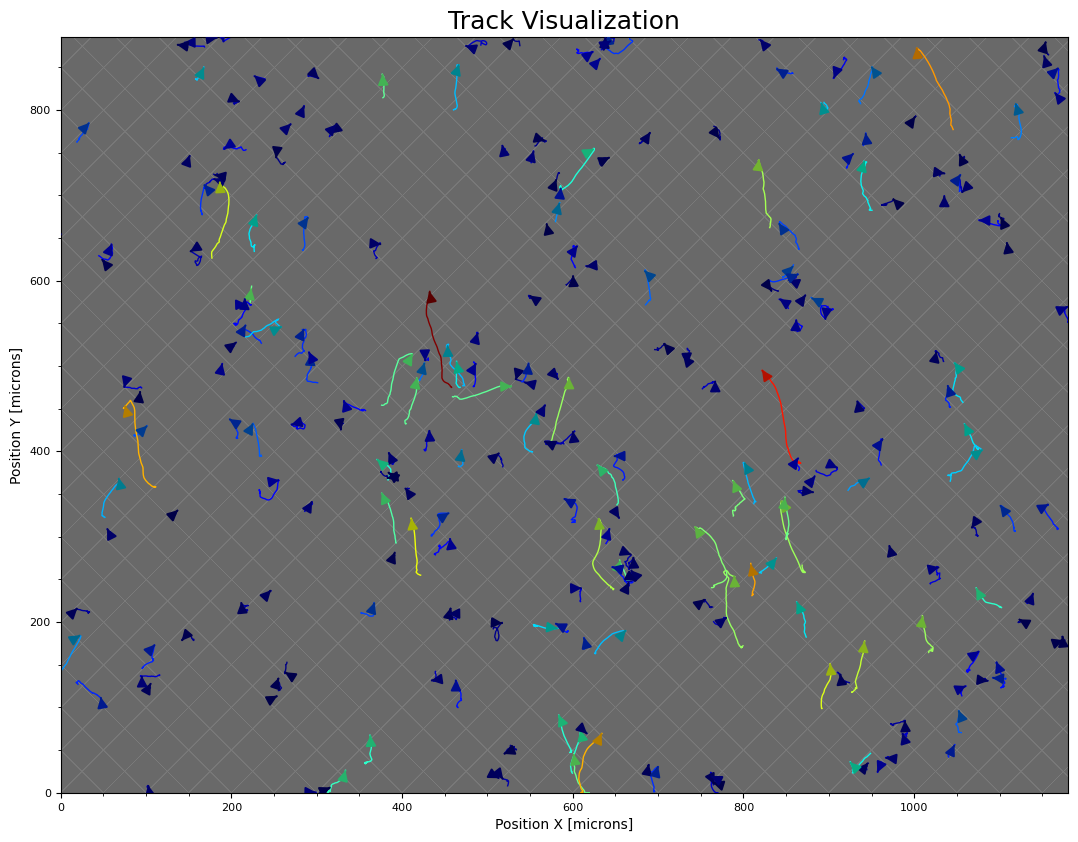

: 

: 

: 

In [ ]:
def visualize_smoothed_tracks(df, df2, threshold, smoothing_type=None, smoothing_index=10, lw=1):  # Tracks visualization

    # Recognizing the presence of a threshold
    if threshold is None:
        threshold = '_no_threshold'
    else:
        threshold = '_' + threshold

    # Using the track_visuals function
    fig_visuals, ax_visuals, track_ids_visuals, track_colors_visuals, norm_visuals, colormap_visuals = track_visuals(df, df2)

    # Plot the full tracks
    for track_id in track_ids_visuals:
        track_data = df[df['TRACK_ID'] == track_id]
        x = track_data['POSITION_X']
        y = track_data['POSITION_Y']
        
        # Apply smoothing to the track (if applicable)
        if smoothing_type == 'moving_average':
            x_smoothed = x.rolling(window=smoothing_index, min_periods=1).mean()
            y_smoothed = y.rolling(window=smoothing_index, min_periods=1).mean()
        else:
            x_smoothed = x
            y_smoothed = y

        ax_visuals.plot(x_smoothed, y_smoothed, lw=lw, color=track_colors_visuals[track_id], label=f'Track {track_id}')

        # Get the original color from track_colors_visuals[track_id]
        original_color = mcolors.to_rgb(track_colors_visuals[track_id])
        # Darken the color by reducing the brightness (by scaling each RGB channel)
        darkened_color = np.array(original_color) * 0.7  # Adjust 0.7 to a value between 0 and 1 for different darkness levels
        # Ensure that no channel goes below 0 (clip values if necessary)
        darkened_color = np.clip(darkened_color, 0, 1)
        # Apply the darkened color with a slight increase in the green and blue channels for the original factor you had (optional)
        color = darkened_color * np.array([1.0, 1.0, 0.8])  # If you want to keep the original adjustment


        if len(x_smoothed) > 1:
            # Extract the mean direction from df2 for the current track
            mean_direction_rad = df2[df2['TRACK_ID'] == track_id]['MEAN_DIRECTION_RAD'].values[0]
            
            # Use trigonometry to calculate the direction (dx, dy) from the angle
            dx = np.cos(mean_direction_rad)  # Change in x based on angle
            dy = np.sin(mean_direction_rad)  # Change in y based on angle
            
            # Create an arrow to indicate direction
            arrow = FancyArrowPatch(
                posA=(x_smoothed.iloc[-2], y_smoothed.iloc[-2]),  # Start position (second-to-last point)
                posB=(x_smoothed.iloc[-2] + dx, y_smoothed.iloc[-2] + dy),  # End position based on direction
                arrowstyle='-|>',  # Style of the arrow (you can adjust the style as needed)
                color=color,  # Set the color of the arrow
                mutation_scale=15,  # Scale the size of the arrow head (adjust this based on the plot scale)
                linewidth=1.5,  # Line width for the arrow
                zorder=30  # Ensure the arrow is drawn on top of the line
            )

            # Add the arrow to your plot (if you're using a `matplotlib` figure/axes)
            plt.gca().add_patch(arrow)

    plt.savefig((op.join(save_path, f'01a_Full_tracks_snapshot{threshold}.png')), dpi=300)
    # plt.show()

# Example usage
visualize_smoothed_tracks(butter_df, Track_stats, None, smoothing_type='moving_average', smoothing_index=50, lw=1)


---
### Histograms describing cell motility &#x1F3D7;

*Histogram plotting all cells in the dataset and its migrated distance together with the time window in which it has been imaged:*

&#x1F6A7; *under construction* &#x1F6A7; 

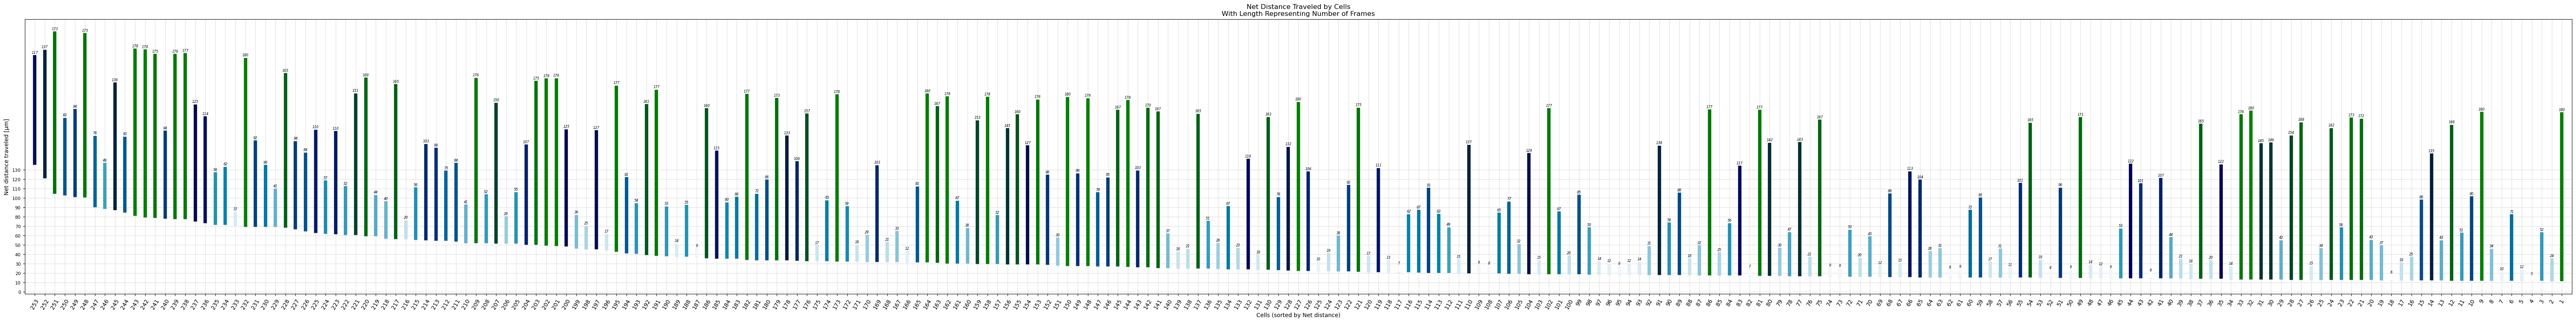

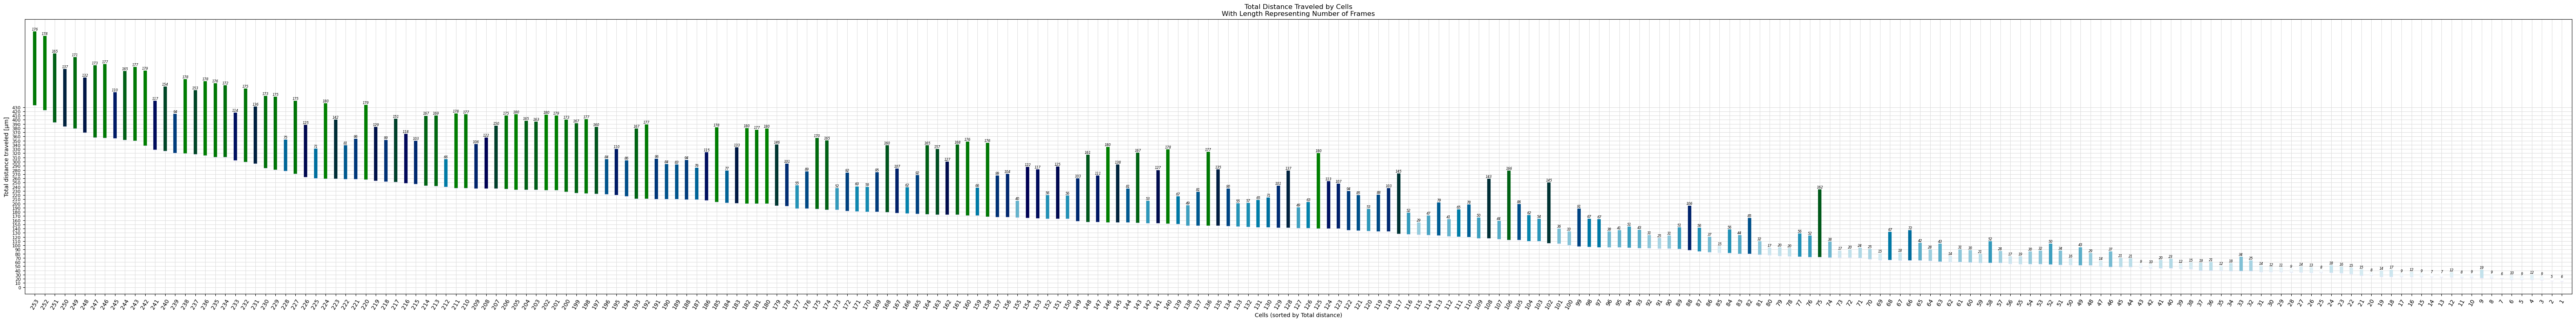

: 

: 

: 

In [ ]:

def histogram_cells_distance(df, metric, str):
    
    # Sort the DataFrame by 'TRACK_LENGTH' in ascending order
    df_sorted = df.sort_values(by=metric)

    norm = mcolors.Normalize(vmin=df_sorted["NUM_FRAMES"].min(), vmax=df_sorted["NUM_FRAMES"].max())
    cmap = plt.colormaps["ocean_r"]

    # Create new artificial IDs for sorting purposes (1 for lowest distance, N for highest)
    df_sorted["Artificial_ID"] = range(1, len(df_sorted) + 1)

    x_span = PlotParams.x_span(df_sorted)

    # Create the figure and axis for the plot
    fig, ax = plt.subplots(figsize=(x_span, 8))
    fig.set_tight_layout(True)
    width = 6

    # Loop through each row to plot each cell's data
    for idx, row in df_sorted.iterrows():
        artificial_id = row["Artificial_ID"]
        track_length = row[metric]
        num_frames = row["NUM_FRAMES"]

        # Get the color based on the number of frames using the viridis colormap
        line_color = cmap(norm(num_frames))

        # Plot the "chimney" or vertical line
        ax.vlines(
            x=artificial_id,  # X position for the cell
            ymin=track_length,  # Starting point of the line (y position)
            ymax=track_length + num_frames,  # End point based on number of frames (height)
            color=line_color,
            linewidth=width,
            )

        plt.plot(artificial_id, track_length, '_', zorder=5, color="lavender")

        # Add the mean number of frames as text above each chimney
        ax.text(
        artificial_id,  # X position (same as the chimney)
        track_length + num_frames + 1,  # Y position (slightly above the chimney)
        f"{round(num_frames)}",  # The text to display (formatted mean)
        ha='center',  # Horizontal alignment center
        va='bottom',  # Vertical alignment bottom
        fontsize=6,  # Adjust font size if necessary
        color='black',  # Color of the text
        style='italic'  # Italicize the text
        )

        x = int(row['Artificial_ID'])

        plt.xticks(range(x), rotation=90) # add loads of ticks
        plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
        plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)


    max_y = df_sorted[metric].max()
    num_x_values = df_sorted[metric].count()

    # Adjust the plot aesthetics
    plt.tick_params(axis='x', rotation=60)
    plt.tick_params(axis='y', labelsize=8)
    plt.xticks(range(num_x_values)) # add loads of ticks
    plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
    plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)

    # Set ticks, labels and title
    ax.set_xticks(range(1, num_x_values + 1))
    ax.set_yticks(np.arange(0, max_y + 1, 10))
    ax.set_xlabel(f"Cells (sorted by {str} distance)")
    ax.set_ylabel(f"{str} distance traveled [μm]")
    ax.set_title(f"{str} Distance Traveled by Cells\nWith Length Representing Number of Frames")

    # Invert x-axis so the highest distance is on the left
    plt.gca().invert_xaxis()

    ax.set_xlim(right=0, left=num_x_values+1)  # Adjust the left limit as needed

    # Show the plot
    plt.savefig(op.join(save_path, f"02f_Histogram_{str}_distance_traveled_per_cell.png"))
    plt.show()
histogram_cells_distance(Track_stats, 'NET_DISTANCE', 'Net')
histogram_cells_distance(Track_stats, 'TRACK_LENGTH', 'Total')

---
*Histogram plotting percentile groups in the cell dataset - migrated distance together with the time window in which it has been imaged:*

&#x1F6A7; *under construction* &#x1F6A7; 

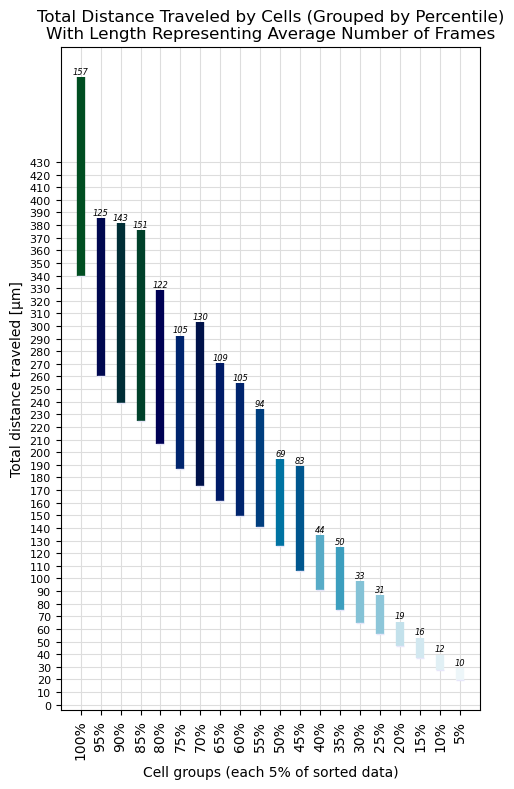

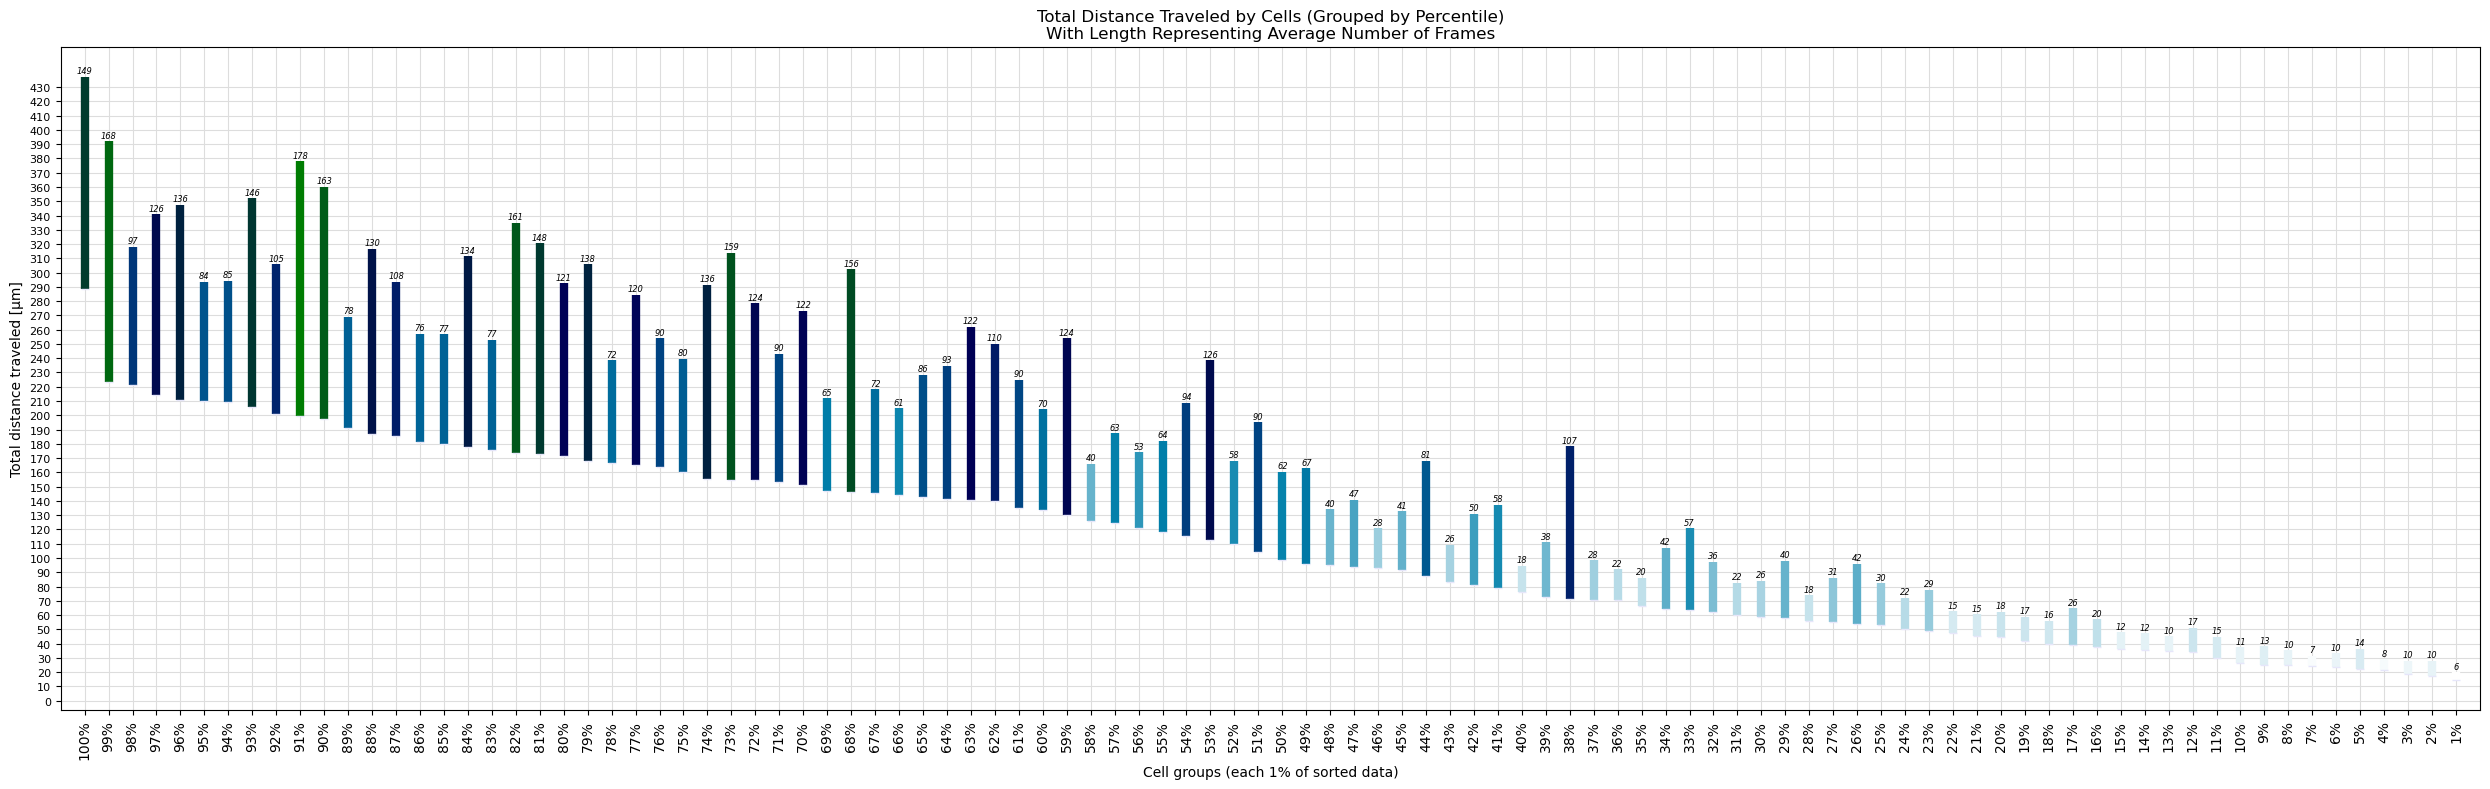

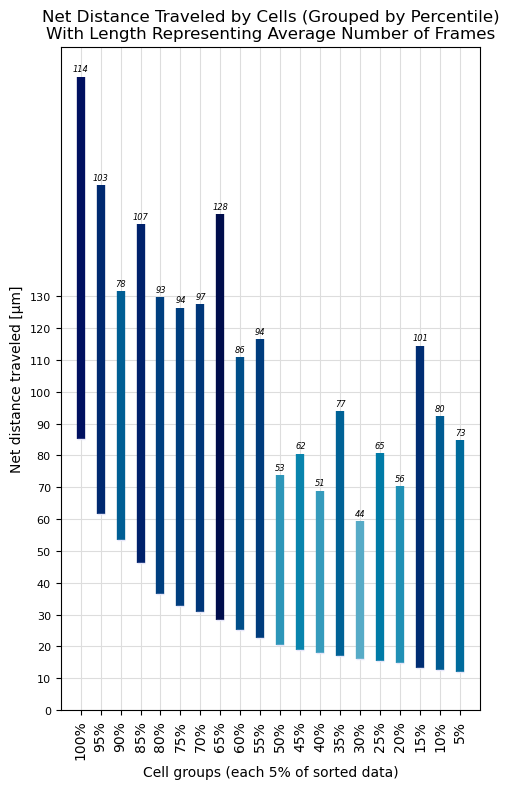

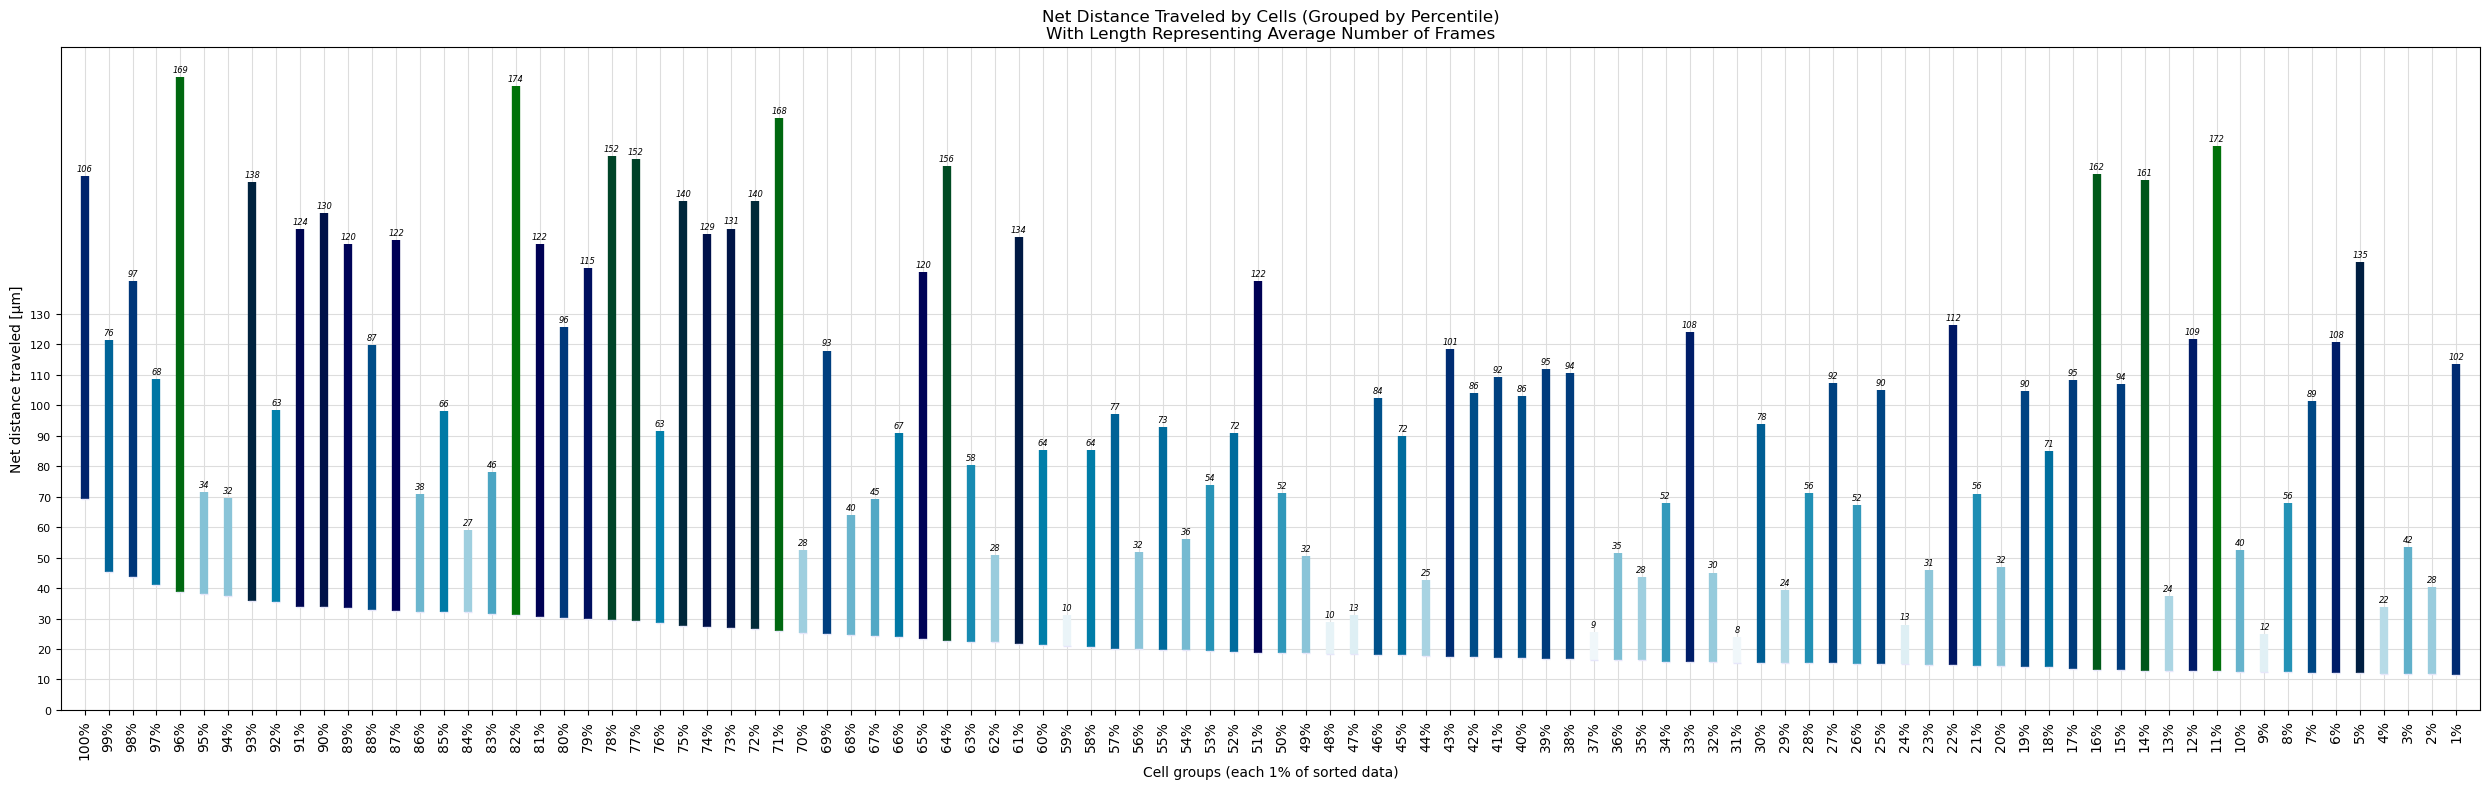

: 

: 

: 

In [ ]:
def histogram_nth_percentile_distance(df, metric, num_groups, percentiles, str, threshold):

    # Recognizing the presence of a threshold
    if threshold == None:
        threshold = '_no_threshold'
    else:
        threshold = '_' + threshold

    # Sort the DataFrame by 'NET_DISTANCE' in ascending order
    df_sorted = df.sort_values(by=metric)

    # Number of groups (chimneys) and size of each group (5% each)
    group_size = len(df_sorted) // num_groups

    x_span = num_groups * 0.25

    # Create the figure and axis for the plot
    fig, ax = plt.subplots(figsize=(x_span, 8))
    fig.set_tight_layout(True)
    width = 6

    # Normalize the 'NUM_FRAMES' column for color mapping
    norm = mcolors.Normalize(vmin=df_sorted["NUM_FRAMES"].min(), vmax=df_sorted["NUM_FRAMES"].max())
    cmap = plt.colormaps["ocean_r"]

    # Loop over each group and plot the aggregate statistics
    for i in range(num_groups):
        # Define group indices
        group_start = i * group_size
        group_end = (i + 1) * group_size if i != num_groups - 1 else len(df_sorted)

        # Get the current group data
        group_data = df_sorted.iloc[group_start:group_end]

        # Calculate the aggregate statistics for the group
        group_mean_distance = group_data[metric].mean()
        group_mean_frames = group_data["NUM_FRAMES"].mean()

        # Set x-position of the group (e.g., center it based on group index)
        group_x = i + 1

        # Get the color based on the average number of frames in the group
        line_color = cmap(norm(group_mean_frames))

        # Plot the "chimney" representing the group
        ax.vlines(
            x=group_x,  # X position for the group
            ymin=group_mean_distance,  # Starting point of the line (y position)
            ymax=group_mean_distance + group_mean_frames,  # End point based on average number of frames (height)
            color=line_color,
            linewidth=width,
            )

        plt.plot(group_x, group_mean_distance, '_', zorder=5, color="lavender")

        # Add the mean number of frames as text above each chimney
        ax.text(
            group_x,  # X position (same as the chimney)
            group_mean_distance + group_mean_frames + 1,  # Y position (slightly above the chimney)
            f'{round(group_mean_frames)}',  # The text to display (formatted mean)
            ha='center',  # Horizontal alignment center
            va='bottom',  # Vertical alignment bottom
            fontsize=6,  # Adjust font size if necessary
            color='black',  # Color of the text
            style='italic'
            )

    max_y = df_sorted[metric].max() 

    # Adjust the plot aesthetics
    plt.xticks(range(group_x)) # add loads of ticks
    plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
    plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)

    plt.tick_params(axis='x', rotation=60)
    plt.tick_params(axis='y', labelsize=8) 

    ax.set_xticks(range(1, num_groups + 1))
    ax.set_xticklabels([f"{percentiles * (i + 1)}%" for i in range(num_groups)], rotation=90)
    ax.set_yticks(np.arange(0, max_y + 1, 10))
    ax.set_xlabel(f"Cell groups (each {percentiles}% of sorted data)")
    ax.set_ylabel(f"{str} distance traveled [μm]")
    ax.set_title(f"{str} Distance Traveled by Cells (Grouped by Percentile)\nWith Length Representing Average Number of Frames")
    ax.grid(which="major", color="#DDDDDD", linewidth=0.8)
    ax.grid(which="minor", color="#EEEEEE", linestyle=":", linewidth=0.5)

    # Invert x-axis so the highest distance is on the left
    ax.invert_xaxis()

    ax.set_xlim(right=0, left=num_groups+1)  # Adjust the left limit as needed

    # Show the plot
    plt.savefig((op.join(save_path, f"02f_Histogram_{str}_distance_traveled_{percentiles}th_percentiles{threshold}.png")))
    plt.show()
histogram_nth_percentile_distance(Track_stats, 'TRACK_LENGTH', 20, 5, 'Total', None)
histogram_nth_percentile_distance(Track_stats, 'TRACK_LENGTH', 100, 1, 'Total', None)
histogram_nth_percentile_distance(Track_stats, 'NET_DISTANCE', 20, 5, 'Net', None)
histogram_nth_percentile_distance(Track_stats, 'NET_DISTANCE', 100, 1, 'Net', None)
# histogram_nth_percentile_distance(Track_stats_thresholded_at_20th_percentile, 'TRACK_LENGTH', 20, 5, 'Total', 'thresholded_at_20th_percentile') # 20th
# histogram_nth_percentile_distance(Track_stats_thresholded_at_20th_percentile, 'NET_DISTANCE', 20, 5, 'Net', 'thresholded_at_20th_percentile')
# histogram_nth_percentile_distance(Track_stats_thresholded_at_40th_percentile, 'TRACK_LENGTH', 20, 5, 'Total', 'thresholded_at_40th_percentile') # 40th
# histogram_nth_percentile_distance(Track_stats_thresholded_at_40th_percentile, 'NET_DISTANCE', 20, 5, 'Net', 'thresholded_at_40th_percentile')
# histogram_nth_percentile_distance(Track_stats_thresholded_at_60th_percentile, 'TRACK_LENGTH', 20, 5, 'Total', 'thresholded_at_60th_percentile') # 60th
# histogram_nth_percentile_distance(Track_stats_thresholded_at_60th_percentile, 'NET_DISTANCE', 20, 5, 'Net', 'thresholded_at_60th_percentile')
# histogram_nth_percentile_distance(Track_stats_thresholded_at_80th_percentile, 'TRACK_LENGTH', 20, 5, 'Total', 'thresholded_at_80th_percentile') # 80th
# histogram_nth_percentile_distance(Track_stats_thresholded_at_80th_percentile, 'NET_DISTANCE', 20, 5, 'Net', 'thresholded_at_80th_percentile')

---
*Histogram plotting the median and mean speed of migration per frame* &#x1F3D7;

&#x1F6A7; *under heavy construction* &#x1F6A7; 

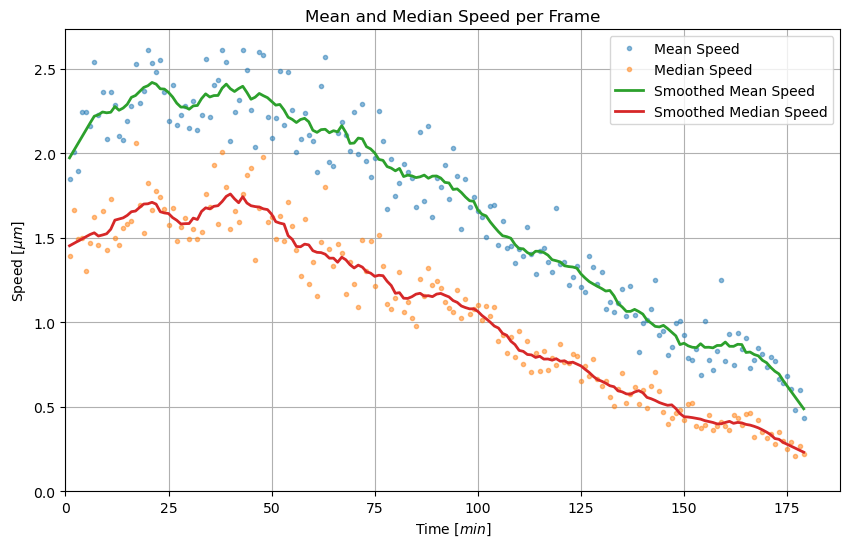

: 

: 

: 

In [ ]:
frames = Frame_stats['POSITION_T'][1:-1]
mean_speed = Frame_stats['SPEED_MEAN'][1:-1]
median_speed = Frame_stats['SPEED_MEDIAN'][1:-1]

# Apply Savitzky-Golay filter for smoothing
mean_speed_smooth = savgol_filter(mean_speed, window_length=11, polyorder=1)
median_speed_smooth = savgol_filter(median_speed, window_length=11, polyorder=1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(frames, mean_speed, '.', label='Mean Speed', alpha=0.5)
plt.plot(frames, median_speed, '.', label='Median Speed', alpha=0.5)
plt.plot(frames, mean_speed_smooth, '-', label='Smoothed Mean Speed', linewidth=2)
plt.plot(frames, median_speed_smooth, '-', label='Smoothed Median Speed', linewidth=2)

# Set x-axis to start at 0
plt.xlim(left=0)
plt.ylim(bottom=0)

plt.xlabel(r'Time $\it{[min]}$')
plt.ylabel(r'Speed $\it{[μm]}$')
plt.title('Mean and Median Speed per Frame')
plt.legend()
plt.grid(True)
plt.show()

---


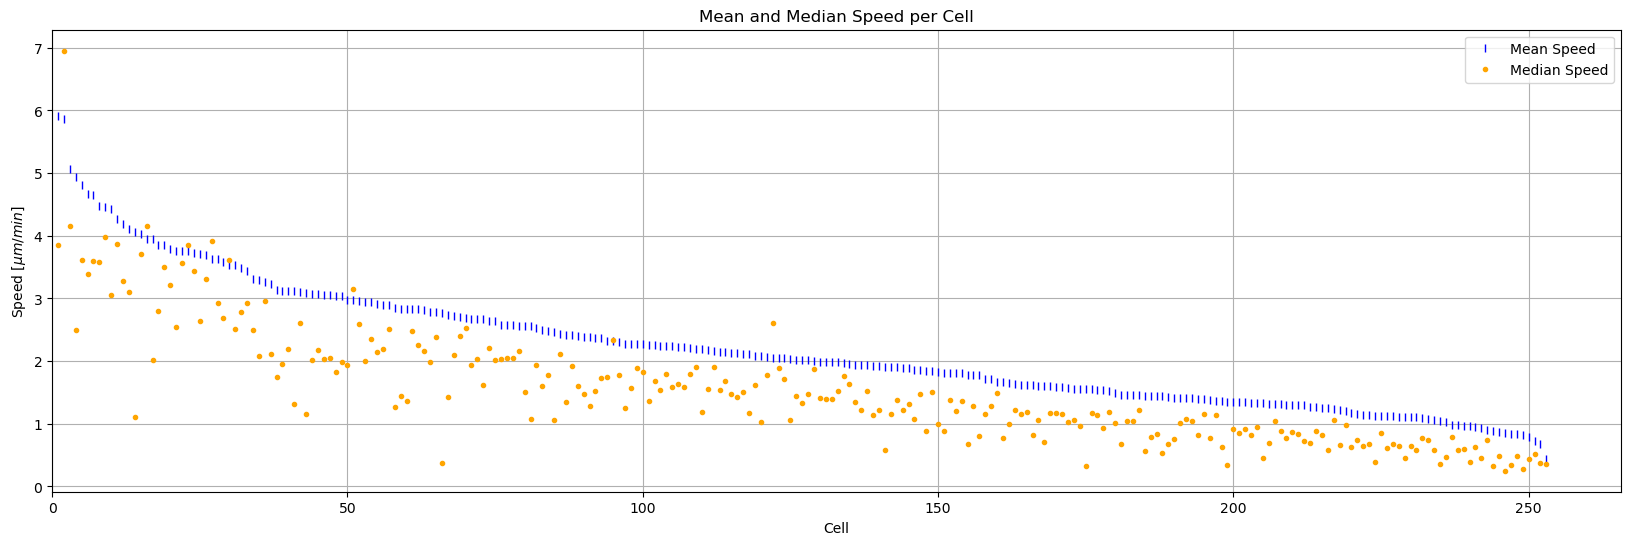

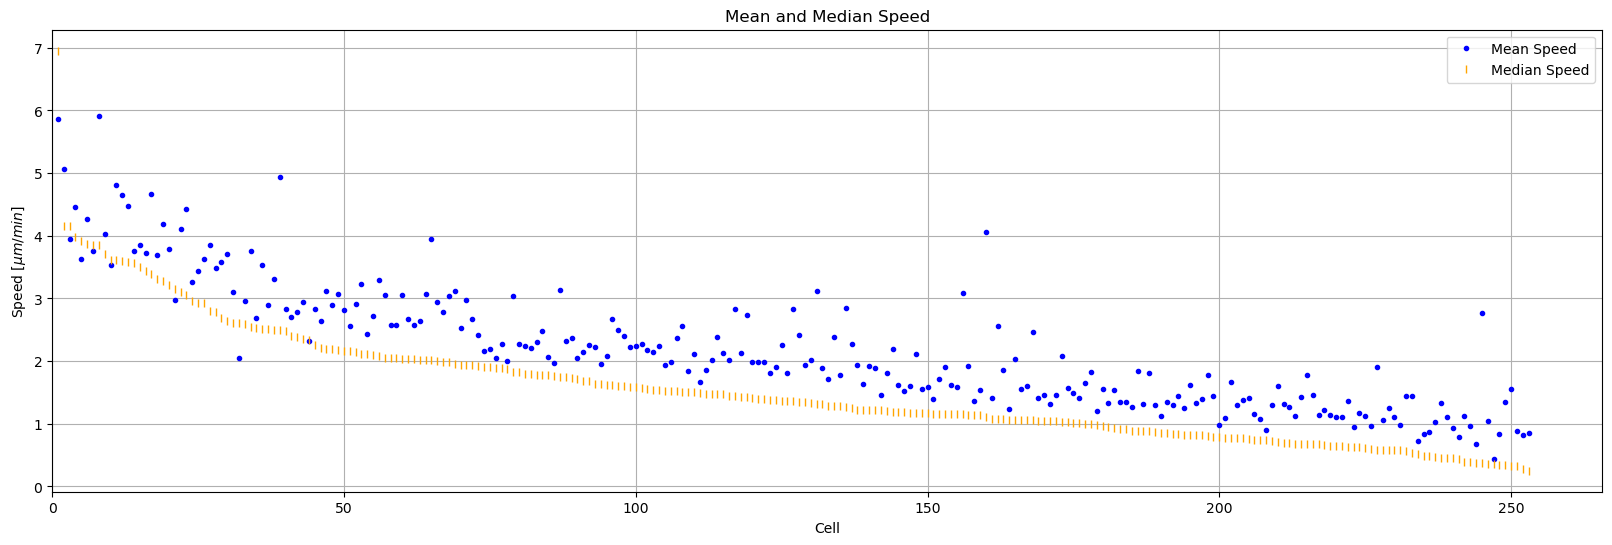

: 

: 

: 

In [ ]:
# Sort the DataFrame by 'TRACK_LENGTH' in ascending order
df_sorted_a = Track_stats.sort_values(by='SPEED_MEAN', ascending=False)
df_sorted_b = Track_stats.sort_values(by='SPEED_MEDIAN', ascending=False)

# Create new artificial IDs for sorting purposes (1 for lowest distance, N for highest)
df_sorted_a["Artificial_ID"] = range(1, len(df_sorted_a) + 1)
df_sorted_b["Artificial_ID"] = range(1, len(df_sorted_b) + 1)

# defining variables
cell_id_a = df_sorted_a["Artificial_ID"]
mean_speed_a = df_sorted_a['SPEED_MEAN']
median_speed_a = df_sorted_a['SPEED_MEDIAN']

cell_id_b = df_sorted_b["Artificial_ID"]
mean_speed_b = df_sorted_b['SPEED_MEAN']
median_speed_b = df_sorted_b['SPEED_MEDIAN']

# mean_speed_smooth = savgol_filter(mean_speed_a, window_length=11, polyorder=1)
# median_speed_smooth = savgol_filter(median_speed_b, window_length=11, polyorder=1)



x_span = PlotParams.x_span(Track_stats4_df, 0.08)

# Plotting no. 1
plt.figure(figsize=(x_span, 6))
plt.plot(cell_id_a, mean_speed_a, '|', label='Mean Speed', color='blue')
plt.plot(cell_id_a, median_speed_a, '.', label='Median Speed', color='orange')
# plt.plot(cell_id_a, mean_speed_smooth, '-', label='Mean Speed', linewidth=2, color='blue', zorder=1)

# Set x-axis to start at 0
plt.xlim(left=0)

plt.xlabel('Cell')
plt.ylabel(r'Speed $\it{[μm/min]}$')
plt.title('Mean and Median Speed per Cell')
plt.legend()
plt.grid(True)
plt.show()


# Plotting no. 2
plt.figure(figsize=(20, 6))
plt.plot(cell_id_b, mean_speed_b, '.', label='Mean Speed', color='blue')
plt.plot(cell_id_b, median_speed_b, '|', label='Median Speed', color='orange')
# plt.plot(cell_id_b, median_speed_smooth, '-', label='Median Speed', linewidth=2, color='orange', zorder=1)

# Set x-axis to start at 0
plt.xlim(left=0)

plt.xlabel('Cell')
plt.ylabel(r'Speed $\it{[μm/min]}$')
plt.title('Mean and Median Speed')
plt.legend()
plt.grid(True)
plt.show()

---
### Plotting the direction of migration &#x1F3D7;
&#x1F6A7; *under construction* &#x1F6A7; 

: 

: 

: 

NameError: name 'save_path' is not defined

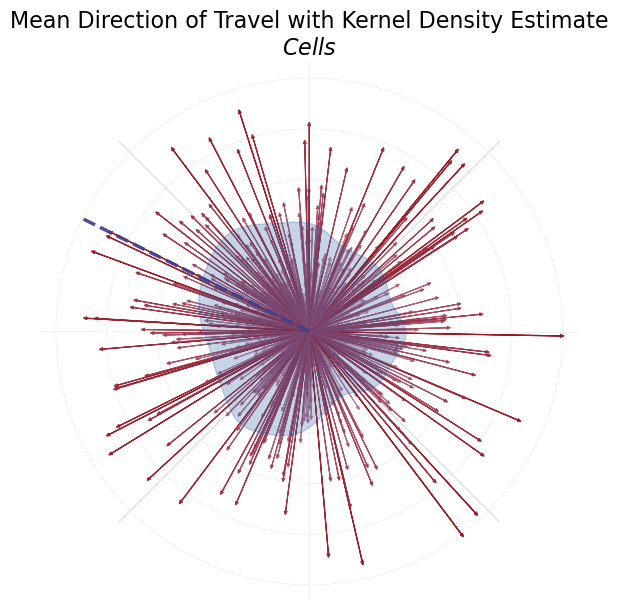

In [ ]:
cmap_cells = mcolors.LinearSegmentedColormap.from_list("", ["#9b598910", "#9b181eff"]) #303030
cmap_frames = plt.get_cmap('viridis')

def migration_directions_with_kde_plus_mean(df, metric, subject, scaling_metric, cmap_normalization_metric, cmap, threshold):

    # Recognizing the presence of a threshold
    if threshold == None:
        threshold = '_no_threshold'
    else:
        threshold = '_' + threshold

    df_mean_direction = df[metric]

    # Prepare for KDE plot
    x_kde = np.cos(df_mean_direction)
    y_kde = np.sin(df_mean_direction)
    kde = gaussian_kde([x_kde, y_kde])

    # Define the grid for evaluation
    theta_kde = np.linspace(0, 2 * np.pi, 360)
    x_grid = np.cos(theta_kde)
    y_grid = np.sin(theta_kde)

    # Evaluate the KDE on the grid and normalize
    z_kde = kde.evaluate([x_grid, y_grid])
    z_kde = z_kde / z_kde.max() * 0.5  # Normalize to fit within the radial limit

    # Calculate the mean direction
    mean_direction = np.arctan2(np.mean(y_kde), np.mean(x_kde))

    # Start plotting
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'polar': True})

    # Plot KDE
    ax.plot(theta_kde, z_kde, label='Circular KDE', color='None', zorder=5)
    ax.fill(theta_kde, z_kde, alpha=0.25, color='#1b5a9e', zorder=5)

    # Directional Arrows
    scaling_max = df[scaling_metric].max()

    # Normalization of the color map
    if cmap_normalization_metric == None:
        norm = mcolors.Normalize(vmin=0, vmax=1)
    else:
        normalization_min = df[cmap_normalization_metric].min()
        normalization_max = df[cmap_normalization_metric].max()
        norm = mcolors.Normalize(vmin=normalization_min, vmax=normalization_max)

    # Row itteration
    for _, row in df.iterrows():
        scaling_metrics = row[scaling_metric]
        mean_direction_rad = row[metric]
        arrow_length = scaling_metrics / scaling_max

        if cmap_normalization_metric == None:
            color = cmap(norm(arrow_length))
        else:
            color = cmap(norm(row[cmap_normalization_metric]))

        if arrow_length == 0:
            continue  # Skip if the arrow length is zero

        # Dynamically adjust the head size based on arrow_length
        scaling_factor = 1 / arrow_length if arrow_length != 0 else 1
        head_width = 0.011 * scaling_factor
        head_length = 0.013

        ax.arrow(mean_direction_rad, 0, 0, arrow_length, color=color, linewidth=0.75, 
                head_width=head_width, head_length=head_length, zorder=4)

    # Plot the dashed line in the mean direction
    ax.plot([mean_direction, mean_direction], [0, 1], linestyle='--', color='darkslateblue', alpha=0.93, linewidth=2.5, zorder=6)

    # Hide the polar plot frame (spines) but keep the grid visible
    ax.spines['polar'].set_visible(False)
    # Customize grid lines (if needed)
    ax.grid(True, 'major', color='#C6C6C6', linestyle='-', linewidth=0.5, zorder=1)

    # Access and customize the radial grid lines
    radial_lines = ax.get_xgridlines()
    for i, line in enumerate(radial_lines):
        if i % 2 == 0:  # Customize every other radial grid line
            line.set_linestyle('--')
            line.set_color('#E6E6E6')
            line.set_linewidth(0.5)

    radial_lines = ax.get_ygridlines()
    for i, line in enumerate(radial_lines):
        line.set_linestyle('--')
        line.set_color('#E6E6E6')
        line.set_linewidth(0.5)

    # Customize the appearance of the polar plot
    ax.set_title(f'Mean Direction of Travel with Kernel Density Estimate\n$\it{{{subject}}}$', fontsize=title_size)
    ax.set_yticklabels([])  # Remove radial labels
    ax.set_xticklabels([])  # Remove angular labels

    # Save the plot
    plt.savefig(op.join(save_path, f'02c_Plot_directions_of_travel_with_mean_and_kernel_density_estimate_{subject}_{scaling_metric}{threshold}.png'), dpi=500)
    # plt.show()
migration_directions_with_kde_plus_mean(Track_stats, 'MEAN_DIRECTION_RAD', 'Cells', 'CONFINEMENT_RATIO', None, cmap_cells, None)
migration_directions_with_kde_plus_mean(Track_stats, 'MEAN_DIRECTION_RAD', 'Cells', 'NET_DISTANCE', None, cmap_cells, None)
# migration_directions_with_kde_plus_mean(Track_stats, 'MEAN_DIRECTION_DEG_weight_confinement', 'Cells (weighted)', 'CONFINEMENT_RATIO', None, cmap_cells, None)
# migration_directions_with_kde_plus_mean(Track_stats, 'MEAN_DIRECTION_DEG_weight_confinement', 'Cells (weighted)', 'NET_DISTANCE', None, cmap_cells, None)
# migration_directions_with_kde_plus_mean(Track_stats, 'MEAN_DIRECTION_RAD_weight_net_dis', 'Cells (weighted)', 'CONFINEMENT_RATIO', None, cmap_cells, None)
# migration_directions_with_kde_plus_mean(Track_stats, 'MEAN_DIRECTION_DEG_weight_net_dis', 'Cells (weighted)', 'NET_DISTANCE', None, cmap_cells, None)
migration_directions_with_kde_plus_mean(Frame_stats, 'MEAN_DIRECTION_RAD', 'Frames (weighted)', 'MEAN_DISTANCE', 'POSITION_T', cmap_frames, None)
migration_directions_with_kde_plus_mean(Frame_stats, 'MEAN_DIRECTION_RAD_weight_mean_dis', 'Frames (weighted)', 'MEAN_DISTANCE', 'POSITION_T', cmap_frames, None) 




# Idea:
# Add a slider to the plot that allows the user to adjust the threshold dynamically.
# This would require using a library like ipywidgets or similar to create an interactive plot.
# Tracks above the would be coloured with the use of the lut map and the rest would be greyed out.
# Add a posibility to save the plot with the current threshold value.
# Add a selection of the metrics to be used for the thresholding. The slider should have the same range as the selected metric.
# Add a text output showing the current threshold value and the number of tracks above the threshold vs the whole number of tracks.

In [ ]:
def donut(df, ax, outer_radius, inner_radius, kde_bw):
    # Extend the data circularly to account for wrap-around at 0 and 2*pi
    extended_data = np.concatenate([df - 2 * np.pi, df, df + 2 * np.pi])

    # Create a grid of theta values (angles)
    theta_grid = np.linspace(0, 2 * np.pi, 360)  # 360 points over full circle
    
    # Create a grid of radii
    r_grid = np.linspace(inner_radius, outer_radius, 100)  # Radius from inner to outer edge
    
    # Compute KDE values for the extended data
    kde = gaussian_kde(extended_data, bw_method=kde_bw)
    kde_values = kde.evaluate(theta_grid)  # Evaluate KDE on the regular theta grid
    
    # Repeat KDE values across radii to create the heatmap data
    kde_values = np.tile(kde_values, (r_grid.size, 1))
    
    # Normalize KDE values for consistent color mapping
    norm = Normalize(vmin=kde_values.min(), vmax=kde_values.max())
    
    # Create the meshgrid for the polar plot
    theta_mesh, r_mesh = np.meshgrid(theta_grid, r_grid)
    
    # Remove polar grid lines and labels
    ax.grid(False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.spines['polar'].set_visible(False)  # Hide the outer frame

    return theta_mesh, r_mesh, kde_values, norm

: 

: 

: 

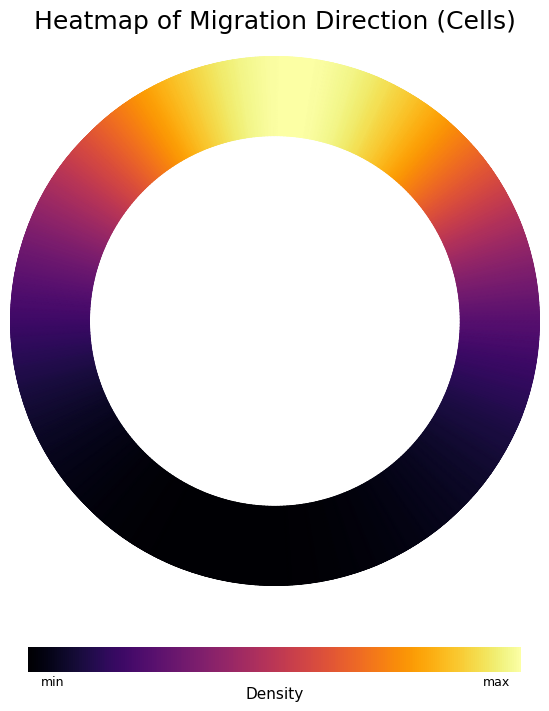

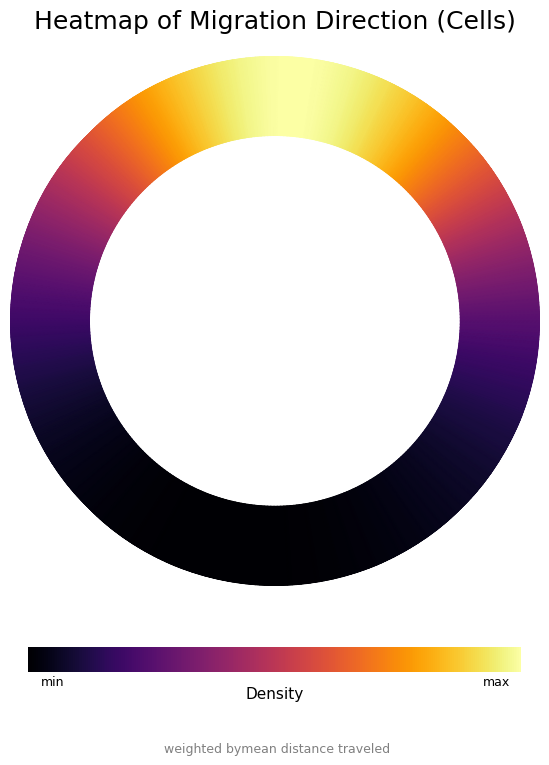

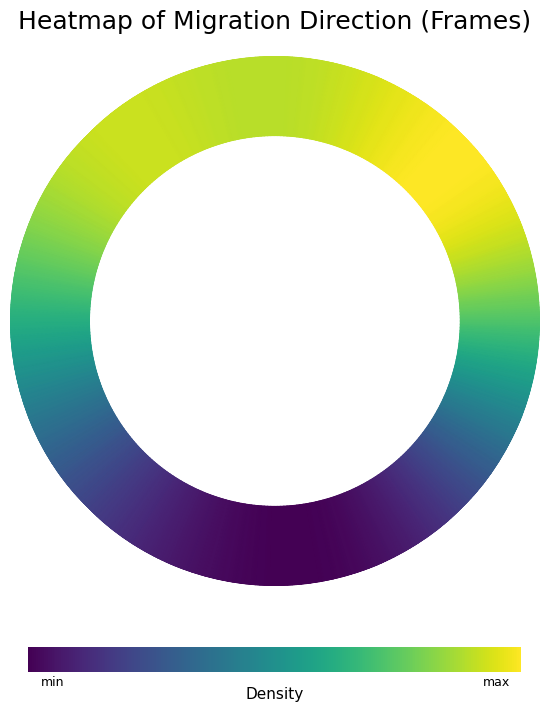

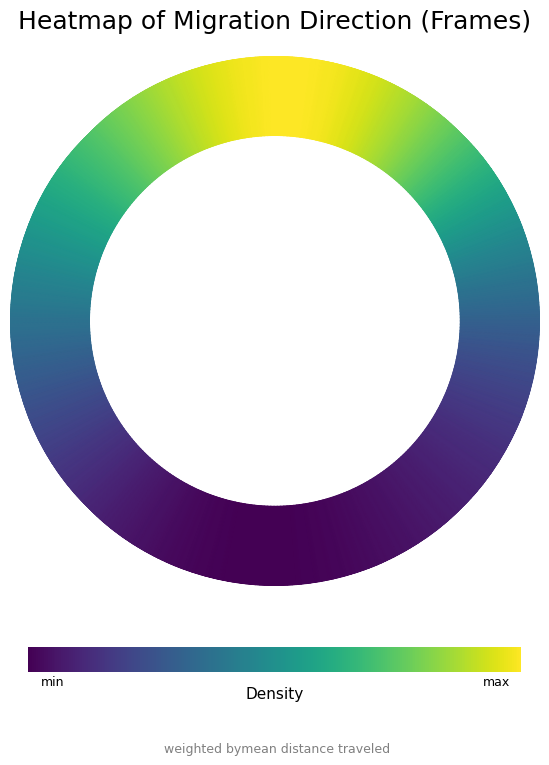

: 

: 

: 

In [ ]:

def df_gaussian_donut(df, metric, subject, heatmap, weight, threshold):

    # Recognizing the presence of a threshold
    if threshold == None:
        threshold = '_no_threshold'
    else:
        threshold = '_' + threshold

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
    
    diameter=2
    width_ratio=0.3
    kde_bw=0.1

    df=df[metric]

    # Calculate radius and width from the diameter
    outer_radius = diameter / 2
    width = width_ratio * outer_radius
    inner_radius = outer_radius - width
    
    theta_mesh, r_mesh, kde_values, norm = donut(df, ax, outer_radius, inner_radius, kde_bw)
    
    # Set title and figure text
    ax.set_title(f'Heatmap of Migration Direction ({subject})', pad=20, ha='center', fontsize=title_size)
    
    # Add a colorbar
    cbar = plt.colorbar(ax.pcolormesh(theta_mesh, r_mesh, kde_values, shading='gouraud', cmap=heatmap, norm=norm), ax=ax, fraction=0.04, orientation='horizontal', pad=0.1)
    cbar.set_ticks([])
    cbar.outline.set_visible(False)  # Remove outline
    
    # Add min and max labels below the colorbar
    cbar.ax.text(0.05, -0.4, 'min', va='center', ha='center', color='black', transform=cbar.ax.transAxes, fontsize=9)
    cbar.ax.text(0.95, -0.4, 'max', va='center', ha='center', color='black', transform=cbar.ax.transAxes, fontsize=9)

    # Add the density label below the min and max labels
    cbar.set_label('Density', labelpad=10, fontsize=label_size)
    
    if weight == None:
        plt.savefig(op.join(save_path, f'04a_Plot_donut_heatmap-migration_direction_{subject}{threshold}.png'), dpi=300)
    else:
        weight = 'weighted by' + weight
        plt.figtext(0.515, 0.01, f'{weight}', ha='center', color=figtext_color, fontsize=figtext_size)
        plt.savefig(op.join(save_path, f'04a_Plot_donut_heatmap-migration_direction_{subject}{weight}{threshold}.png'), dpi=300)

    # plt.show()
df_gaussian_donut(Track_stats, 'MEAN_DIRECTION_RAD', 'Cells', 'inferno', None, None)
df_gaussian_donut(Track_stats, 'MEAN_DIRECTION_RAD', 'Cells', 'inferno', 'mean distance traveled', None)
# df_gaussian_donut(Track_stats_thresholded_at_20th_percentile, 'MEAN_DIRECTION_RAD', 'Cells', 'inferno', 'thresholded_at_20th_percentile') # 20th
# df_gaussian_donut(Track_stats_thresholded_at_40th_percentile, 'MEAN_DIRECTION_RAD', 'Cells', 'inferno', 'thresholded_at_40th_percentile') # 40th
# df_gaussian_donut(Track_stats_thresholded_at_60th_percentile, 'MEAN_DIRECTION_RAD', 'Cells', 'inferno', 'thresholded_at_60th_percentile') # 60th
# df_gaussian_donut(Track_stats_thresholded_at_80th_percentile, 'MEAN_DIRECTION_RAD', 'Cells', 'inferno', 'thresholded_at_80th_percentile') # 80th
# df_gaussian_donut(Track_stats_thresholded_at_90th_percentile, 'MEAN_DIRECTION_RAD', 'Cells', 'inferno', 'thresholded_at_90th_percentile') # 90th
df_gaussian_donut(Frame_stats, 'MEAN_DIRECTION_RAD', 'Frames', 'viridis', None, None)
df_gaussian_donut(Frame_stats, 'MEAN_DIRECTION_RAD_weight_mean_dis', 'Frames', 'viridis', 'mean distance traveled', None)


---
# *To try* / *To do* List

<ul>
    <li><input type="checkbox"> Weight Mean direction of travel in Time_Stats also by the NET_DISTANCE, making the dataset contain two columns for the weighted mean direction; by confinement ratio as well as net distance </li>

</ul>
